[00:08:05] Directorio de guardado para la versión 'banano' creado/verificado: /home/administrador/proyectos/backend-cafe-ia/progress/banano
✅ Archivo cargado con éxito.
Número total de filas iniciales: 92022

[00:09:09] Iniciando preprocesamiento y agregación de datos por día.
✅ Agregación completada. Filas después de agrupar por día: 3283

[00:09:10] Iniciando la detección y análisis de outliers.

--- Visualización de Boxplots ANTES del tratamiento ---


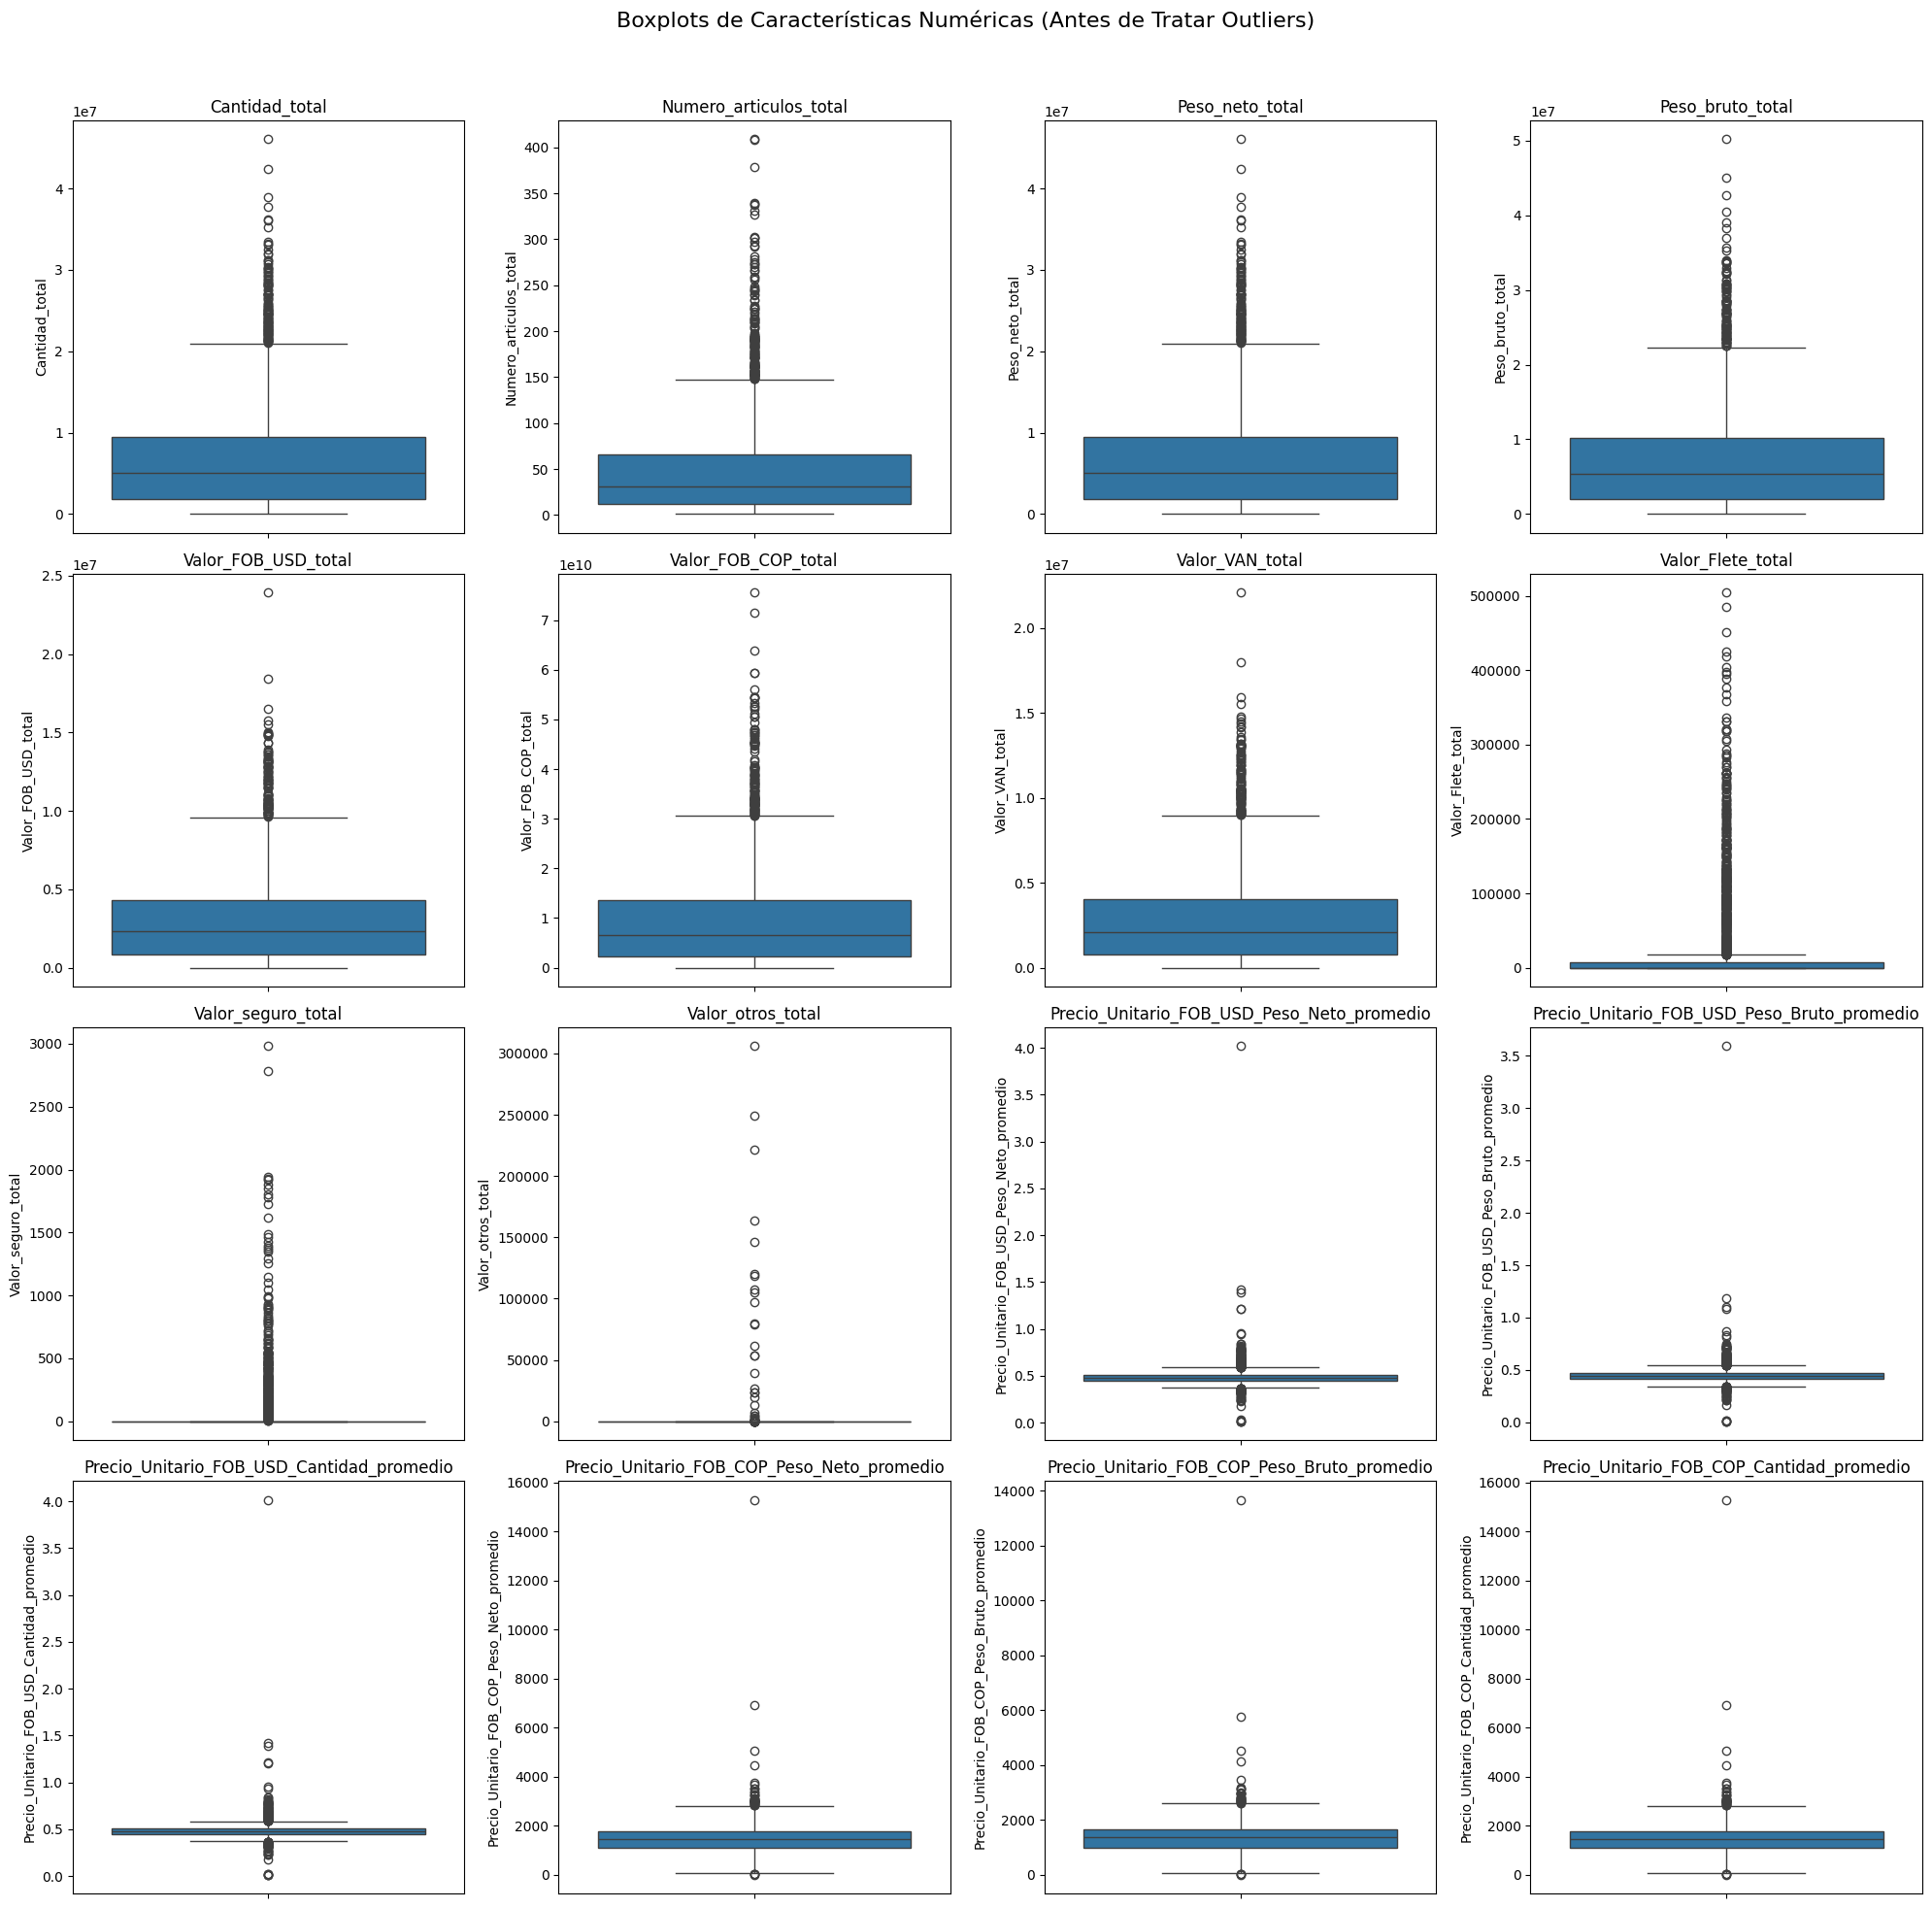


[00:09:14] Aplicando la estrategia de reemplazo de outliers...
✅ Tratamiento de outliers completado. Los valores atípicos han sido reemplazados.

--- Visualización de Boxplots DESPUÉS del tratamiento ---


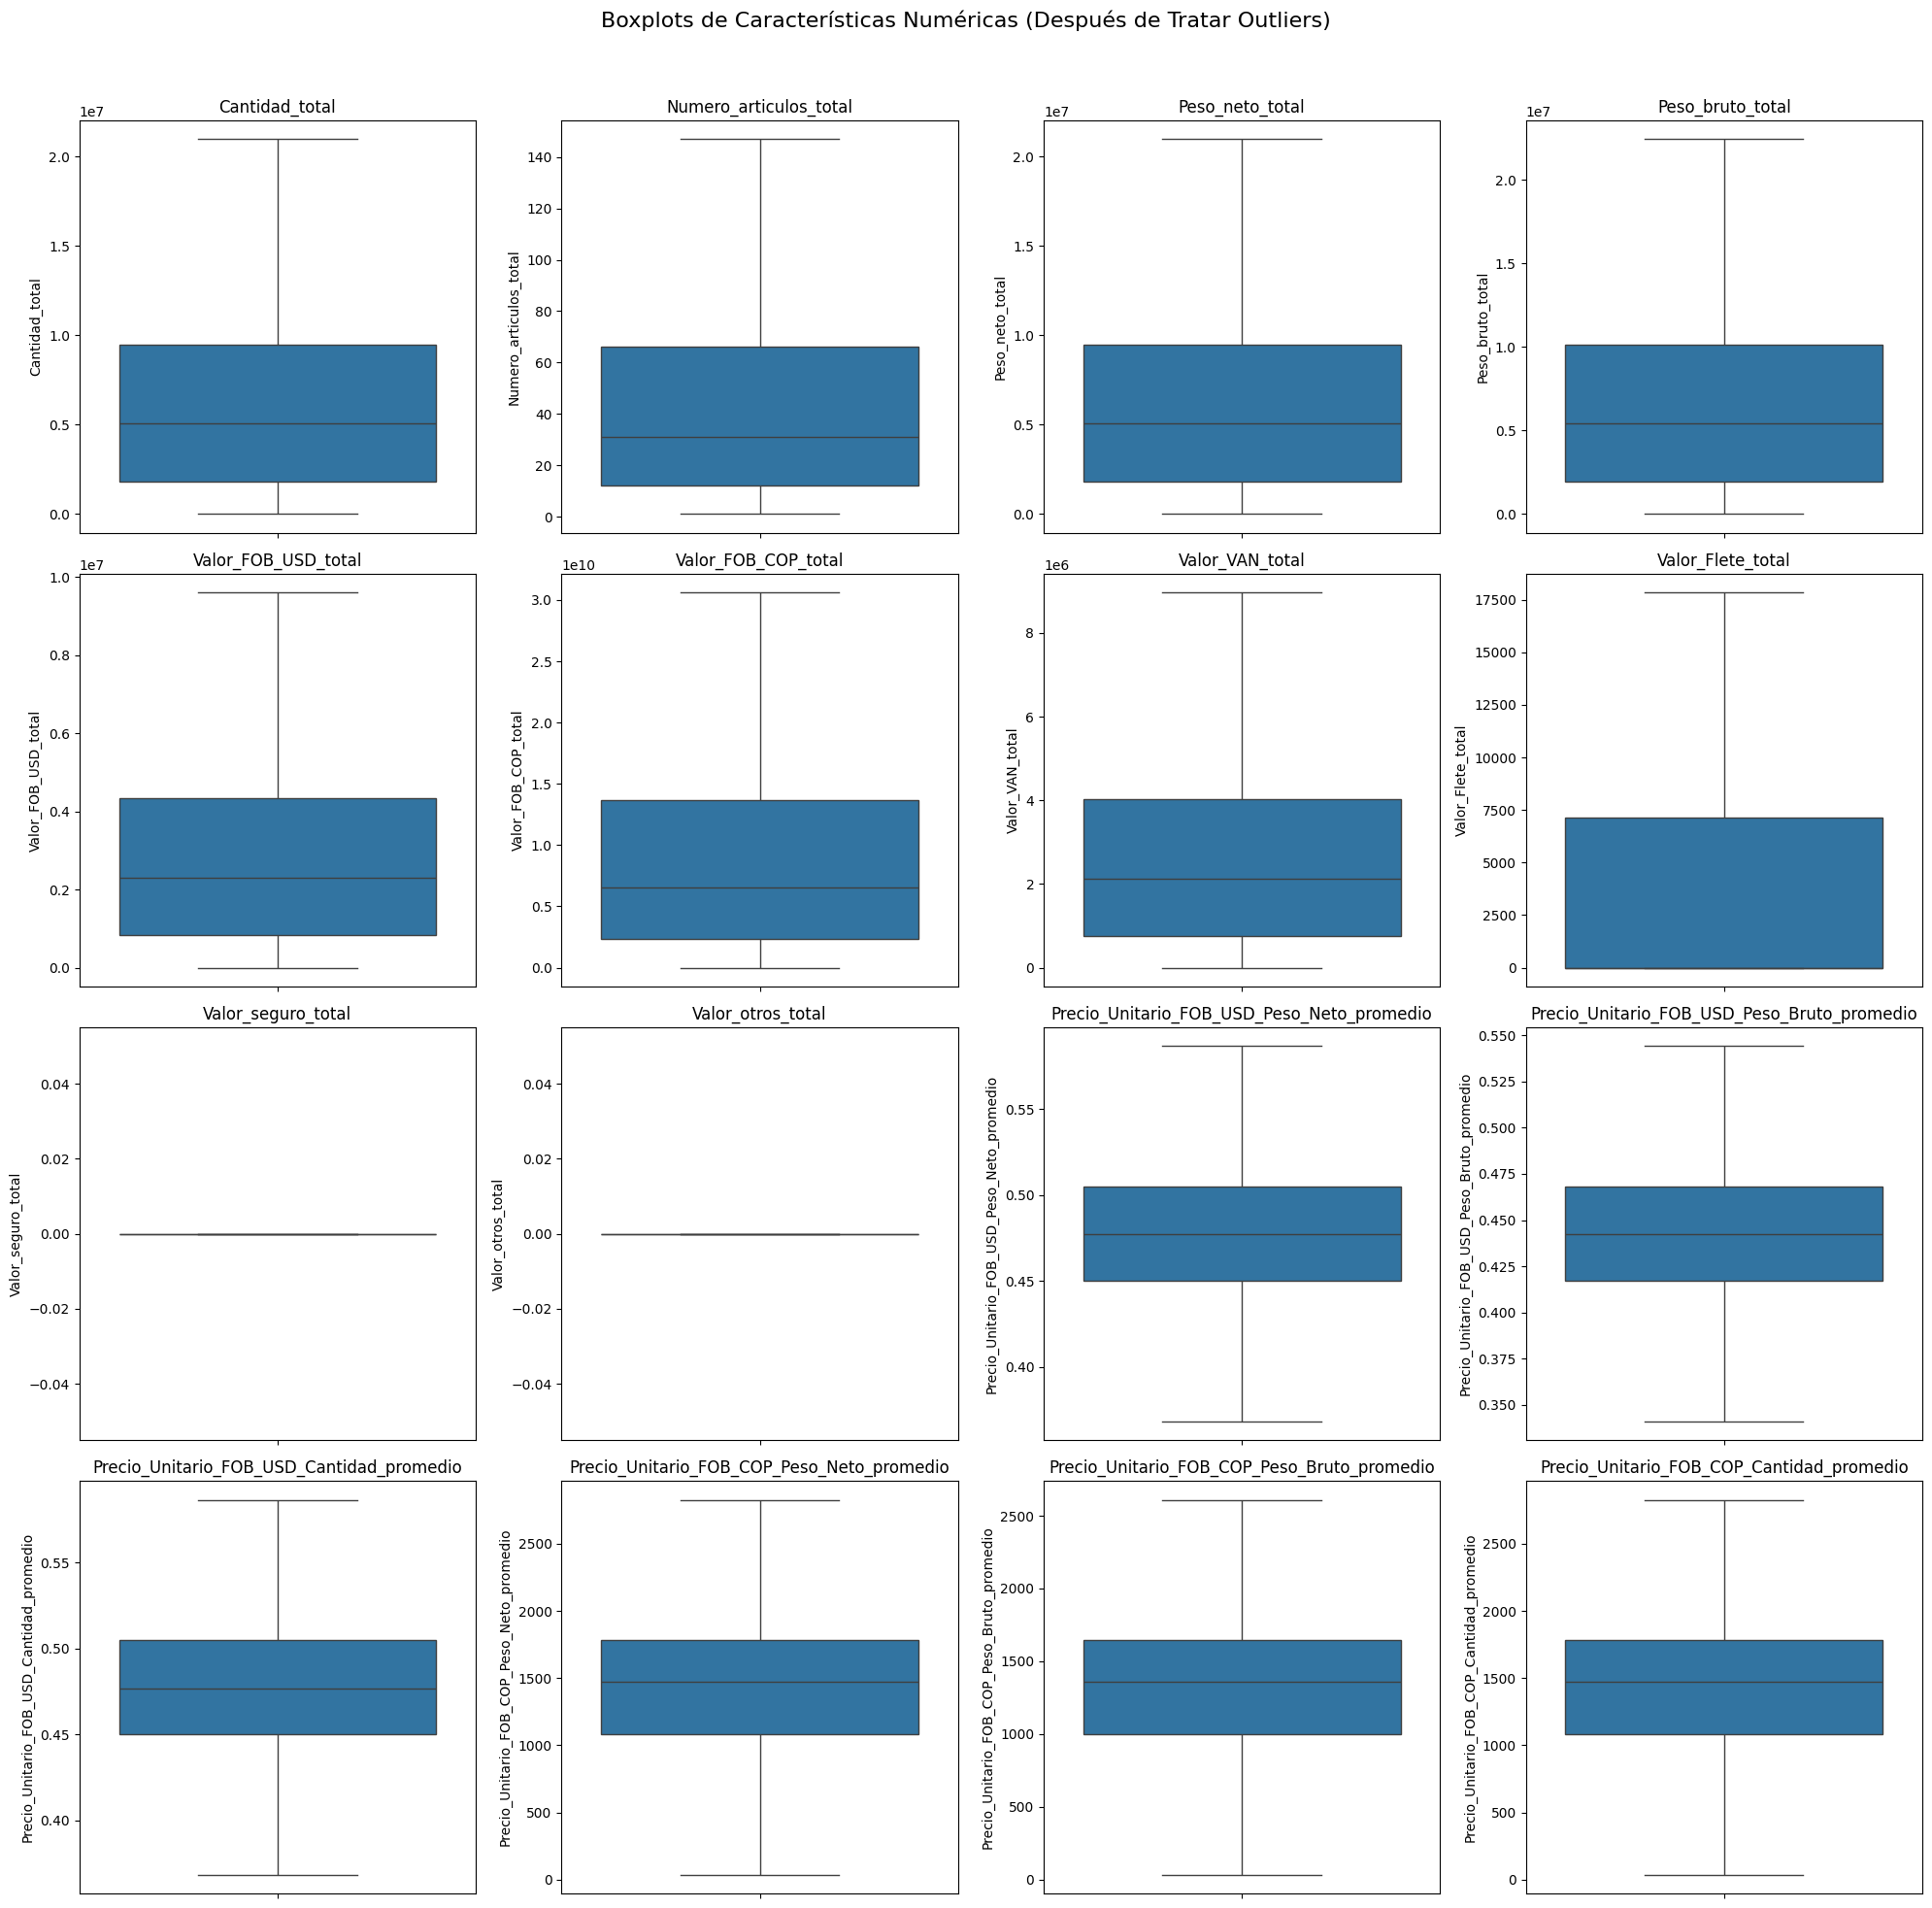


[00:09:18] Creación de características de series de tiempo (lags y rolling).
✅ Preprocesamiento completado. Filas finales para PCA: 3276

[00:09:18] Iniciando el análisis exploratorio de datos (EDA).

--- Visualización de la Serie de Tiempo Procesada ---


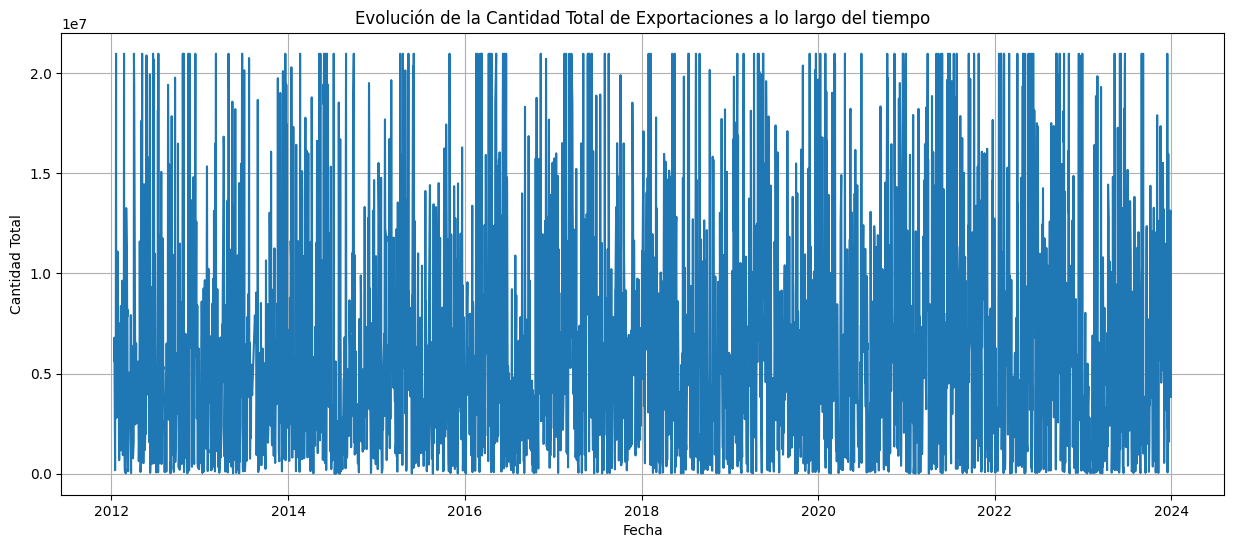


--- Matriz de Correlación ---


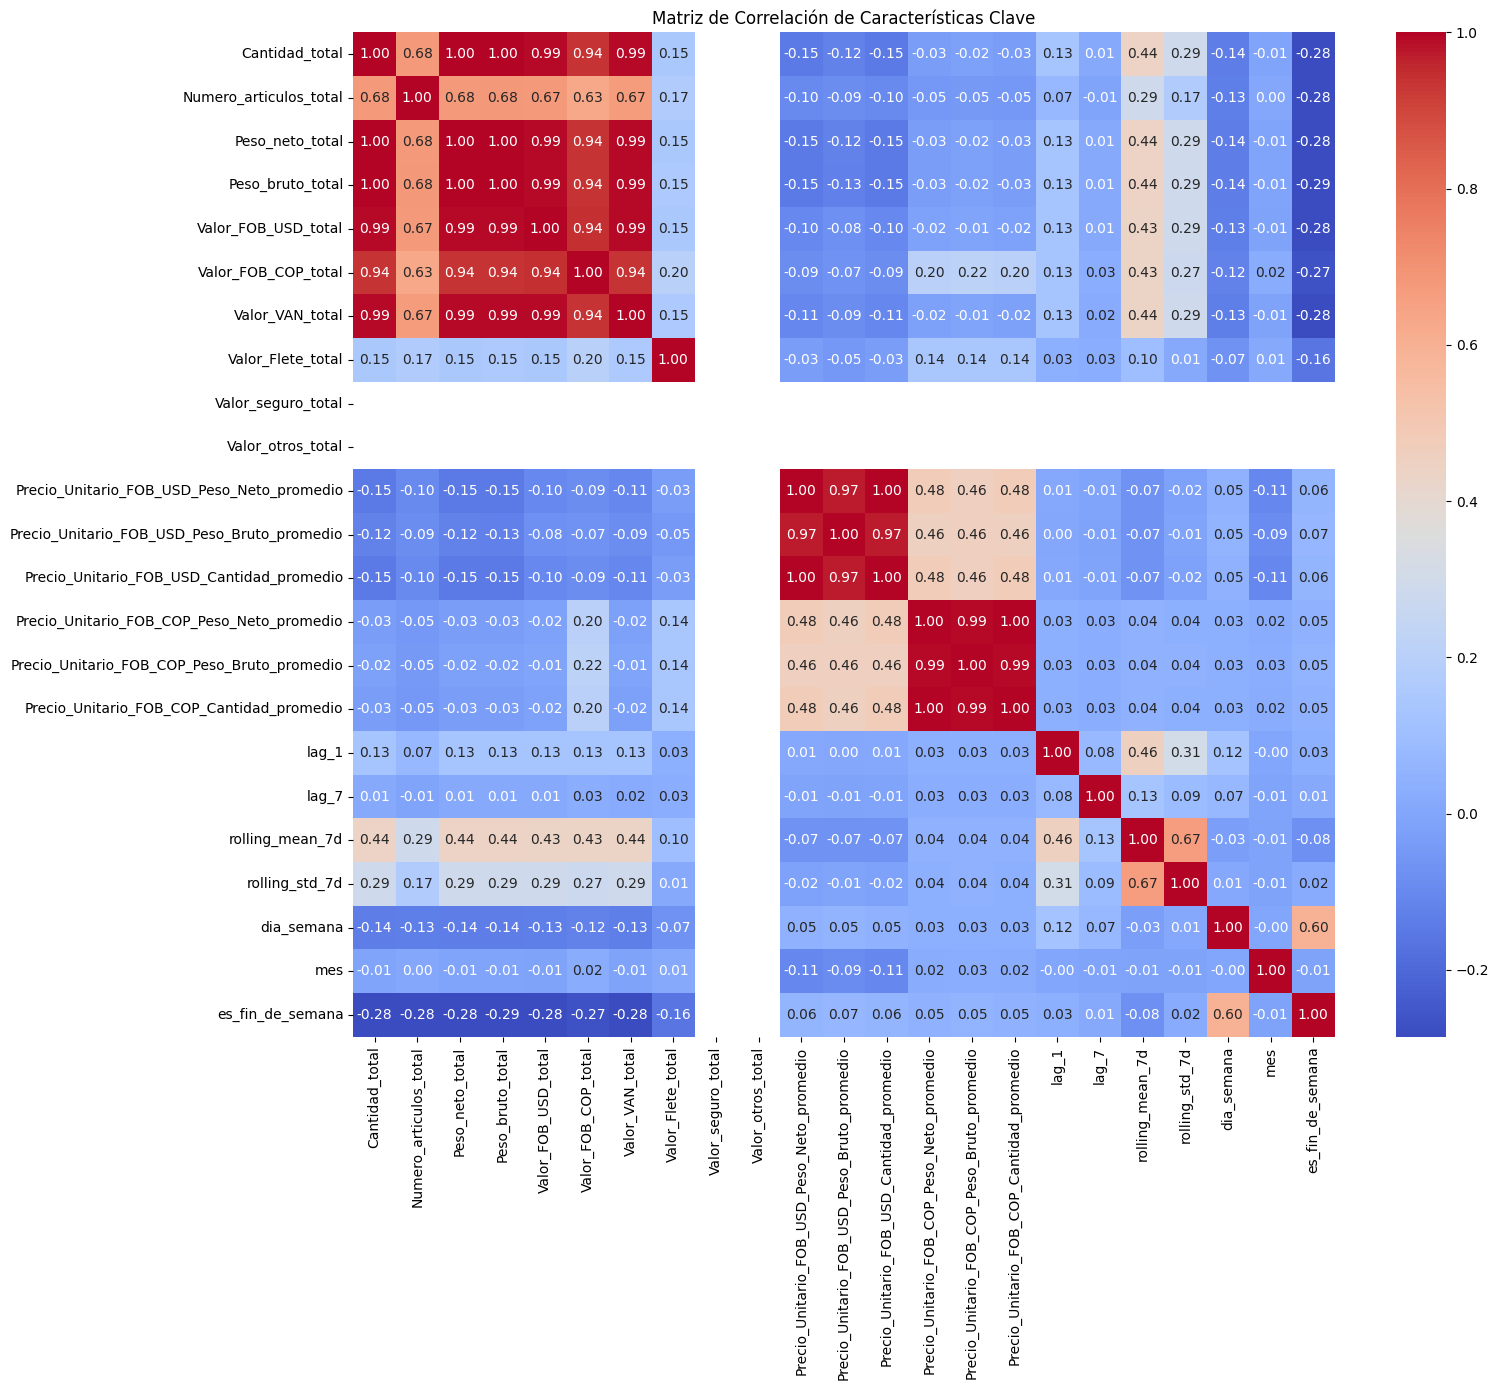

✅ Columnas eliminadas debido a la alta correlación: Peso_bruto_total, Peso_neto_total, Valor_FOB_USD_total, Valor_VAN_total, Valor_FOB_COP_total

--- Descomposición de la Serie de Tiempo ---


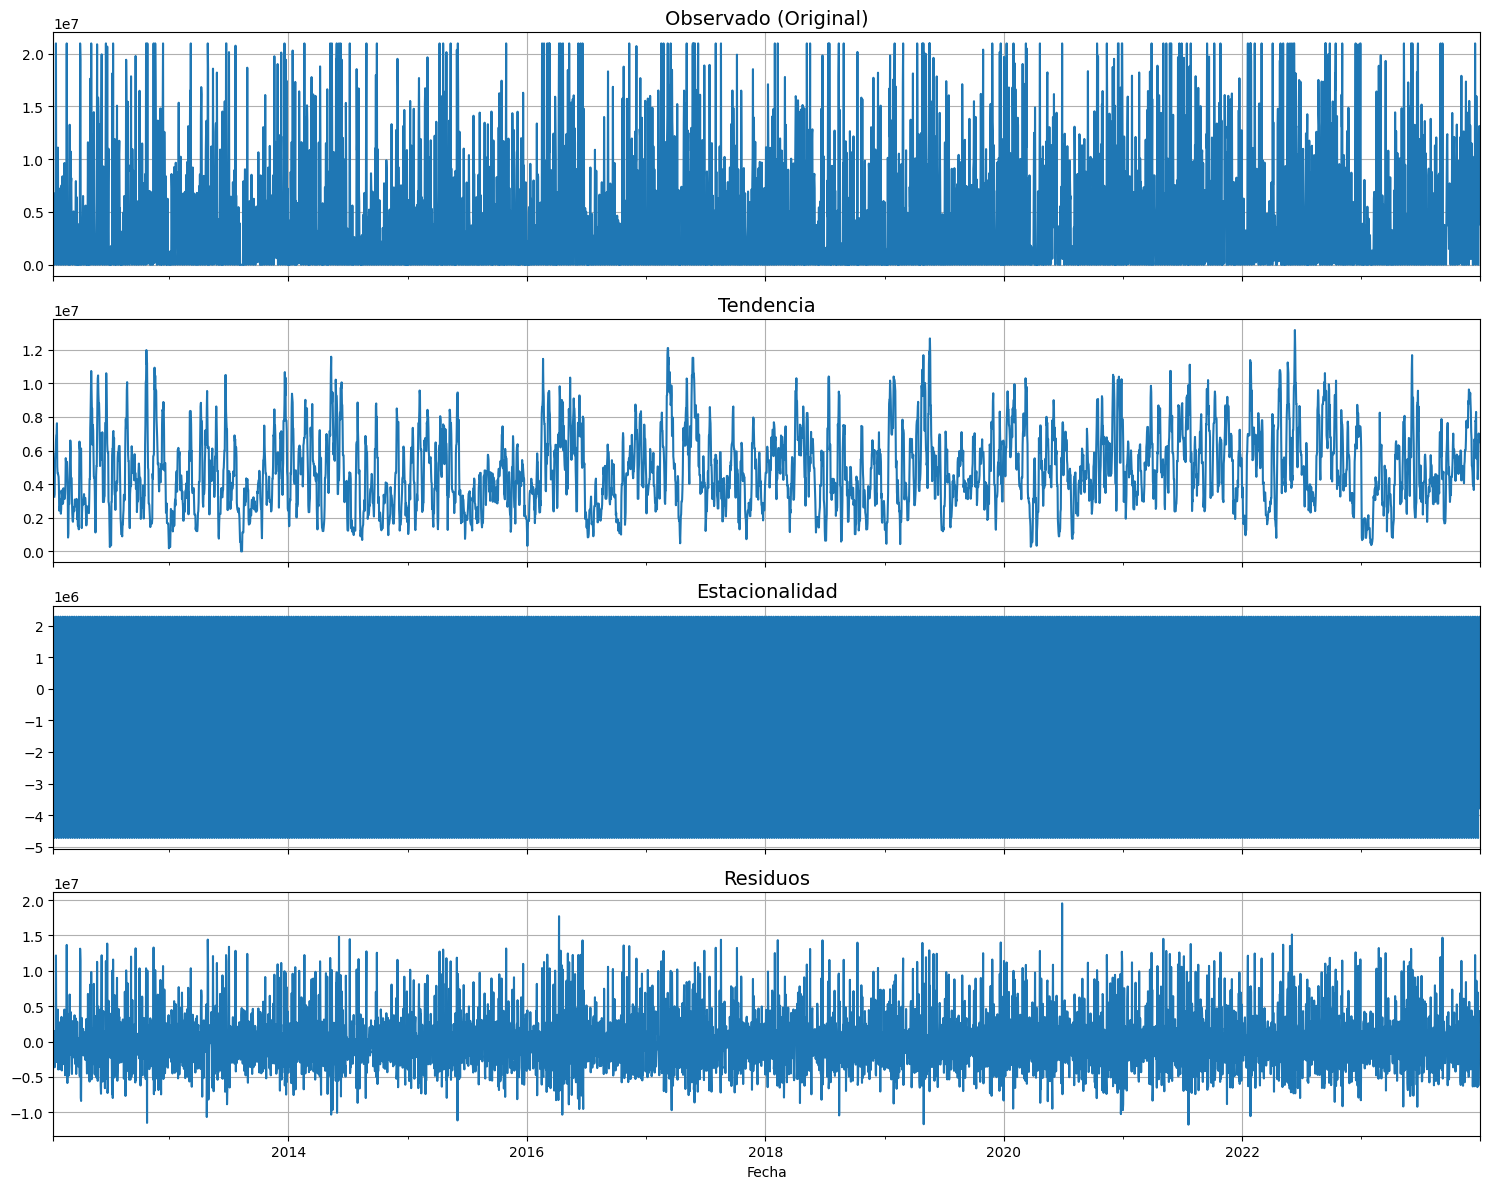


✅ DataFrame procesado y listo para el siguiente paso. Guardado en: /home/administrador/proyectos/backend-cafe-ia/progress/banano/df_agregado_procesado.csv
✅ EDA y Preprocesamiento completado. Los datos están listos para la fase de modelado.


In [1]:
#celda uno con correcion de la vairable a eliminar despues de ver la matriz de correlacion
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from datetime import datetime
import math

# ==============================================================================
# --- 1. CARGA DE DATOS Y CONFIGURACIÓN INICIAL ---
# ==============================================================================

# Define la ruta de guardado para los resultados de esta fase
VERSION_SAVE_DIR = '/home/administrador/proyectos/backend-cafe-ia/progress/banano'
os.makedirs(VERSION_SAVE_DIR, exist_ok=True)
print(f"[{time.strftime('%H:%M:%S')}] Directorio de guardado para la versión 'banano' creado/verificado: {VERSION_SAVE_DIR}")

# Define la ruta al archivo de datos original
DATA_FILE_PATH = '/home/administrador/proyectos/backend-cafe-ia/data/todo_el_df_sin_procesar_banano.xlsx'


try:
    df = pd.read_excel(DATA_FILE_PATH, header=0)
    # Elimina los espacios en blanco de los nombres de las columnas para mayor consistencia
    df.columns = df.columns.str.strip()
    print("✅ Archivo cargado con éxito.")
    print(f"Número total de filas iniciales: {len(df)}")
except FileNotFoundError:
    print(f"❌ Error: No se encontró el archivo en la ruta '{DATA_FILE_PATH}'.")
    raise


# ==============================================================================
# --- 2. PREPROCESAMIENTO Y AGREGACIÓN POR DÍA ---
# ==============================================================================
print(f"\n[{time.strftime('%H:%M:%S')}] Iniciando preprocesamiento y agregación de datos por día.")

# Renombrar TODAS las columnas numéricas para consistencia
rename_mapping = {
    'Cantidad(es)': 'Cantidad_total',
    'Peso en kilos netos': 'Peso_neto_total',
    'Peso en kilos brutos': 'Peso_bruto_total',
    'Valor FOB (USD)': 'Valor_FOB_USD_total',
    'Valor FOB (COP)': 'Valor_FOB_COP_total',
    'Valor Agregado Nacional (VAN)': 'Valor_VAN_total',
    'Valor Flete': 'Valor_Flete_total',
    'Valor seguro': 'Valor_seguro_total',
    'Valor otros': 'Valor_otros_total',
    'Número de artículos': 'Numero_articulos_total',
    'Precio Unitario FOB (USD) Peso Neto': 'Precio_Unitario_FOB_USD_Peso_Neto_promedio',
    'Precio Unitario FOB (USD) Peso Bruto': 'Precio_Unitario_FOB_USD_Peso_Bruto_promedio',
    'Precio Unitario FOB (USD) Cantidad': 'Precio_Unitario_FOB_USD_Cantidad_promedio',
    'Precio Unitario FOB (COP) Peso Neto': 'Precio_Unitario_FOB_COP_Peso_Neto_promedio',
    'Precio Unitario FOB (COP) Peso Bruto': 'Precio_Unitario_FOB_COP_Peso_Bruto_promedio',
    'Precio Unitario FOB (COP) Cantidad': 'Precio_Unitario_FOB_COP_Cantidad_promedio',
}
df.rename(columns=rename_mapping, inplace=True)

# Convertir las columnas de fecha y numéricas a su tipo correcto
for col in rename_mapping.values():
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

df['Fecha_completa'] = pd.to_datetime(df[['Año', 'Mes', 'Dia']].astype(int).astype(str).agg('-'.join, axis=1), errors='coerce')
df.dropna(subset=['Fecha_completa'], inplace=True)

# Agregación: sumamos las cantidades y valores, y promediamos los precios unitarios
agg_dict = {
    'Cantidad_total': 'sum',
    'Numero_articulos_total': 'sum',
    'Peso_neto_total': 'sum',
    'Peso_bruto_total': 'sum',
    'Valor_FOB_USD_total': 'sum',
    'Valor_FOB_COP_total': 'sum',
    'Valor_VAN_total': 'sum',
    'Valor_Flete_total': 'sum',
    'Valor_seguro_total': 'sum',
    'Valor_otros_total': 'sum',
    'Precio_Unitario_FOB_USD_Peso_Neto_promedio': 'mean',
    'Precio_Unitario_FOB_USD_Peso_Bruto_promedio': 'mean',
    'Precio_Unitario_FOB_USD_Cantidad_promedio': 'mean',
    'Precio_Unitario_FOB_COP_Peso_Neto_promedio': 'mean',
    'Precio_Unitario_FOB_COP_Peso_Bruto_promedio': 'mean', # Corregido para que coincida con el dict
    'Precio_Unitario_FOB_COP_Cantidad_promedio': 'mean'
}
df_agregado = df.groupby('Fecha_completa').agg(agg_dict).reset_index()

print(f"✅ Agregación completada. Filas después de agrupar por día: {len(df_agregado)}")

# ==============================================================================
# --- 3. DETECCIÓN Y ANÁLISIS DE OUTLIERS (REVISADO Y VISUALIZADO) ---
# ==============================================================================
print(f"\n[{time.strftime('%H:%M:%S')}] Iniciando la detección y análisis de outliers.")
columnas_numericas = df_agregado.select_dtypes(include=np.number).columns.tolist()
columnas_a_tratar = [col for col in columnas_numericas if 'lag' not in col and 'rolling' not in col]


# --- Visualización ANTES del tratamiento (Boxplots originales) ---
print("\n--- Visualización de Boxplots ANTES del tratamiento ---")
num_cols = len(columnas_a_tratar)
num_rows = math.ceil(num_cols / 4)
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, 5 * num_rows))
fig.suptitle('Boxplots de Características Numéricas (Antes de Tratar Outliers)', fontsize=16)
axes = axes.flatten()

for i, col in enumerate(columnas_a_tratar):
    sns.boxplot(y=df_agregado[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

for j in range(num_cols, len(axes)):
    axes[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(VERSION_SAVE_DIR, 'outliers_before_treatment_boxplots.png'))
plt.show()

# 🚨 CAMBIO DE ESTRATEGIA: Reemplazar los outliers con los límites del IQR
print(f"\n[{time.strftime('%H:%M:%S')}] Aplicando la estrategia de reemplazo de outliers...")

def replace_outliers_with_iqr(df, column):
    """
    Función para reemplazar los outliers de una columna por los límites del IQR.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
    
# Aplicar la función a todas las columnas numéricas relevantes
for col in columnas_a_tratar:
    replace_outliers_with_iqr(df_agregado, col)

print(f"✅ Tratamiento de outliers completado. Los valores atípicos han sido reemplazados.")

# --- Visualización DESPUÉS del tratamiento (Boxplots modificados) ---
print("\n--- Visualización de Boxplots DESPUÉS del tratamiento ---")
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, 5 * num_rows))
fig.suptitle('Boxplots de Características Numéricas (Después de Tratar Outliers)', fontsize=16)
axes = axes.flatten()

for i, col in enumerate(columnas_a_tratar):
    sns.boxplot(y=df_agregado[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

for j in range(num_cols, len(axes)):
    axes[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(VERSION_SAVE_DIR, 'outliers_after_treatment_boxplots.png'))
plt.show()
    
# ==============================================================================
# --- 4. CREACIÓN DE CARACTERÍSTICAS DE SERIES DE TIEMPO (AHORA CON ANÁLISIS CAUSAL) ---
# ==============================================================================
print(f"\n[{time.strftime('%H:%M:%S')}] Creación de características de series de tiempo (lags y rolling).")
df_agregado.sort_values(by='Fecha_completa', inplace=True)
df_agregado.reset_index(drop=True, inplace=True)

# Crear nuevas características para dar contexto al modelo
# Día de la semana: 0 = Lunes, 6 = Domingo
df_agregado['dia_semana'] = df_agregado['Fecha_completa'].dt.dayofweek

# Mes del año
df_agregado['mes'] = df_agregado['Fecha_completa'].dt.month

# Indicador de fin de semana
df_agregado['es_fin_de_semana'] = df_agregado['dia_semana'].isin([5, 6]).astype(int)

# Crear características de rezago (lags)
df_agregado['lag_1'] = df_agregado['Cantidad_total'].shift(1)
df_agregado['lag_7'] = df_agregado['Cantidad_total'].shift(7)

# Crear características de media móvil y desviación estándar
df_agregado['rolling_mean_7d'] = df_agregado['Cantidad_total'].rolling(window=7, min_periods=1).mean()
df_agregado['rolling_std_7d'] = df_agregado['Cantidad_total'].rolling(window=7, min_periods=1).std()

# Eliminar las filas con valores NaN en las nuevas características
df_agregado.dropna(subset=['lag_7', 'rolling_std_7d'], inplace=True)
df_agregado.reset_index(drop=True, inplace=True)

print(f"✅ Preprocesamiento completado. Filas finales para PCA: {len(df_agregado)}")

# ==============================================================================
# --- 5. ANÁLISIS EXPLORATORIO DE DATOS (EDA) ---
# ==============================================================================
print(f"\n[{time.strftime('%H:%M:%S')}] Iniciando el análisis exploratorio de datos (EDA).")

# 1. Visualización de la Serie de Tiempo
print("\n--- Visualización de la Serie de Tiempo Procesada ---")
plt.figure(figsize=(15, 6))
plt.plot(df_agregado['Fecha_completa'], df_agregado['Cantidad_total'])
plt.title('Evolución de la Cantidad Total de Exportaciones a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Total')
plt.grid(True)
plt.savefig(os.path.join(VERSION_SAVE_DIR, 'time_series_evolution.png'))
plt.show()

# 2. Matriz de Correlación
print("\n--- Matriz de Correlación ---")
# Lista de TODAS las columnas numéricas para la matriz de correlación
columnas_correlacion = [
    'Cantidad_total', 'Numero_articulos_total',  'Peso_neto_total', 
    'Peso_bruto_total', 'Valor_FOB_USD_total', 'Valor_FOB_COP_total',
    'Valor_VAN_total', 'Valor_Flete_total', 'Valor_seguro_total',
    'Valor_otros_total', 'Precio_Unitario_FOB_USD_Peso_Neto_promedio',
    'Precio_Unitario_FOB_USD_Peso_Bruto_promedio', 'Precio_Unitario_FOB_USD_Cantidad_promedio',
    'Precio_Unitario_FOB_COP_Peso_Neto_promedio', 'Precio_Unitario_FOB_COP_Peso_Bruto_promedio',
    'Precio_Unitario_FOB_COP_Cantidad_promedio', 'lag_1', 'lag_7',
    'rolling_mean_7d', 'rolling_std_7d', 'dia_semana', 'mes', 'es_fin_de_semana'
]
corr_matrix = df_agregado[columnas_correlacion].corr()

plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Características Clave')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(VERSION_SAVE_DIR, 'correlation_matrix_full.png'))
plt.show()

# 🚨 CORRECCIÓN: Eliminar las columnas con alta correlación para evitar multicolinealidad
variables_a_eliminar = [
    'Peso_bruto_total',
    'Peso_neto_total',
    'Valor_FOB_USD_total',
    'Valor_VAN_total', 
    'Valor_FOB_COP_total'
]

# Asegurarse de que las columnas existen antes de intentar eliminarlas
columnas_existentes = [col for col in variables_a_eliminar if col in df_agregado.columns]

if columnas_existentes:
    df_agregado.drop(columns=columnas_existentes, inplace=True)
    print(f"✅ Columnas eliminadas debido a la alta correlación: {', '.join(columnas_existentes)}")
else:
    print("⚠️ ADVERTENCIA: Ninguna de las columnas a eliminar se encontró en el DataFrame.")

# 3. Descomposición de la Serie de Tiempo
print("\n--- Descomposición de la Serie de Tiempo ---")

# Agrupar por fecha para asegurar un índice único
df_ts = df_agregado.groupby('Fecha_completa')['Cantidad_total'].sum().to_frame()

# Asegurarse de que el índice tenga la frecuencia diaria y llenar NaNs
df_ts = df_ts.asfreq('D')
df_ts.fillna(0, inplace=True)

# Verificar el tamaño del DataFrame para la descomposición
if len(df_ts) < 14:
    print(f"❌ Error: El DataFrame tiene menos de 14 observaciones ({len(df_ts)}). No se puede realizar la descomposición estacional.")
else:
    # CORRECCIÓN: Cambiar el modelo de 'multiplicative' a 'additive' para manejar valores cero.
    decomposition = seasonal_decompose(df_ts['Cantidad_total'], model='additive', period=7)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
    decomposition.observed.plot(ax=ax1, legend=False)
    ax1.set_title('Observado (Original)', fontsize=14)
    ax1.grid(True)

    decomposition.trend.plot(ax=ax2, legend=False)
    ax2.set_title('Tendencia', fontsize=14)
    ax2.grid(True)

    decomposition.seasonal.plot(ax=ax3, legend=False)
    ax3.set_title('Estacionalidad', fontsize=14)
    ax3.grid(True)

    decomposition.resid.plot(ax=ax4, legend=False)
    ax4.set_title('Residuos', fontsize=14)
    ax4.grid(True)

    plt.xlabel('Fecha')
    plt.tight_layout()
    plt.savefig(os.path.join(VERSION_SAVE_DIR, 'time_series_decomposition.png'))
    plt.show()
    
# Se guarda el DataFrame procesado
df_agregado.to_csv(os.path.join(VERSION_SAVE_DIR, 'df_agregado_procesado.csv'), index=False)
print(f"\n✅ DataFrame procesado y listo para el siguiente paso. Guardado en: {os.path.join(VERSION_SAVE_DIR, 'df_agregado_procesado.csv')}")

print("✅ EDA y Preprocesamiento completado. Los datos están listos para la fase de modelado.")

[00:09:35] Directorio de guardado para la versión 'pca' creado/verificado: /home/administrador/proyectos/backend-cafe-ia/progress/banano
✅ Archivo con datos procesados cargado con éxito.
Número total de filas iniciales: 3276

--- Columnas disponibles después de la carga ---
['Fecha_completa', 'Cantidad_total', 'Numero_articulos_total', 'Valor_Flete_total', 'Valor_seguro_total', 'Valor_otros_total', 'Precio_Unitario_FOB_USD_Peso_Neto_promedio', 'Precio_Unitario_FOB_USD_Peso_Bruto_promedio', 'Precio_Unitario_FOB_USD_Cantidad_promedio', 'Precio_Unitario_FOB_COP_Peso_Neto_promedio', 'Precio_Unitario_FOB_COP_Peso_Bruto_promedio', 'Precio_Unitario_FOB_COP_Cantidad_promedio', 'dia_semana', 'mes', 'es_fin_de_semana', 'lag_1', 'lag_7', 'rolling_mean_7d', 'rolling_std_7d']

Número total de columnas: 19

--- Columnas numéricas seleccionadas para PCA ---
['Numero_articulos_total', 'Valor_Flete_total', 'Valor_seguro_total', 'Valor_otros_total', 'Precio_Unitario_FOB_USD_Peso_Neto_promedio', 'Precio_

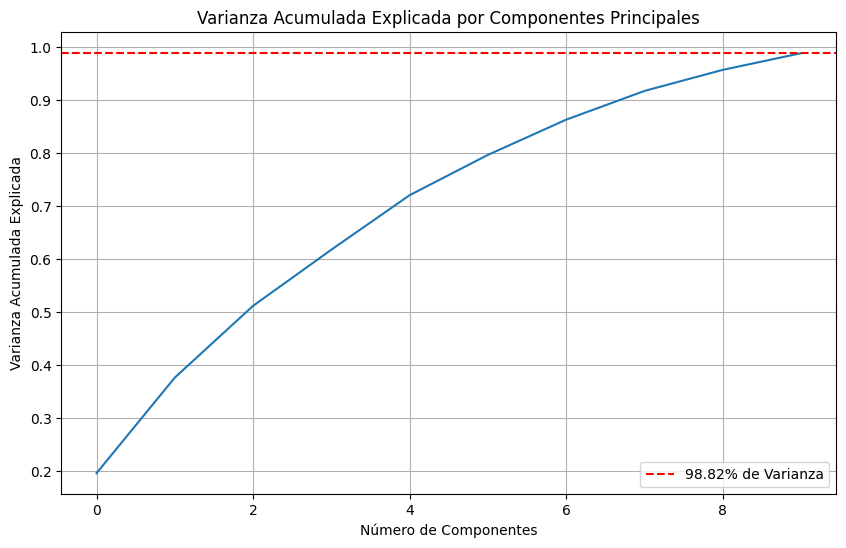

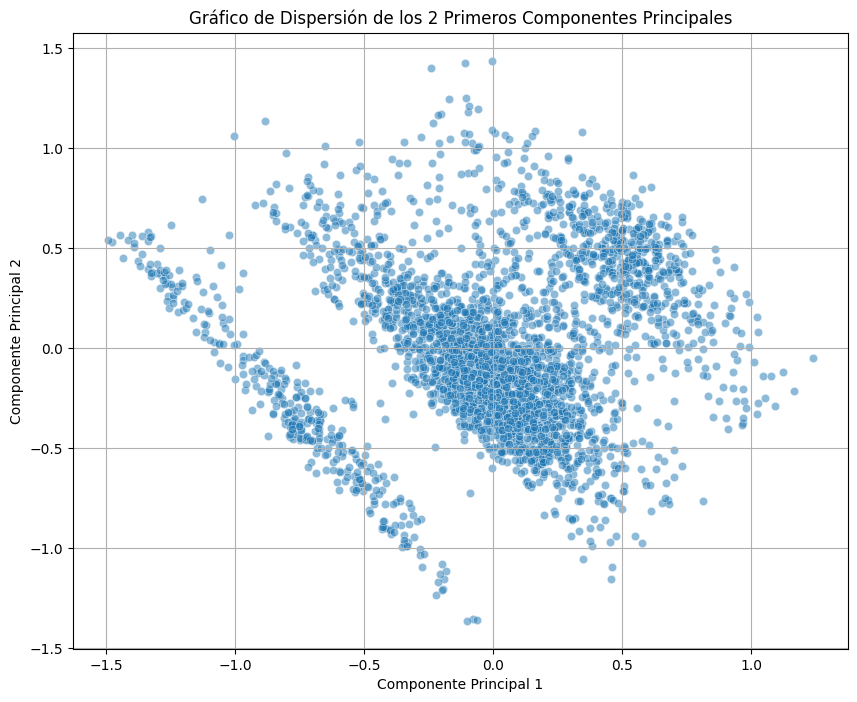

✅ Variable objetivo 'y' normalizada con éxito.
✅ Datos PCA convertidos a DataFrame.

✅ Datos y normalizador guardados con éxito para las siguientes fases del proyecto.


In [2]:
 # celda dos
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler  # 🚨 CAMBIO: Importar MinMaxScaler
from sklearn.decomposition import PCA
import joblib

# ==============================================================================
# --- 1. CARGA DE DATOS Y CONFIGURACIÓN ---
# ==============================================================================

# Definición de la variable global para la ruta de guardado
VERSION_SAVE_DIR = '/home/administrador/proyectos/backend-cafe-ia/progress/banano'
os.makedirs(VERSION_SAVE_DIR, exist_ok=True)

# Define las rutas completas a los archivos necesarios.
X_SCALED_PATH = os.path.join(VERSION_SAVE_DIR, 'X_scaled_pca.joblib')
Y_SCALED_PATH = os.path.join(VERSION_SAVE_DIR, 'y_scaled_pca.joblib')
Y_SCALER_PATH = os.path.join(VERSION_SAVE_DIR, 'y_scaler.joblib')
print(f"[{time.strftime('%H:%M:%S')}] Directorio de guardado para la versión 'pca' creado/verificado: {VERSION_SAVE_DIR}")

# 🚨 CORRECCIÓN: Se cambia la ruta de carga al archivo CSV correcto
DATA_CLEANED_PATH = os.path.join(VERSION_SAVE_DIR, 'df_agregado_procesado.csv')

try:
    # 🚨 CORRECCIÓN: Se usa pd.read_csv en lugar de pd.read_excel
    df_limpio = pd.read_csv(DATA_CLEANED_PATH)
    df_limpio.columns = df_limpio.columns.str.strip()
    print("✅ Archivo con datos procesados cargado con éxito.")
    print(f"Número total de filas iniciales: {len(df_limpio)}")
    
    print("\n--- Columnas disponibles después de la carga ---")
    print(df_limpio.columns.tolist())
    print(f"\nNúmero total de columnas: {len(df_limpio.columns)}")

except FileNotFoundError:
    print(f"❌ Error: No se encontró el archivo en la ruta '{DATA_CLEANED_PATH}'.")
    print("Por favor, asegúrate de ejecutar primero la celda de preprocesamiento.")
    raise

# ==============================================================================
# --- 2. PREPROCESAMIENTO: FILTRADO Y SEPARACIÓN ---
# ==============================================================================

# Eliminar la columna 'Fecha_completa' ya que no es numérica y no se necesita para PCA
df_limpio.drop(columns=['Fecha_completa'], inplace=True)

# Filtra el DataFrame para seleccionar solo las columnas numéricas
df_filtrado = df_limpio.select_dtypes(include=np.number)
df_filtrado = df_filtrado.dropna()

# Separar la variable objetivo 'Cantidad_total' del resto de las características
if 'Cantidad_total' not in df_filtrado.columns:
    print("❌ ERROR: La columna 'Cantidad_total' no se encuentra en el DataFrame numérico.")
    exit()

y = df_filtrado['Cantidad_total'].copy()
X = df_filtrado.drop(columns=['Cantidad_total']).copy()

# Alinear explícitamente X e y para garantizar que tengan el mismo número de filas
X, y = X.align(y, join='inner', axis=0)

print("\n--- Columnas numéricas seleccionadas para PCA ---")
print(X.columns.tolist())
print(f"\nNúmero de columnas numéricas: {len(X.columns)}")
print(f"\n✅ Variable objetivo 'Cantidad_total' separada con éxito. Longitud de X: {len(X)}, Longitud de y: {len(y)}")

# ==============================================================================
# --- 3. APLICACIÓN DE PCA, ESCALADO DE 'Y' Y VISUALIZACIÓN ---
# ==============================================================================

# 🚨 CAMBIO: Usar MinMaxScaler en lugar de StandardScaler
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
print("✅ Características normalizadas con éxito.")

# Aplicar PCA para retener el 95% de la varianza
pca = PCA(n_components=10)
principal_components = pca.fit_transform(X_scaled)

# 3. MOSTRAR EL NÚMERO DE CARACTERÍSTICAS FINALES
print(f"\nNúmero de características finales después de PCA: {pca.n_components_}")
print(f"Varianza explicada total por los componentes: {np.sum(pca.explained_variance_ratio_):.2%}")

# Gráfico 1: Varianza Acumulada Explicada
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada Explicada')
plt.title('Varianza Acumulada Explicada por Componentes Principales')
plt.grid(True)
plt.axhline(y=np.sum(pca.explained_variance_ratio_), color='r', linestyle='--', label=f'{np.sum(pca.explained_variance_ratio_):.2%} de Varianza')
plt.legend()
plt.savefig(os.path.join(VERSION_SAVE_DIR, 'pca_variance_plot.png'))
plt.show()

# Gráfico 2: Gráfico de Dispersión de los 2 Primeros Componentes
if pca.n_components_ >= 2:
    principal_df = pd.DataFrame(data=principal_components[:, 0:2], columns=['PC_1', 'PC_2'])
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PC_1', y='PC_2', data=principal_df, alpha=0.5)
    plt.title('Gráfico de Dispersión de los 2 Primeros Componentes Principales')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.grid(True)
    plt.savefig(os.path.join(VERSION_SAVE_DIR, 'pca_scatter_plot.png'))
    plt.show()
else:
    print("\n⚠️ ADVERTENCIA: No hay suficientes componentes principales (>=2) para crear el gráfico de dispersión.")

# ==============================================================================
# --- 4. NORMALIZACIÓN DE LA VARIABLE OBJETIVO Y GUARDADO ---
# ==============================================================================

# 🚨 CAMBIO: Usar MinMaxScaler en lugar de StandardScaler
scaler_y = MinMaxScaler()
y_scaled_np = scaler_y.fit_transform(y.values.reshape(-1, 1))
y_scaled_series = pd.Series(y_scaled_np.flatten(), index=y.index, name='Cantidad_total_scaled')
print("✅ Variable objetivo 'y' normalizada con éxito.")

# Convertir el array de PCA a un DataFrame para el guardado
X_scaled_df = pd.DataFrame(principal_components, columns=[f'PC_{i+1}' for i in range(pca.n_components_)])
print("✅ Datos PCA convertidos a DataFrame.")

# Validar que las longitudes sean idénticas antes de guardar
if len(X_scaled_df) != len(y_scaled_series):
    print("❌ ERROR CRÍTICO: Las longitudes de X y y no coinciden después de PCA y escalado. Revisar el preprocesamiento.")
    print(f"Longitud de X_scaled_df: {len(X_scaled_df)}, Longitud de y_scaled_series: {len(y_scaled_series)}")
    exit()

# Guardar los objetos y datos para su uso en las próximas celdas
try:
    joblib.dump(scaler_X, os.path.join(VERSION_SAVE_DIR, 'scaler_X.joblib'))
    joblib.dump(pca, os.path.join(VERSION_SAVE_DIR, 'pca_model.joblib'))
    joblib.dump(X_scaled_df, X_SCALED_PATH)
    joblib.dump(y_scaled_series, Y_SCALED_PATH)
    joblib.dump(scaler_y, Y_SCALER_PATH)
    print("\n✅ Datos y normalizador guardados con éxito para las siguientes fases del proyecto.")
except Exception as e:
    print(f"❌ ERROR: No se pudieron guardar los archivos. {e}")

[00:09:46] Directorio de guardado para la versión 'pca' creado/verificado: /home/administrador/proyectos/backend-cafe-ia/progress/banano
✅ Archivo con datos procesados cargado con éxito.
Número total de filas iniciales: 3276

--- Columnas disponibles después de la carga ---
['Fecha_completa', 'Cantidad_total', 'Numero_articulos_total', 'Valor_Flete_total', 'Valor_seguro_total', 'Valor_otros_total', 'Precio_Unitario_FOB_USD_Peso_Neto_promedio', 'Precio_Unitario_FOB_USD_Peso_Bruto_promedio', 'Precio_Unitario_FOB_USD_Cantidad_promedio', 'Precio_Unitario_FOB_COP_Peso_Neto_promedio', 'Precio_Unitario_FOB_COP_Peso_Bruto_promedio', 'Precio_Unitario_FOB_COP_Cantidad_promedio', 'dia_semana', 'mes', 'es_fin_de_semana', 'lag_1', 'lag_7', 'rolling_mean_7d', 'rolling_std_7d']

Número total de columnas: 19

--- Columnas numéricas seleccionadas para PCA ---
['Numero_articulos_total', 'Valor_Flete_total', 'Valor_seguro_total', 'Valor_otros_total', 'Precio_Unitario_FOB_USD_Peso_Neto_promedio', 'Precio_

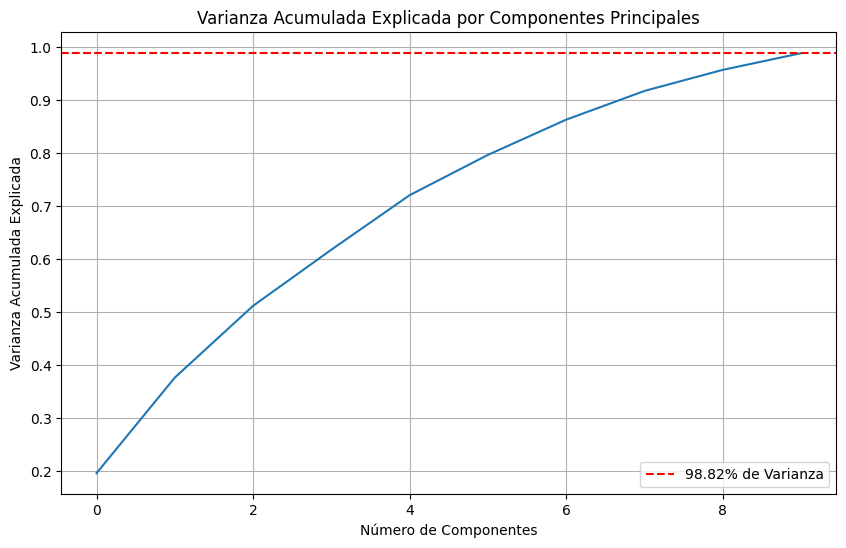

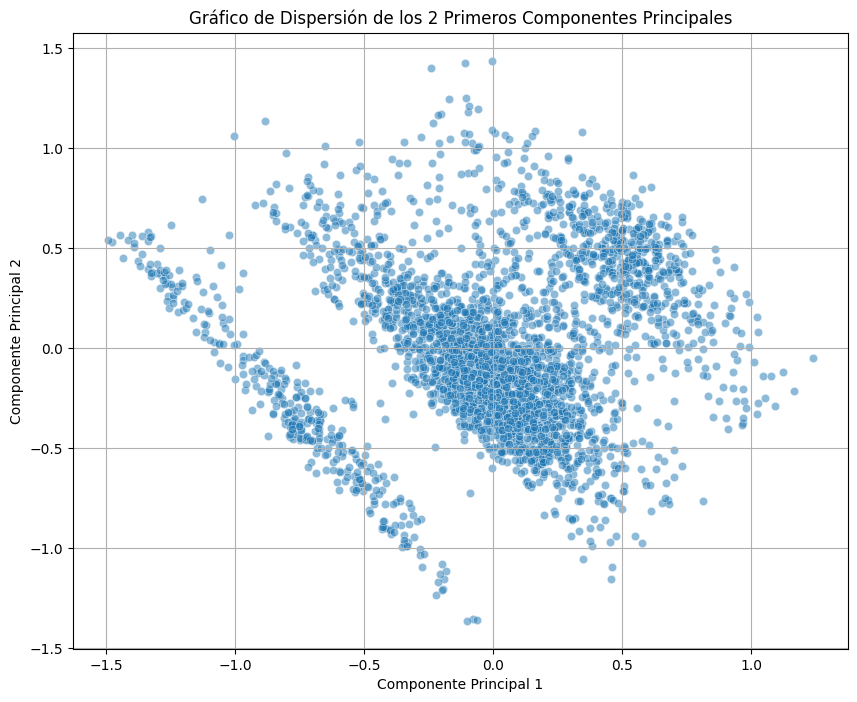


[00:09:47] Generando Matriz de Cargas para Interpretabilidad Económica.

--- Matriz de Cargas (Loadings) para Tesis ---
|                                             |   PC_1 |   PC_2 |   PC_3 |   PC_4 |   PC_5 |   PC_6 |   PC_7 |   PC_8 |   PC_9 |   PC_10 |
|:--------------------------------------------|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|--------:|
| Numero_articulos_total                      |  0.305 |  0.099 | -0.080 |  0.350 |  0.170 | -0.356 |  0.739 |  0.031 | -0.109 |  -0.223 |
| Valor_Flete_total                           |  0.509 |  0.574 |  0.543 | -0.196 | -0.209 |  0.003 | -0.072 | -0.153 |  0.073 |  -0.012 |
| Valor_seguro_total                          | -0.000 | -0.000 | -0.000 |  0.000 |  0.000 |  0.000 |  0.000 |  0.000 |  0.000 |  -0.000 |
| Valor_otros_total                           | -0.000 |  0.000 |  0.000 | -0.000 |  0.000 | -0.000 |  0.000 |  0.000 |  0.000 |   0.000 |
| Precio_Unitario_FOB_USD_Peso_Neto_promedio 

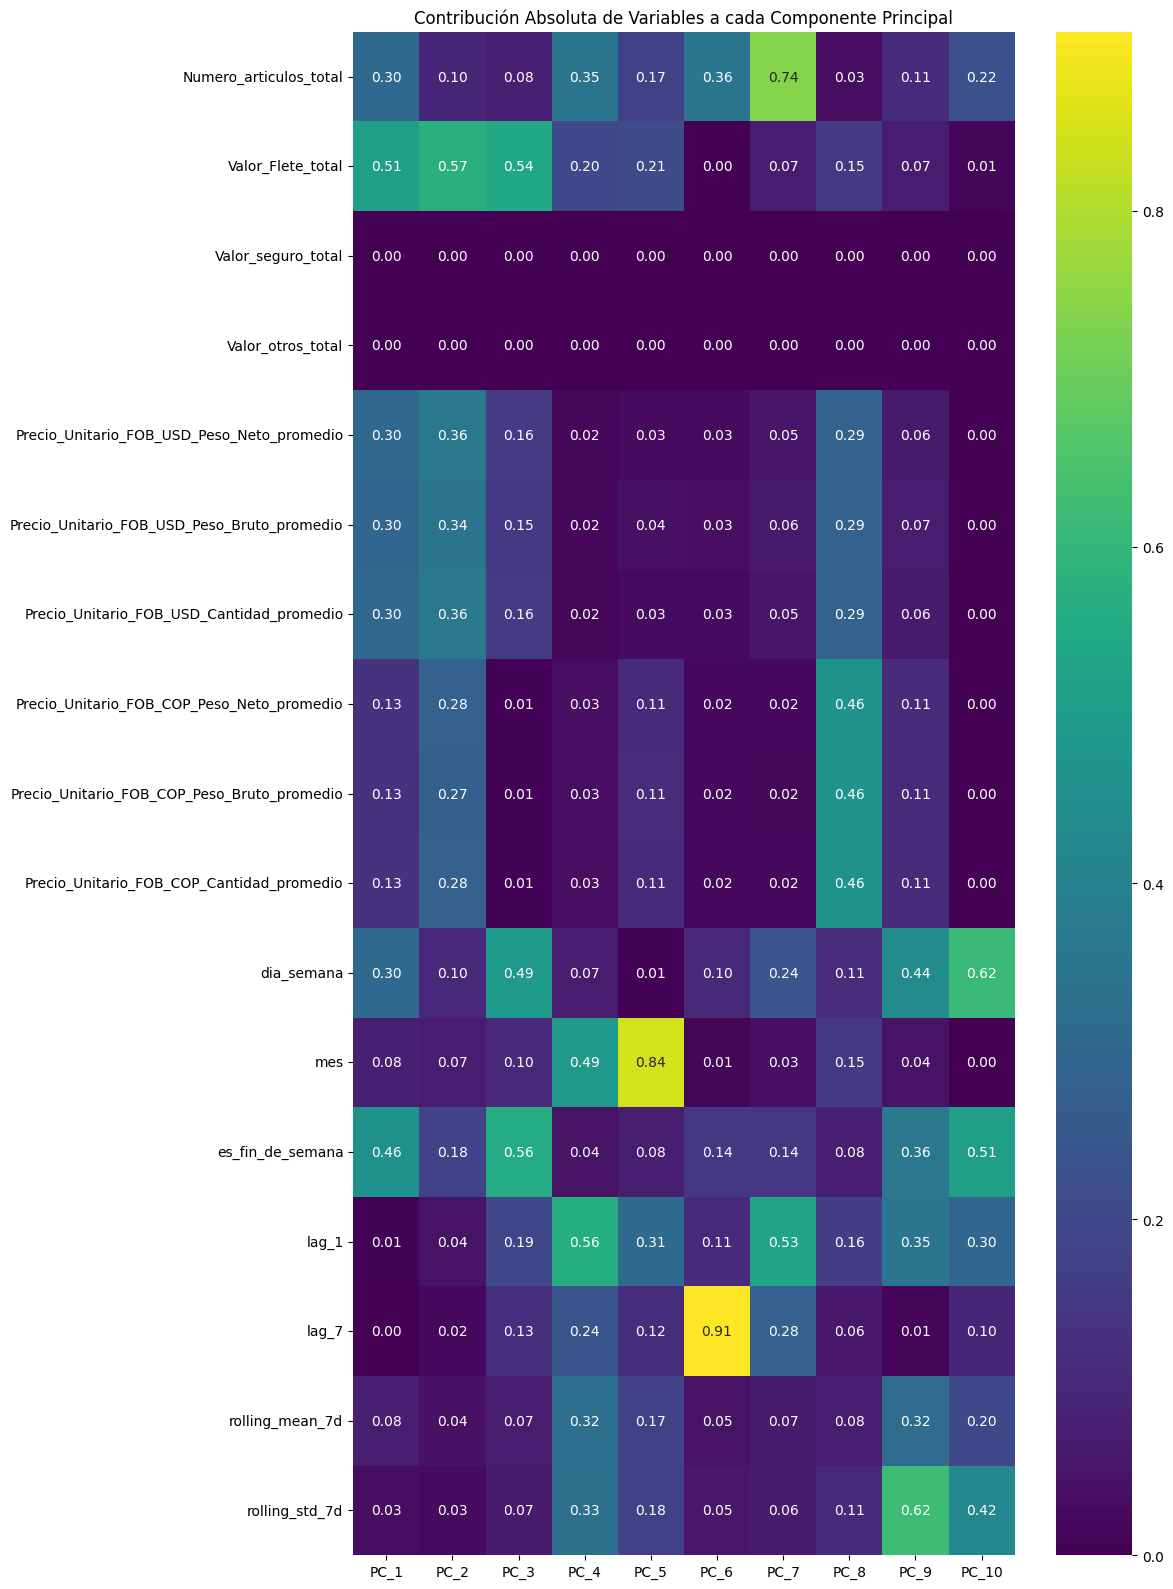


✅ Variable objetivo 'y' normalizada con éxito.
✅ Datos PCA convertidos a DataFrame.

✅ Datos y normalizador guardados con éxito para las siguientes fases del proyecto.


In [3]:
#celda 2a
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import joblib

# ==============================================================================
# --- 1. CARGA DE DATOS Y CONFIGURACIÓN ---
# ==============================================================================

# 🚨 AJUSTE PARA BANANO: Se cambia la ruta de guardado
VERSION_SAVE_DIR = '/home/administrador/proyectos/backend-cafe-ia/progress/banano'
os.makedirs(VERSION_SAVE_DIR, exist_ok=True)

# Define las rutas completas a los archivos necesarios.
X_SCALED_PATH = os.path.join(VERSION_SAVE_DIR, 'X_scaled_pca.joblib')
Y_SCALED_PATH = os.path.join(VERSION_SAVE_DIR, 'y_scaled_pca.joblib')
Y_SCALER_PATH = os.path.join(VERSION_SAVE_DIR, 'y_scaler.joblib')
print(f"[{time.strftime('%H:%M:%S')}] Directorio de guardado para la versión 'pca' creado/verificado: {VERSION_SAVE_DIR}")

# Se mantiene la ruta al archivo CSV
DATA_CLEANED_PATH = os.path.join(VERSION_SAVE_DIR, 'df_agregado_procesado.csv')

try:
    df_limpio = pd.read_csv(DATA_CLEANED_PATH)
    df_limpio.columns = df_limpio.columns.str.strip()
    print("✅ Archivo con datos procesados cargado con éxito.")
    print(f"Número total de filas iniciales: {len(df_limpio)}")
    
    print("\n--- Columnas disponibles después de la carga ---")
    print(df_limpio.columns.tolist())
    print(f"\nNúmero total de columnas: {len(df_limpio.columns)}")

except FileNotFoundError:
    print(f"❌ Error: No se encontró el archivo en la ruta '{DATA_CLEANED_PATH}'.")
    print("Por favor, asegúrate de ejecutar primero la celda de preprocesamiento.")
    raise

# ==============================================================================
# --- 2. PREPROCESAMIENTO: FILTRADO Y SEPARACIÓN ---
# ==============================================================================

# Eliminar la columna 'Fecha_completa' ya que no es numérica y no se necesita para PCA
df_limpio.drop(columns=['Fecha_completa'], inplace=True, errors='ignore')

# Filtra el DataFrame para seleccionar solo las columnas numéricas
df_filtrado = df_limpio.select_dtypes(include=np.number)
df_filtrado = df_filtrado.dropna()

# Separar la variable objetivo 'Cantidad_total' del resto de las características
if 'Cantidad_total' not in df_filtrado.columns:
    print("❌ ERROR: La columna 'Cantidad_total' no se encuentra en el DataFrame numérico.")
    exit()

y = df_filtrado['Cantidad_total'].copy()
X = df_filtrado.drop(columns=['Cantidad_total']).copy()

# 🚨 ADICIÓN: Definir explícitamente las columnas usadas para PCA para la matriz de cargas.
columnas_pca = X.columns.tolist() 

# Alinear explícitamente X e y para garantizar que tengan el mismo número de filas
X, y = X.align(y, join='inner', axis=0)

print("\n--- Columnas numéricas seleccionadas para PCA ---")
print(X.columns.tolist())
print(f"\nNúmero de columnas numéricas: {len(X.columns)}")
print(f"\n✅ Variable objetivo 'Cantidad_total' separada con éxito. Longitud de X: {len(X)}, Longitud de y: {len(y)}")

# ==============================================================================
# --- 3. APLICACIÓN DE PCA, ESCALADO DE 'X' Y VISUALIZACIÓN ---
# ==============================================================================

# ESCALADO DE X: Usar MinMaxScaler
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
print("✅ Características normalizadas con éxito.")

# Aplicar PCA para retener 10 componentes
pca = PCA(n_components=10)
principal_components = pca.fit_transform(X_scaled)

# MOSTRAR RESULTADOS DEL PCA
print(f"\nNúmero de características finales después de PCA: {pca.n_components_}")
print(f"Varianza explicada total por los componentes: {np.sum(pca.explained_variance_ratio_):.2%}")

# Gráfico 1: Varianza Acumulada Explicada
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada Explicada')
plt.title('Varianza Acumulada Explicada por Componentes Principales')
plt.grid(True)
plt.axhline(y=np.sum(pca.explained_variance_ratio_), color='r', linestyle='--', label=f'{np.sum(pca.explained_variance_ratio_):.2%} de Varianza')
plt.legend()
plt.savefig(os.path.join(VERSION_SAVE_DIR, 'pca_variance_plot.png'))
plt.show()

# Gráfico 2: Gráfico de Dispersión de los 2 Primeros Componentes
if pca.n_components_ >= 2:
    principal_df = pd.DataFrame(data=principal_components[:, 0:2], columns=['PC_1', 'PC_2'])
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PC_1', y='PC_2', data=principal_df, alpha=0.5)
    plt.title('Gráfico de Dispersión de los 2 Primeros Componentes Principales')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.grid(True)
    plt.savefig(os.path.join(VERSION_SAVE_DIR, 'pca_scatter_plot.png'))
    plt.show()
else:
    print("\n⚠️ ADVERTENCIA: No hay suficientes componentes principales (>=2) para crear el gráfico de dispersión.")


# ==============================================================================
# --- 4. INTERPRETABILIDAD (MATRIZ DE CARGAS) Y GUARDADO ---
# ==============================================================================

print(f"\n[{time.strftime('%H:%M:%S')}] Generando Matriz de Cargas para Interpretabilidad Económica.")

# 4.1. Crear la Matriz de Cargas (Loadings)
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=[f'PC_{i+1}' for i in range(pca.n_components_)], 
    index=columnas_pca # Se usa la lista de columnas definida en la sección 2
)

# 4.2. Visualizar y Guardar la Matriz de Cargas
print("\n--- Matriz de Cargas (Loadings) para Tesis ---")
# Imprimir solo una muestra para no saturar la salida
print(loadings.head(10).to_markdown(floatfmt=".3f")) 
loadings.to_csv(os.path.join(VERSION_SAVE_DIR, 'pca_loadings_matrix.csv'))
print(f"✅ Matriz de cargas guardada en: pca_loadings_matrix.csv")

# 4.3. Visualizar el heatmap de cargas (Absoluto)
plt.figure(figsize=(12, 16))
sns.heatmap(loadings.abs(), annot=True, cmap='viridis', fmt=".2f", cbar=True)
plt.title('Contribución Absoluta de Variables a cada Componente Principal')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(VERSION_SAVE_DIR, 'pca_loadings_heatmap_abs.png'))
plt.show()

# 4.4. NORMALIZACIÓN DE LA VARIABLE OBJETIVO Y GUARDADO

# Usar MinMaxScaler para 'y'
scaler_y = MinMaxScaler()
y_scaled_np = scaler_y.fit_transform(y.values.reshape(-1, 1))
y_scaled_series = pd.Series(y_scaled_np.flatten(), index=y.index, name='Cantidad_total_scaled')
print("\n✅ Variable objetivo 'y' normalizada con éxito.")

# Convertir el array de PCA a un DataFrame para el guardado
X_scaled_df = pd.DataFrame(principal_components, columns=[f'PC_{i+1}' for i in range(pca.n_components_)])
print("✅ Datos PCA convertidos a DataFrame.")

# Validar longitudes y guardar los objetos del modelo (PCA, escaladores y datos)
if len(X_scaled_df) != len(y_scaled_series):
    print("❌ ERROR CRÍTICO: Las longitudes de X y y no coinciden después de PCA y escalado. Revisar el preprocesamiento.")
    exit()

try:
    joblib.dump(scaler_X, os.path.join(VERSION_SAVE_DIR, 'scaler_X.joblib'))
    joblib.dump(pca, os.path.join(VERSION_SAVE_DIR, 'pca_model.joblib'))
    joblib.dump(X_scaled_df, X_SCALED_PATH)
    joblib.dump(y_scaled_series, Y_SCALED_PATH)
    joblib.dump(scaler_y, Y_SCALER_PATH)
    print("\n✅ Datos y normalizador guardados con éxito para las siguientes fases del proyecto.")
except Exception as e:
    print(f"❌ ERROR: No se pudieron guardar los archivos. {e}")




In [4]:
# celda 3
import pandas as pd
import numpy as np
import time
import os
import json
from datetime import datetime
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from xgboost import XGBRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import clone
import joblib

# --- CONFIGURACIÓN DE RUTAS ---
VERSION_SAVE_DIR = '/home/administrador/proyectos/backend-cafe-ia/progress/banano'
X_SCALED_PATH = os.path.join(VERSION_SAVE_DIR, 'X_scaled_pca.joblib')
Y_SCALED_PATH = os.path.join(VERSION_SAVE_DIR, 'y_scaled_pca.joblib')
Y_SCALER_PATH = os.path.join(VERSION_SAVE_DIR, 'y_scaler.joblib')

BASE_MODEL_NAMES_PATH = os.path.join(VERSION_SAVE_DIR, 'base_model_names.joblib')
TREE_OOF_METRICS_PATH = os.path.join(VERSION_SAVE_DIR, 'tree_oof_metrics.json')
BEST_TREE_NAME_PATH = os.path.join(VERSION_SAVE_DIR, 'best_tree_model_name.txt')

# Definir la función para la métrica SMAPE
def calculate_smape(y_true, y_pred):
    """
    Calcula el Error Porcentual Absoluto Simétrico Medio (SMAPE).
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / np.where(denominator != 0, denominator, 1)) * 100

def calculate_mape_np(y_true, y_pred):
    """
    Calcula el Error Porcentual Absoluto Medio (MAPE) para arrays de NumPy.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# --- Inicio del código modificado ---

def split_data_and_prepare_for_tuning(X_scaled, y_scaled):
    """
    Divide los datos en conjuntos de entrenamiento y prueba.
    """
    print("\n--- Paso 3.1: División del Conjunto de Datos ---")
    print("Se utiliza una división cronológica del 80% para entrenamiento y 20% para prueba.")

    # División final para entrenamiento de modelos base y meta-modelo (80% train, 20% test)
    split_point_final = int(len(X_scaled) * 0.8)
    X_train_final, X_test_final = X_scaled.iloc[:split_point_final], X_scaled.iloc[split_point_final:]
    y_train_final, y_test_final = y_scaled.iloc[:split_point_final], y_scaled.iloc[split_point_final:]

    # Renombrar las columnas para evitar errores de KeyError en la fase de Stacking
    original_feature_names = [f'feature_{i}' for i in range(X_train_final.shape[1])]
    X_train_final.columns = original_feature_names
    X_test_final.columns = original_feature_names

    print(f"\n--- DEBUGGING DE LA DIVISIÓN DE DATOS ---")
    print(f"Tamaño total de los datos procesados: {len(X_scaled)} muestras")
    print(f"Dimensiones de X_train_final: {X_train_final.shape}")
    print(f"Dimensiones de X_test_final: {X_test_final.shape}")
    print("--- FIN DEBUGGING DE LA DIVISIÓN DE DATOS ---")
    
    return X_train_final, X_test_final, y_train_final, y_test_final

def optimize_base_models(models_for_tuning, X_train_final, y_train_final):
    """
    Realiza la optimización de hiperparámetros para cada modelo base y devuelve
    el diccionario de modelos con los mejores parámetros.
    """
    print(f"\n[{time.strftime('%H:%M:%S')}] --- Paso 3.2: Optimizando Hiperparámetros de Modelos Base ---")

    # Crear un scorer personalizado para SMAPE (usando el valor negativo para optimización)
    smape_scorer = make_scorer(calculate_smape, greater_is_better=False)

    # Definir los espacios de búsqueda para cada modelo
    param_grids = {
        'XGBoost': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7],
        },
        'Bagging': {
            'n_estimators': [10, 20, 50],
            'max_samples': [0.8, 1.0],
        },
        'RandomForest': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 6, 9],
            'min_samples_leaf': [10, 20],
        },
        'AdaBoost': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.1, 0.5, 1.0],
        },
        'GradientBoosting': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7],
        },
    }

    # Configurar la validación cruzada de series de tiempo
    ts_cv = TimeSeriesSplit(n_splits=5)
    
    optimized_models = {}

    for model_name, model_instance in models_for_tuning.items():
        print(f"\n[{time.strftime('%H:%M:%S')}] -> Optimizando: {model_name}")

        param_grid = param_grids.get(model_name)
        if param_grid is None:
            print(f"⚠️ ADVERTENCIA: No se encontró un espacio de búsqueda para {model_name}. Usando parámetros por defecto.")
            optimized_models[model_name] = model_instance
            continue

        grid_search = GridSearchCV(
            estimator=model_instance,
            param_grid=param_grid,
            scoring=smape_scorer,
            cv=ts_cv,
            n_jobs=-1,
            verbose=1,
        )

        try:
            # Flatten 'y' para que GridSearchCV no tenga problemas
            grid_search.fit(X_train_final, y_train_final.values.ravel())
            
            print(f"✅ Búsqueda de hiperparámetros finalizada para {model_name}.")
            print(f"    Mejores parámetros: {grid_search.best_params_}")
            print(f"    Mejor SMAPE en CV: {-grid_search.best_score_:.2f}%")
            
            # Almacenar el modelo optimizado
            optimized_models[model_name] = grid_search.best_estimator_

        except Exception as e:
            print(f"❌ ERROR al optimizar {model_name}: {e}")
            # Si falla la optimización, se usa el modelo por defecto
            optimized_models[model_name] = model_instance

    print(f"\n[{time.strftime('%H:%M:%S')}] ✅ Optimización de hiperparámetros finalizada.")
    return optimized_models


def generate_oof_and_test_predictions_and_metrics(models_for_tuning, X_train_final, y_train_final, X_test_final):
    """
    Genera predicciones OOF y de prueba para cada modelo usando TimeSeriesSplit.
    """
    print(f"\n[{time.strftime('%H:%M:%S')}] --- Paso 3.3: Generando predicciones OOF y de prueba ---")
    
    n_splits = 5
    ts_split = TimeSeriesSplit(n_splits=n_splits)
    
    tree_oof_metrics_individual = {}
    trained_tree_model_names = []

    for model_name, model_instance in models_for_tuning.items():
        print(f"\n[{time.strftime('%H:%M:%S')}] -> Procesando modelo: {model_name}...")

        oof_preds = np.zeros(X_train_final.shape[0])
        test_preds_folds = []

        for fold, (train_idx, val_idx) in enumerate(ts_split.split(X_train_final)):
            print(f"[{time.strftime('%H:%M:%S')}] Entrenando Fold {fold+1}/{n_splits}...")

            X_train_fold, X_val_fold = X_train_final.iloc[train_idx], X_train_final.iloc[val_idx]
            y_train_fold, y_val_fold = y_train_final.iloc[train_idx], y_train_final.iloc[val_idx]

            # Nuevas líneas de depuración que revisan los datos
            print(f"DEBUG_FOLD: {model_name} - Fold {fold+1}")
            print(f"    Shape de y_train_fold: {y_train_fold.shape}")
            print(f"    Shape de y_val_fold: {y_val_fold.shape}")
            
            # Verificamos si los valores de y_train_fold son todos cero
            if (y_train_fold.values == 0).all():
                print(f"    ⚠️ ADVERTENCIA: Todos los valores en y_train_fold son CERO para este fold. El modelo no podrá aprender.")
                continue
            
            model = clone(model_instance)
            model.fit(X_train_fold, y_train_fold.values.ravel())

            oof_preds[val_idx] = model.predict(X_val_fold)
            test_preds_folds.append(model.predict(X_test_final))
        
        # Mostramos los primeros 10 valores de la parte del array que SÍ se llenó.
        # El primer split de validación empieza en el índice 573.
        first_val_idx = next(ts_split.split(X_train_final))[1][0]
        print(f"DEBUG: Primeras 10 predicciones OOF (a partir del índice {first_val_idx}) para {model_name}: {oof_preds[first_val_idx:first_val_idx+10]}")

        # Aquí verificamos si la lista de test_preds_folds está vacía antes de promediar
        if test_preds_folds:
            test_preds = np.mean(test_preds_folds, axis=0)
            # Guardar las predicciones OOF y de prueba para el modelo
            joblib.dump(oof_preds, os.path.join(VERSION_SAVE_DIR, f'oof_preds_tree_{model_name}.joblib'))
            joblib.dump(test_preds, os.path.join(VERSION_SAVE_DIR, f'test_preds_tree_{model_name}.joblib'))
            print(f"[{time.strftime('%H:%M:%S')}] ✅ Predicciones OOF y de prueba generadas y guardadas para '{model_name}'.")
        else:
            print(f"[{time.strftime('%H:%M:%S')}] ❌ ERROR: No se pudieron generar predicciones de prueba para '{model_name}'.")
            continue


        oof_preds_series = pd.Series(oof_preds, index=X_train_final.index)
        if (oof_preds_series == 0).all():
            print(f"[{time.strftime('%H:%M:%S')}] ❌ ERROR: Todas las predicciones OOF para '{model_name}' son cero. Saltando.")
            continue
            
        try:
            # Asegurar que las predicciones sean no negativas antes de desescalar
            oof_preds_series_non_negative = np.maximum(0, oof_preds_series.values)

            # Desescalar valores reales y predichos para el cálculo de métricas
            y_true_oof_descaled = scaler_y.inverse_transform(y_train_final.values.reshape(-1, 1)).flatten()
            oof_preds_individual_descaled = scaler_y.inverse_transform(oof_preds_series_non_negative.reshape(-1, 1)).flatten()

            # Calcular métricas con los datos desescalados
            r2_oof_value = r2_score(y_true_oof_descaled, oof_preds_individual_descaled)
            smape_oof_value = calculate_smape(y_true_oof_descaled, oof_preds_individual_descaled)
            rmse_oof_value = np.sqrt(mean_squared_error(y_true_oof_descaled, oof_preds_individual_descaled))
            mae_oof_value = mean_absolute_error(y_true_oof_descaled, oof_preds_individual_descaled)
            mape_oof_value = calculate_mape_np(y_true_oof_descaled, oof_preds_individual_descaled)
            mse_oof_value = mean_squared_error(y_true_oof_descaled, oof_preds_individual_descaled)

            tree_oof_metrics_individual[model_name] = {
                'r2_oof_descaled': float(r2_oof_value),
                'smape_oof_descaled': float(smape_oof_value),
                'rmse_oof_descaled': float(rmse_oof_value),
                'mae_oof_descaled': float(mae_oof_value),
                'mape_oof_descaled': float(mape_oof_value),
                'mse_oof_descaled': float(mse_oof_value),
            }
            print(f"[{time.strftime('%H:%M:%S')}] {model_name} OOF Metrics (Descaled) - R2: {r2_oof_value:.4f}, SMAPE: {smape_oof_value:.4f}%, RMSE: {rmse_oof_value:.4f}")
        except Exception as e:
            print(f"[{time.strftime('%H:%M:%S')}] ❌ ERROR al calcular métricas OOF para {model_name}: {e}")

        trained_tree_model_names.append(model_name)

    joblib.dump({'tree_model_names': trained_tree_model_names}, BASE_MODEL_NAMES_PATH)
    print(f"\n[{time.strftime('%H:%M:%S')}] ✅ Nombres de modelos de árbol entrenados guardados.")
    
    return tree_oof_metrics_individual

# -----------------------------------------------------------------------------
# FUNCIONES FALTANTES AGREGADAS
# -----------------------------------------------------------------------------

def select_and_save_best_model(tree_oof_metrics_individual):
    """
    Selecciona el mejor modelo de árbol basándose en una métrica y lo guarda.
    """
    print(f"\n[{time.strftime('%H:%M:%S')}] --- Paso 4: Seleccionando y guardando el mejor modelo de árbol ---")
    if not tree_oof_metrics_individual:
        print("⚠️ ADVERTENCIA: No hay métricas OOF para seleccionar el mejor modelo.")
        return

    # Se encuentra el mejor modelo basado en el SMAPE más bajo
    best_model_name = min(tree_oof_metrics_individual, key=lambda k: tree_oof_metrics_individual[k]['smape_oof_descaled'])
    print(f"✅ Mejor modelo de árbol seleccionado: {best_model_name}")
    
    # ✅ Se añade la lógica para guardar el nombre del mejor modelo en un archivo de texto.
    BEST_TREE_NAME_PATH = os.path.join(VERSION_SAVE_DIR, 'best_tree_model_name.txt')
    try:
        with open(BEST_TREE_NAME_PATH, 'w') as f:
            f.write(best_model_name)
        print(f"✅ Nombre del mejor modelo de árbol guardado en: {BEST_TREE_NAME_PATH}")
    except Exception as e:
        print(f"❌ ERROR al guardar el nombre del mejor modelo de árbol: {e}")
    
def train_and_save_final_models(models_for_tuning, X_train_final, y_train_final):
    """
    Entrena los modelos finales con todo el conjunto de entrenamiento y los guarda.
    """
    # Se corrige la llamada a time.now() por datetime.now()
    print(f"\n[{datetime.now().strftime('%H:%M:%S')}] --- Paso 5: Entrenando y guardando modelos finales ---")
    for model_name, model_instance in models_for_tuning.items():
        print(f"-> Entrenando modelo final: {model_name}")
        
        try:
            model = clone(model_instance)
            model.fit(X_train_final, y_train_final.values.ravel())
            # La ruta de guardado es: final_model_{model_name}.joblib
            joblib.dump(model, os.path.join(VERSION_SAVE_DIR, f'final_model_{model_name}.joblib'))
            print(f"[{datetime.now().strftime('%H:%M:%S')}] ✅ Modelo final '{model_name}' entrenado y guardado.")
        except Exception as e:
            print(f"[{datetime.now().strftime('%H:%M:%S')}] ❌ ERROR al entrenar y guardar el modelo final '{model_name}': {e}")
    
    print("✅ Modelos finales entrenados y guardados.")

# -----------------------------------------------------------------------------
# BUCLE PRINCIPAL DE EJECUCIÓN (CON CORRECCIÓN DE GUARDADO)
# -----------------------------------------------------------------------------

if __name__ == "__main__":
    
    from datetime import datetime

    try:
        print("\n--- FASE 3: Desarrollo y Entrenamiento del Modelo ---")
        print("[03:20:02] Cargando datos escalados y PCA...")

        # Cargar los datos escalados y PCA
        X_scaled = pd.DataFrame(joblib.load(X_SCALED_PATH))
        y_scaled = pd.DataFrame(joblib.load(Y_SCALED_PATH))
        scaler_y = joblib.load(Y_SCALER_PATH)

        if X_scaled.empty or y_scaled.empty or scaler_y is None:
            raise RuntimeError("Variables de datos o escalador no definidos. Por favor, verifica los archivos joblib.")
            
        # Paso 1: División de datos
        X_train_final, X_test_final, y_train_final, y_test_final = split_data_and_prepare_for_tuning(X_scaled, y_scaled)
        
        # ==============================================================================
        # 🚨 CORRECCIÓN CLAVE: GUARDAR CONJUNTOS DE PRUEBA EN DISCO 🚨
        # Este bloque soluciona el error 'No such file or directory' en Celda 3a
        # ==============================================================================
        X_TEST_PATH = os.path.join(VERSION_SAVE_DIR, 'X_test_final.joblib')
        Y_TEST_PATH = os.path.join(VERSION_SAVE_DIR, 'y_test_final.joblib')

        try:
            joblib.dump(X_test_final, X_TEST_PATH)
            joblib.dump(y_test_final, Y_TEST_PATH)
            print(f"[{time.strftime('%H:%M:%S')}] ✅ Conjuntos de prueba X_test y y_test guardados para evaluación final.")
        except Exception as e:
            print(f"[{time.strftime('%H:%M:%S')}] ❌ ERROR al guardar conjuntos de prueba: {e}")
        # ==============================================================================

        # Definición de los modelos a entrenar
        models_for_tuning = {
            'XGBoost': XGBRegressor(random_state=42, n_jobs=4),
            'Bagging': BaggingRegressor(
                estimator=DecisionTreeRegressor(max_depth=6, min_samples_leaf=10, random_state=42),
                random_state=42, n_jobs=4
            ),
            'RandomForest': RandomForestRegressor(random_state=42, n_jobs=4),
            'AdaBoost': AdaBoostRegressor(random_state=42),
            'GradientBoosting': GradientBoostingRegressor(random_state=42)
        }

        # Paso 2: Optimizacion de modelos base
        models_for_tuning = optimize_base_models(models_for_tuning, X_train_final, y_train_final)
        
        # Paso 3: Generación de predicciones OOF y métricas
        tree_oof_metrics_individual = generate_oof_and_test_predictions_and_metrics(
            models_for_tuning, X_train_final, y_train_final, X_test_final
        )
        
        # Guardar las métricas OOF consolidadas
        TREE_OOF_METRICS_PATH = os.path.join(VERSION_SAVE_DIR, 'tree_oof_metrics.json')
        print(f"[{time.strftime('%H:%M:%S')}] Guardando métricas OOF consolidadas...")
        if tree_oof_metrics_individual:
            with open(TREE_OOF_METRICS_PATH, 'w') as f:
                json.dump(tree_oof_metrics_individual, f, indent=4)
            print(f"[{time.strftime('%H:%M:%S')}] ✅ Métricas OOF de modelos guardadas en: {TREE_OOF_METRICS_PATH}")

        # Paso 4: Selección y guardado del mejor modelo de árbol
        select_and_save_best_model(tree_oof_metrics_individual)

        # Paso 5: Entrenamiento y guardado individual de modelos
        train_and_save_final_models(models_for_tuning, X_train_final, y_train_final)

        print("\n--- FASE 3: COMPLETADA EXITOSAMENTE ---")

    except Exception as e:
        print(f"\n--- FASE 3: FALLO CRÍTICO ---")
        print(f"❌ Error al ejecutar la Fase 3: {e}")
        print("Asegúrate de que `X_scaled`, `y_scaled` y `scaler_y` estén definidos y no vacíos.")


--- FASE 3: Desarrollo y Entrenamiento del Modelo ---
[03:20:02] Cargando datos escalados y PCA...

--- Paso 3.1: División del Conjunto de Datos ---
Se utiliza una división cronológica del 80% para entrenamiento y 20% para prueba.

--- DEBUGGING DE LA DIVISIÓN DE DATOS ---
Tamaño total de los datos procesados: 3276 muestras
Dimensiones de X_train_final: (2620, 10)
Dimensiones de X_test_final: (656, 10)
--- FIN DEBUGGING DE LA DIVISIÓN DE DATOS ---
[00:10:08] ✅ Conjuntos de prueba X_test y y_test guardados para evaluación final.

[00:10:08] --- Paso 3.2: Optimizando Hiperparámetros de Modelos Base ---

[00:10:08] -> Optimizando: XGBoost
Fitting 5 folds for each of 27 candidates, totalling 135 fits
✅ Búsqueda de hiperparámetros finalizada para XGBoost.
    Mejores parámetros: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
    Mejor SMAPE en CV: 62.36%

[00:10:23] -> Optimizando: Bagging
Fitting 5 folds for each of 6 candidates, totalling 30 fits
✅ Búsqueda de hiperparámetr

In [5]:
#celda 3a
#==============================================================================
# --- PASO 2.5: EVALUACIÓN FINAL DEL MEJOR MODELO DE ÁRBOL (XGBOOST) ---
# ==============================================================================

# NOTA: Asegúrese de que las importaciones (joblib, numpy, métricas)
# estén definidas en celdas previas.

from joblib import load
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# --- DEFINICIÓN DE RUTAS (Adaptar a su entorno) ---
VERSION_SAVE_DIR = os.path.join(os.path.expanduser('~'), 'proyectos', 'backend-cafe-ia', 'progress', 'banano')
FINAL_MODEL_PATH = os.path.join(VERSION_SAVE_DIR, 'final_model_XGBoost.joblib') 
X_TEST_PATH = os.path.join(VERSION_SAVE_DIR, 'X_test_final.joblib')
Y_TEST_PATH = os.path.join(VERSION_SAVE_DIR, 'y_test_final.joblib')
Y_SCALER_PATH = os.path.join(VERSION_SAVE_DIR, 'y_scaler.joblib')

# Función SMAPE (debe estar definida o importada)
def calculate_smape_np(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / np.where(denominator != 0, denominator, 1)) * 100

print(f"\n[{time.strftime('%H:%M:%S')}] --- INICIANDO EVALUACIÓN FINAL DE PRUEBA (XGBoost) ---")

try:
    # 1. Cargar el modelo, datos y escalador
    final_model = load(FINAL_MODEL_PATH)
    X_test_scaled = load(X_TEST_PATH)
    y_test_scaled = load(Y_TEST_PATH)
    y_scaler = load(Y_SCALER_PATH)

    # 2. Hacer predicciones en el conjunto de prueba ESCALADO
    y_pred_test_scaled = final_model.predict(X_test_scaled)

    # 3. Desescalar predicciones y valores reales
    # Nota: Los modelos de sklearn suelen producir arrays 1D, por eso el reshape podría variar
    y_pred_test_descaled = y_scaler.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()
    y_true_test_descaled = y_scaler.inverse_transform(y_test_scaled.values.reshape(-1, 1)).flatten()

    # 4. Post-procesamiento
    y_pred_test_descaled_final = np.maximum(0, y_pred_test_descaled)

    # 5. Calcular las métricas finales (¡Estos son los valores de la Tabla 16!)
    R2_FINAL = r2_score(y_true_test_descaled, y_pred_test_descaled_final)
    RMSE_FINAL = np.sqrt(mean_squared_error(y_true_test_descaled, y_pred_test_descaled_final))
    MAE_FINAL = mean_absolute_error(y_true_test_descaled, y_pred_test_descaled_final)
    SMAPE_FINAL = calculate_smape_np(y_true_test_descaled, y_pred_test_descaled_final)

    # 6. Imprimir los resultados
    print("\n===================================================================")
    print("=== RESULTADO FINAL DE PRUEBA DESESCALADA: XGBoost (TABLA 16) ===")
    print("===================================================================")
    print(f"  R2:         {R2_FINAL:.3f}")
    print(f"  RMSE:       {RMSE_FINAL:,.2f}")
    print(f"  MAE:        {MAE_FINAL:,.2f}")
    print(f"  SMAPE (%):  {SMAPE_FINAL:.2f}%")
    print("===================================================================\n")

except Exception as e:
    print(f"❌ ERROR durante la evaluación final de XGBoost: {e}")


[00:12:48] --- INICIANDO EVALUACIÓN FINAL DE PRUEBA (XGBoost) ---

=== RESULTADO FINAL DE PRUEBA DESESCALADA: XGBoost (TABLA 16) ===
  R2:         0.508
  RMSE:       4,158,574.39
  MAE:        3,146,226.42
  SMAPE (%):  67.26%



In [6]:
# celda 4
# ==============================================================================
# --- PASO DE PREPARACIÓN DE DATOS PARA REDES NEURONALES RECURRENTES (RNN) ---
# ==============================================================================
# Este bloque de código prepara y guarda los datos para la fase 3.3.
# Se asume que las rutas de archivo (como DF_PROCESSED_PATH) ya están definidas.

try:
    print("="*80)
    print("--- Paso de Preparación de Datos para RNN ---")
    print("="*80 + "\n")
    print(f"[{datetime.now().strftime('%H:%M:%S')}] Iniciando preparación de datos...")

    # --- Carga y Verificación de Datos ---
    # Cargamos el DataFrame completo escalado y la variable objetivo
    # Se eliminan las cargas de 'df' y 'scaler_y' si no se usan, para evitar errores de referencia
    X_scaled = joblib.load(X_SCALED_PATH)
    y_scaled = joblib.load(Y_SCALED_PATH)
    
    # Se carga el escalador de 'y' para futuras desescalaciones
    scaler_y = joblib.load(Y_SCALER_PATH)

    print(f"[{datetime.now().strftime('%H:%M:%S')}] ✅ Datos escalados cargados.")
    print(f"[{datetime.now().strftime('%H:%M:%S')}] X_scaled shape: {X_scaled.shape}, y_scaled shape: {y_scaled.shape}")

    # Asegurarse de que los datos sean arrays de NumPy
    X_scaled_np = X_scaled.values if isinstance(X_scaled, pd.DataFrame) else X_scaled
    y_scaled_np = y_scaled.values.ravel() if isinstance(y_scaled, (pd.Series, pd.DataFrame)) else y_scaled.ravel()

    # División de datos en conjuntos de entrenamiento y prueba (final)
    split_point_final = int(len(X_scaled_np) * 0.8)
    X_train_final, X_test_final = X_scaled_np[:split_point_final], X_scaled_np[split_point_final:]
    y_train_final, y_test_final = y_scaled_np[:split_point_final], y_scaled_np[split_point_final:]
    
    print(f"[{datetime.now().strftime('%H:%M:%S')}] ✅ División 80/20 completada.")
    print(f"[{datetime.now().strftime('%H:%M:%S')}] X_train_final shape: {X_train_final.shape}")
    print(f"[{datetime.now().strftime('%H:%M:%S')}] X_test_final shape: {X_test_final.shape}")

    # --- Reforma de los datos para la arquitectura RNN (3D) ---
    # Las RNNs necesitan datos en 3 dimensiones: (muestras, pasos_de_tiempo, características)
    # En este caso, cada "muestra" es un paso de tiempo único, por lo que `sequence_length` es 1.
    lstm_sequence_length_actual = 1
    num_features = X_train_final.shape[1]
    
    X_rnn_final = X_train_final.reshape(X_train_final.shape[0], lstm_sequence_length_actual, num_features)
    X_test_rnn_final = X_test_final.reshape(X_test_final.shape[0], lstm_sequence_length_actual, num_features)
    
    print(f"[{datetime.now().strftime('%H:%M:%S')}] ✅ Datos reformados para RNNs.")
    print(f"[{datetime.now().strftime('%H:%M:%S')}] Forma 3D de X_rnn_final: {X_rnn_final.shape}")
    print(f"[{datetime.now().strftime('%H:%M:%S')}] Forma 3D de X_test_rnn_final: {X_test_rnn_final.shape}")

    # --- Guardado de la longitud de la secuencia para uso posterior ---
    lstm_config = {'sequence_length': lstm_sequence_length_actual}
    lstm_config_path = os.path.join(VERSION_SAVE_DIR, 'lstm_sequence_length.json')
    with open(lstm_config_path, 'w') as f:
        json.dump(lstm_config, f, indent=4)
    print(f"[{datetime.now().strftime('%H:%M:%S')}] ✅ Longitud de secuencia RNN ({lstm_sequence_length_actual}) guardada en {lstm_config_path}.")
    
    # --- Guardado de los datos pre-divididos y reformados ---
    # Guardamos los conjuntos finales para que la siguiente celda pueda usarlos directamente.
    joblib.dump(X_rnn_final, os.path.join(VERSION_SAVE_DIR, 'X_rnn_final.joblib'))
    joblib.dump(y_train_final, os.path.join(VERSION_SAVE_DIR, 'y_train_final.joblib'))
    joblib.dump(X_test_rnn_final, os.path.join(VERSION_SAVE_DIR, 'X_test_rnn_final.joblib'))
    joblib.dump(y_test_final, os.path.join(VERSION_SAVE_DIR, 'y_test_final.joblib'))
    
    print(f"[{datetime.now().strftime('%H:%M:%S')}] ✅ Datos preparados y guardados en la carpeta '{VERSION_SAVE_DIR}'.")
    print("="*80 + "\n")
    
except FileNotFoundError as e:
    print(f"[{datetime.now().strftime('%H:%M:%S')}] ❌ Error: No se pudieron cargar los archivos necesarios. Asegúrate de que las fases anteriores se ejecutaron correctamente: {e}")
except Exception as e:
    print(f"[{datetime.now().strftime('%H:%M:%S')}] ❌ Ocurrió un error inesperado durante la preparación de datos: {e}")

--- Paso de Preparación de Datos para RNN ---

[00:12:53] Iniciando preparación de datos...
[00:12:53] ✅ Datos escalados cargados.
[00:12:53] X_scaled shape: (3276, 10), y_scaled shape: (3276,)
[00:12:53] ✅ División 80/20 completada.
[00:12:53] X_train_final shape: (2620, 10)
[00:12:53] X_test_final shape: (656, 10)
[00:12:53] ✅ Datos reformados para RNNs.
[00:12:53] Forma 3D de X_rnn_final: (2620, 1, 10)
[00:12:53] Forma 3D de X_test_rnn_final: (656, 1, 10)
[00:12:53] ✅ Longitud de secuencia RNN (1) guardada en /home/administrador/proyectos/backend-cafe-ia/progress/banano/lstm_sequence_length.json.
[00:12:53] ✅ Datos preparados y guardados en la carpeta '/home/administrador/proyectos/backend-cafe-ia/progress/banano'.



In [7]:
# celda 5  ejecutar
import json
import time
import joblib
import os
import numpy as np
import pandas as pd
from datetime import datetime
import gc # Importa el recolector de basura
from joblib import dump, load
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Input, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import register_keras_serializable

import keras_tuner as kt
from keras_tuner import RandomSearch

# ==============================================================================
# --- DEFINICIÓN DE FUNCIONES AUXILIARES FALTANTES ---
# ==============================================================================

def calculate_mape_np(y_true, y_pred):
    """
    Calcula el Error Porcentual Absoluto Medio (MAPE) en NumPy.
    Maneja el caso de y_true = 0 para evitar la división por cero.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Reemplazar ceros en y_true con un valor pequeño (epsilon)
    # para evitar la división por cero
    non_zero_mask = y_true != 0
    if not np.any(non_zero_mask):
        return np.nan # No se puede calcular si todos los valores reales son cero
    
    mape = np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
    return mape

def calculate_smape_np(y_true, y_pred):
    """
    Calcula el Error Porcentual Absoluto Simétrico Medio (SMAPE) en NumPy.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    # Maneja el caso de y_true = 0 y y_pred = 0 para evitar la división por cero
    smape_value = np.where(denominator == 0, 0, numerator / denominator)
    return np.mean(smape_value) * 100

# Asegúrate de que esta función esté definida antes de que se use.
@register_keras_serializable()
def smape_keras(y_true, y_pred):
    """Métrica SMAPE personalizada para Keras."""
    epsilon = 0.1
    summ = tf.maximum(tf.abs(y_true) + tf.abs(y_pred) + epsilon, 0.5)
    smape = tf.reduce_mean(2 * tf.abs(y_pred - y_true) / summ) * 100
    return smape

# ==============================================================================
# --- PARÁMETROS DE OPTIMIZACIÓN MEJORADOS ---
# ==============================================================================
N_SPLITS_FINAL = 5
MAX_TRIALS_TUNER_FOLD = 20
EPOCHS_TUNER_SEARCH = 75
EPOCHS_FOLD_TRAINING = 150
EPOCHS_FINAL_TRAINING = 350

PATIENCE_TUNER = 20
PATIENCE_FINAL_MODEL = 30

# Se cambia la métrica a optimizar directamente en el código
METRIC_TO_OPTIMIZE_KERAS = 'val_smape_keras' 
METRIC_TO_OPTIMIZE_OOF = 'smape_oof_descaled'

# ==============================================================================
# --- INICIO DEL CÓDIGO DE LA FASE 3.3 (RNNs con Keras Tuner) ---
# ==============================================================================
try:
    print("\n" + "="*80)
    print("--- Paso 3.3: Diseño y Entrenamiento de la Arquitectura de la RNN (con Keras Tuner) ---")
    print("="*80 + "\n")
    print("En esta sección se entrenarán y evaluarán múltiples arquitecturas RNN usando Keras Tuner.")
    print(f"[{datetime.now().strftime('%H:%M:%S')}] Iniciando la fase 3.3 de RNNs. Cargando datos pre-divididos...")

    # --- Carga de Datos Pre-divididos y Reformados ---
    VERSION_SAVE_DIR = '/home/administrador/proyectos/backend-cafe-ia/progress/banano'
    Y_SCALER_PATH = os.path.join(VERSION_SAVE_DIR, 'y_scaler.joblib')
    BEST_RNN_NAME_PATH = os.path.join(VERSION_SAVE_DIR, 'best_rnn_model_name.txt')
    X_SCALED_PATH = os.path.join(VERSION_SAVE_DIR, 'X_scaled_pca.joblib')
    Y_SCALED_PATH = os.path.join(VERSION_SAVE_DIR, 'y_scaled_pca.joblib')
    X_rnn_final = joblib.load(os.path.join(VERSION_SAVE_DIR, 'X_rnn_final.joblib'))
    y_train_final = joblib.load(os.path.join(VERSION_SAVE_DIR, 'y_train_final.joblib'))
    X_test_rnn_final = joblib.load(os.path.join(VERSION_SAVE_DIR, 'X_test_rnn_final.joblib'))
    y_test_final = joblib.load(os.path.join(VERSION_SAVE_DIR, 'y_test_final.joblib'))
    RNN_OOF_METRICS_PATH = os.path.join(VERSION_SAVE_DIR, 'rnn_oof_metrics.json')

    
    # También cargamos el escalador y el tscv_final que se usarán en el bucle
    scaler_y = joblib.load(Y_SCALER_PATH)
    tscv_final = TimeSeriesSplit(n_splits=N_SPLITS_FINAL)
    
    print(f"[{datetime.now().strftime('%H:%M:%S')}] ✅ Datos pre-divididos cargados correctamente.")
    print(f"[{datetime.now().strftime('%H:%M:%S')}] X_rnn_final shape: {X_rnn_final.shape}")
    print(f"[{datetime.now().strftime('%H:%M:%S')}] X_test_rnn_final shape: {X_test_rnn_final.shape}")

except FileNotFoundError as e:
    print(f"[{datetime.now().strftime('%H:%M:%S')}] ❌ Error: No se pudieron cargar los archivos necesarios para la Fase 3.3: {e}")
    raise
except Exception as e:
    print(f"[{datetime.now().strftime('%H:%M:%S')}] ❌ Ocurrió un error inesperado al cargar los datos para la Fase 3.3: {e}")
    raise
    
if (X_rnn_final.size > 0 and y_train_final.size > 0 and
    'tscv_final' in locals() and tscv_final is not None and
    scaler_y is not None):

    # --- DEFINICIÓN DE LA FUNCIÓN PARA Keras Tuner (Modelo Builder) ---
    def build_rnn_model(hp, input_shape, rnn_type):
        model = Sequential()
        model.add(Input(shape=input_shape))
        
        num_rnn_layers = hp.Int('num_rnn_layers', min_value=1, max_value=3, step=1)
        for i in range(num_rnn_layers):
            hp_units = hp.Int(f'units_layer_{i}', min_value=64, max_value=512, step=64)
            hp_bidirectional = hp.Boolean(f'bidirectional_layer_{i}')
            return_sequences = (i < num_rnn_layers - 1)
            
            rnn_layer = None
            if rnn_type == 'SimpleRNN': rnn_layer = SimpleRNN(units=hp_units, return_sequences=return_sequences)
            elif rnn_type == 'LSTM': rnn_layer = LSTM(units=hp_units, return_sequences=return_sequences)
            elif rnn_type == 'GRU': rnn_layer = GRU(units=hp_units, return_sequences=return_sequences)
            
            if hp_bidirectional: model.add(Bidirectional(rnn_layer))
            else: model.add(rnn_layer)
            
            hp_dropout_rate = hp.Float(f'dropout_layer_{i}', min_value=0.1, max_value=0.6, step=0.1)
            if hp_dropout_rate > 0.0: model.add(Dropout(hp_dropout_rate))
            
        model.add(Dense(1, activation='linear'))
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 5e-3, 1e-3, 5e-4, 1e-4])
        # CAMBIO CLAVE: Se añade 'smape_keras' como métrica para la compilación del modelo
        model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mse', metrics=[smape_keras, 'mae'])
        return model

    rnn_model_configs = {
        'SimpleRNN': {'type': 'SimpleRNN'},
        'LSTM': {'type': 'LSTM'},
        'GRU': {'type': 'GRU'},
        'BiLSTM': {'type': 'LSTM'},
        'BiGRU': {'type': 'GRU'},
    }

    print("\nIniciando búsqueda de hiperparámetros y entrenamiento para modelos de Redes Neuronales...")

    # CAMBIO: Usamos 'val_smape_keras' como el monitor de EarlyStopping para la búsqueda del tuner
    early_stopping_rnn_tuner = EarlyStopping(monitor=METRIC_TO_OPTIMIZE_KERAS, patience=PATIENCE_TUNER, restore_best_weights=True, verbose=0, mode='min')
    early_stopping_final = EarlyStopping(monitor='loss', patience=PATIENCE_FINAL_MODEL, restore_best_weights=True, verbose=0, mode='min')
    
    rnn_oof_metrics = {}
    RNN_OOF_METRICS_PATH = os.path.join(VERSION_SAVE_DIR, 'rnn_oof_metrics.json')

    if os.path.exists(RNN_OOF_METRICS_PATH):
        try:
            with open(RNN_OOF_METRICS_PATH, 'r') as f:
                rnn_oof_metrics = json.load(f)
            print(f"[{datetime.now().strftime('%H:%M:%S')}] ✅ Métricas OOF de RNNs previamente guardadas cargadas.")
        except (json.JSONDecodeError, Exception) as e:
            print(f"[{datetime.now().strftime('%H:%M:%S')}] ❌ Error al cargar métricas OOF de RNNs: {e}. Se re-calcularán.")
    
    oof_preds_rnn = np.zeros((len(y_train_final), len(rnn_model_configs)))
    test_preds_rnn = np.zeros((len(y_test_final), len(rnn_model_configs)))
    
    for i, (name, rnn_config) in enumerate(rnn_model_configs.items()):
        
        print(f"\n[{datetime.now().strftime('%H:%M:%S')}] --- Procesando modelo RNN: {name} ---")
        
        model_oof_path = os.path.join(VERSION_SAVE_DIR, f'oof_preds_rnn_{name}.joblib')
        model_test_path = os.path.join(VERSION_SAVE_DIR, f'test_preds_rnn_{name}.joblib')
        rnn_model_final_save_path = os.path.join(VERSION_SAVE_DIR, f'final_rnn_model_{name}.keras')
        
        needs_retraining = not (
            os.path.exists(model_oof_path) and 
            os.path.exists(model_test_path) and 
            os.path.exists(rnn_model_final_save_path) and
            name in rnn_oof_metrics and
            rnn_oof_metrics[name].get('n_splits_used') == N_SPLITS_FINAL
        )

        if not needs_retraining:
            try:
                loaded_oof_preds = joblib.load(model_oof_path)
                if loaded_oof_preds.shape[0] != len(y_train_final) or (name in rnn_oof_metrics and rnn_oof_metrics[name].get('n_splits_used') != N_SPLITS_FINAL):
                    print(f"[{datetime.now().strftime('%H:%M:%S')}] --- ADVERTENCIA para {name}: Los datos han cambiado o el número de folds es diferente. Forzando re-entrenamiento. ---")
                    needs_retraining = True
                else:
                    oof_preds_rnn[:, i] = loaded_oof_preds
                    test_preds_rnn[:, i] = joblib.load(model_test_path)
                    print(f"[{datetime.now().strftime('%H:%M:%S')}] --- Saltando el tuning y entrenamiento de {name}: Predicciones, modelo final y métricas ya guardadas. ---")
            except Exception as e:
                print(f"[{datetime.now().strftime('%H:%M:%S')}] --- ERROR al cargar artefactos para {name}: {e}. Forzando re-entrenamiento. ---")
                needs_retraining = True

        if needs_retraining:
            oof_predictions_for_this_rnn_model = np.zeros(len(y_train_final))
            fold_test_predictions_for_this_rnn_model = []
            best_hp_overall = None
            best_smape_overall = float('inf')

            for fold, (train_index, val_index) in enumerate(tscv_final.split(X_rnn_final, y_train_final)):
                print(f"  [{datetime.now().strftime('%H:%M:%S')}] Iniciando Tuning para {name} en Fold {fold+1}/{N_SPLITS_FINAL}...")
                
                tf.keras.backend.clear_session()
                gc.collect()

                X_train_fold_rnn, X_val_fold_rnn = X_rnn_final[train_index], X_rnn_final[val_index]
                y_train_fold_rnn, y_val_fold_rnn = y_train_final[train_index], y_train_final[val_index]
                
                tuner_log_dir = os.path.join(VERSION_SAVE_DIR, 'keras_tuner_logs', name, f'fold_{fold}')
                os.makedirs(tuner_log_dir, exist_ok=True)
                
                tuner = kt.RandomSearch(
                    lambda hp: build_rnn_model(hp, input_shape=X_rnn_final.shape[1:], rnn_type=rnn_config['type']),
                    # CAMBIO CLAVE: Se usa kt.Objective para especificar la dirección
                    objective=kt.Objective(METRIC_TO_OPTIMIZE_KERAS, direction="min"),
                    max_trials=MAX_TRIALS_TUNER_FOLD, executions_per_trial=1,
                    directory=tuner_log_dir, project_name=f'rnn_tuning_fold_{name}', overwrite=True
                )
                tuner.search(X_train_fold_rnn, y_train_fold_rnn, epochs=EPOCHS_TUNER_SEARCH, batch_size=32, validation_data=(X_val_fold_rnn, y_val_fold_rnn), callbacks=[early_stopping_rnn_tuner], verbose=0)
                
                # Obtener el mejor modelo del fold y su SMAPE
                best_hp_for_fold = tuner.get_best_hyperparameters(num_trials=1)[0]
                best_model_in_fold = tuner.hypermodel.build(best_hp_for_fold)
                
                fold_model_path = os.path.join(VERSION_SAVE_DIR, f'rnn_model_{name}_fold{fold}.keras')
                # CAMBIO: El checkpoint también debe monitorear 'val_smape_keras'
                model_checkpoint_callback = ModelCheckpoint(filepath=fold_model_path, monitor=METRIC_TO_OPTIMIZE_KERAS, save_best_only=True, mode='min', verbose=0)
                
                best_model_in_fold.fit(X_train_fold_rnn, y_train_fold_rnn, epochs=EPOCHS_FOLD_TRAINING, batch_size=32, validation_data=(X_val_fold_rnn, y_val_fold_rnn), callbacks=[early_stopping_rnn_tuner, model_checkpoint_callback], verbose=0)
                
                best_model_in_fold = load_model(fold_model_path, custom_objects={'smape_keras': smape_keras})
                
                # Evaluar el mejor modelo del fold para obtener el SMAPE final de ese fold
                metrics_fold = best_model_in_fold.evaluate(X_val_fold_rnn, y_val_fold_rnn, verbose=0)
                smape_fold = metrics_fold[1] # SMAPE es el segundo valor en la lista de métricas
                
                if smape_fold < best_smape_overall:
                    best_smape_overall = smape_fold
                    best_hp_overall = best_hp_for_fold
                
                oof_predictions_for_this_rnn_model[val_index] = best_model_in_fold.predict(X_val_fold_rnn, verbose=0).ravel()
                fold_test_predictions_for_this_rnn_model.append(best_model_in_fold.predict(X_test_rnn_final, verbose=0).ravel())
                
                del tuner, best_model_in_fold
                gc.collect()
                tf.keras.backend.clear_session()
            
            oof_preds_rnn[:, i] = oof_predictions_for_this_rnn_model
            test_preds_rnn[:, i] = np.mean(fold_test_predictions_for_this_rnn_model, axis=0)

            # CAMBIO: Ahora solo entrenamos un modelo final usando los mejores hiperparámetros del CV
            print(f"\n[{datetime.now().strftime('%H:%M:%S')}] -> Entrenando modelo final para {name} con los mejores hiperparámetros...")
            
            if best_hp_overall:
                final_rnn_model = build_rnn_model(best_hp_overall, input_shape=X_rnn_final.shape[1:], rnn_type=rnn_config['type'])
            else:
                # Si no se encontró ningún HP, construimos un modelo por defecto
                final_hp = kt.HyperParameters()
                final_hp.Int('num_rnn_layers', min_value=1, max_value=3, step=1)
                final_hp.Int('units_layer_0', min_value=128, max_value=256, step=64)
                final_hp.Float('dropout_layer_0', min_value=0.2, max_value=0.4, step=0.1)
                final_hp.Choice('learning_rate', values=[1e-3])
                final_rnn_model = build_rnn_model(final_hp, input_shape=X_rnn_final.shape[1:], rnn_type=rnn_config['type'])

            final_rnn_model_checkpoint = ModelCheckpoint(filepath=rnn_model_final_save_path, monitor='loss', save_best_only=True, mode='min', verbose=0)
            final_rnn_model.fit(X_rnn_final, y_train_final, epochs=EPOCHS_FINAL_TRAINING, batch_size=32, callbacks=[early_stopping_final, final_rnn_model_checkpoint], verbose=0)
            
            print(f"[{datetime.now().strftime('%H:%M:%S')}] ✅ Modelo final {name} entrenado y guardado en {rnn_model_final_save_path}.")
            
            joblib.dump(oof_preds_rnn[:, i], model_oof_path)
            joblib.dump(test_preds_rnn[:, i], model_test_path)
            print(f"[{datetime.now().strftime('%H:%M:%S')}] ✅ Predicciones OOF y Test para {name} guardadas.")
            
            del final_rnn_model
            gc.collect()
            tf.keras.backend.clear_session()
            
            y_true_oof_descaled = scaler_y.inverse_transform(y_train_final.reshape(-1, 1)).flatten()
            oof_preds_individual_descaled = scaler_y.inverse_transform(oof_preds_rnn[:, i].reshape(-1, 1)).flatten()
            oof_preds_individual_descaled_non_negative = np.maximum(0, oof_preds_individual_descaled)
            
            metrics = {
                'r2_oof_descaled': r2_score(y_true_oof_descaled, oof_preds_individual_descaled_non_negative),
                'smape_oof_descaled': calculate_smape_np(y_true_oof_descaled, oof_preds_individual_descaled_non_negative),
                'mape_oof_descaled': calculate_mape_np(y_true_oof_descaled, oof_preds_individual_descaled_non_negative),
                'rmse_oof_descaled': np.sqrt(mean_squared_error(y_true_oof_descaled, oof_preds_individual_descaled_non_negative)),
                'mae_oof_descaled': mean_absolute_error(y_true_oof_descaled, oof_preds_individual_descaled_non_negative),
                'mse_oof_descaled': mean_squared_error(y_true_oof_descaled, oof_preds_individual_descaled_non_negative),
                'n_splits_used': N_SPLITS_FINAL
            }

            rnn_oof_metrics[name] = {k: float(v) for k, v in metrics.items()}
            
            with open(RNN_OOF_METRICS_PATH, 'w') as f:
                json.dump(rnn_oof_metrics, f, indent=4)
                
            print(f"--- Métricas OOF para {name} (sobre datos DESESCALADOS):")
            for metric_name, value in metrics.items():
                if metric_name != 'n_splits_used': print(f"  {metric_name}: {value:.4f}")
            print("-" * 30)
            
    print(f"\n[{datetime.now().strftime('%H:%M:%S')}] Identificando el mejor modelo RNN de la lista entrenada...")
    best_rnn_model_name = None
    best_metric_value = float('inf')
    
    if rnn_oof_metrics:
        for name, metrics in rnn_oof_metrics.items():
            current_metric_value = metrics.get(METRIC_TO_OPTIMIZE_OOF)
            if current_metric_value is not None and current_metric_value < best_metric_value:
                best_metric_value = current_metric_value
                best_rnn_model_name = name

    if best_rnn_model_name and best_metric_value is not None:
        with open(BEST_RNN_NAME_PATH, 'w') as f: f.write(best_rnn_model_name)
        print(f"[{datetime.now().strftime('%H:%M:%S')}] ✅ El mejor modelo RNN es: '{best_rnn_model_name}' con {METRIC_TO_OPTIMIZE_OOF}: {best_metric_value:.4f}")
        print(f"[{datetime.now().strftime('%H:%M:%S')}] El nombre del mejor modelo RNN se ha guardado en: {BEST_RNN_NAME_PATH}")
    else:
        print(f"[{datetime.now().strftime('%H:%M:%S')}] ADVERTENCIA: No se pudo determinar el mejor modelo RNN.")
    
else:
    print(f"[{datetime.now().strftime('%H:%M:%S')}] La fase 3.3 de RNNs no se pudo ejecutar debido a la falta de datos.")

2025-10-15 00:13:00.682943: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-15 00:13:00.749752: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-15 00:13:02.564308: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.



--- Paso 3.3: Diseño y Entrenamiento de la Arquitectura de la RNN (con Keras Tuner) ---

En esta sección se entrenarán y evaluarán múltiples arquitecturas RNN usando Keras Tuner.
[00:13:02] Iniciando la fase 3.3 de RNNs. Cargando datos pre-divididos...
[00:13:02] ✅ Datos pre-divididos cargados correctamente.
[00:13:02] X_rnn_final shape: (2620, 1, 10)
[00:13:02] X_test_rnn_final shape: (656, 1, 10)

Iniciando búsqueda de hiperparámetros y entrenamiento para modelos de Redes Neuronales...
[00:13:02] ✅ Métricas OOF de RNNs previamente guardadas cargadas.

[00:13:02] --- Procesando modelo RNN: SimpleRNN ---
[00:13:02] --- Saltando el tuning y entrenamiento de SimpleRNN: Predicciones, modelo final y métricas ya guardadas. ---

[00:13:02] --- Procesando modelo RNN: LSTM ---
[00:13:02] --- Saltando el tuning y entrenamiento de LSTM: Predicciones, modelo final y métricas ya guardadas. ---

[00:13:02] --- Procesando modelo RNN: GRU ---
[00:13:02] --- Saltando el tuning y entrenamiento de GRU:

In [8]:
# celda 6
# ==============================================================================
# --- IMPORTACIONES NECESARIAS PARA MOSTRAR LOS RESULTADOS ---
# ==============================================================================
import os
import json
from datetime import datetime

# ==============================================================================
# --- CONFIGURACIÓN DE RUTAS ---
# ==============================================================================
BASE_DIR = os.path.join(os.path.expanduser('~'), 'proyectos', 'backend-cafe-ia', 'progress', 'banano')
VERSION_SAVE_DIR = BASE_DIR

TREE_OOF_METRICS_PATH = os.path.join(VERSION_SAVE_DIR, 'tree_oof_metrics.json')
RNN_OOF_METRICS_PATH = os.path.join(VERSION_SAVE_DIR, 'rnn_oof_metrics.json')



# ==============================================================================
# --- FUNCIÓN PARA MOSTRAR MÉTRICAS ---
# ==============================================================================
def display_metrics(model_type, metrics_path):
    """
    Carga y muestra las métricas de rendimiento de los modelos desde un archivo JSON.
    """
    try:
        with open(metrics_path, 'r') as f:
            metrics = json.load(f)
        
        print(f"\nResultados de Modelos {model_type} (Métricas OOF):")
        
        # Iterar sobre cada modelo en el JSON
        for model_name, model_metrics in metrics.items():
            print(f"\n--- Métricas OOF para Modelo {model_type}: {model_name} ---")
            
            # Formatear e imprimir cada métrica
            for metric_name, value in model_metrics.items():
                if metric_name == 'n_splits_used':
                    print(f"  Número de Folds Usados: {value}")
                else:
                    # Usar formato específico para porcentajes y valores numéricos
                    if "smape" in metric_name.lower() or "mape" in metric_name.lower():
                        print(f"  {metric_name}: {value:.4f}%")
                    else:
                        print(f"  {metric_name}: {value:.4f}")
            print("-" * 30)
    
    except FileNotFoundError:
        print(f"[{datetime.now().strftime('%H:%M:%S')}] ❌ Archivo de métricas no encontrado: {metrics_path}")
    except json.JSONDecodeError:
        print(f"[{datetime.now().strftime('%H:%M:%S')}] ❌ Error: El archivo {metrics_path} no es un JSON válido.")
    except Exception as e:
        print(f"[{datetime.now().strftime('%H:%M:%S')}] ❌ Ocurrió un error al procesar las métricas: {e}")

# ==============================================================================
# --- EJECUTAR LA VISUALIZACIÓN ---
# ==============================================================================
print("=" * 80)
print("--- CONSOLIDADO DE MÉTRICAS DE TODOS LOS MODELOS ---")
print("=" * 80)

# Mostrar las métricas de los modelos de Árboles
display_metrics("de Árbol", TREE_OOF_METRICS_PATH)

# Mostrar las métricas de los modelos RNN
display_metrics("RNN", RNN_OOF_METRICS_PATH)

print("\n" + "=" * 80)
print("--- CONSOLIDADO DE MÉTRICAS COMPLETADO ---")
print("=" * 80)

--- CONSOLIDADO DE MÉTRICAS DE TODOS LOS MODELOS ---

Resultados de Modelos de Árbol (Métricas OOF):

--- Métricas OOF para Modelo de Árbol: XGBoost ---
  r2_oof_descaled: 0.2049
  smape_oof_descaled: 85.4582%
  rmse_oof_descaled: 5017356.6495
  mae_oof_descaled: 3538570.6677
  mape_oof_descaled: 4229.3967%
  mse_oof_descaled: 25173867747935.2383
------------------------------

--- Métricas OOF para Modelo de Árbol: Bagging ---
  r2_oof_descaled: 0.1718
  smape_oof_descaled: 86.4379%
  rmse_oof_descaled: 5120956.7075
  mae_oof_descaled: 3623233.3614
  mape_oof_descaled: 6385.3315%
  mse_oof_descaled: 26224197600564.7188
------------------------------

--- Métricas OOF para Modelo de Árbol: RandomForest ---
  r2_oof_descaled: 0.1905
  smape_oof_descaled: 85.8804%
  rmse_oof_descaled: 5062655.3259
  mae_oof_descaled: 3581186.6803
  mape_oof_descaled: 5967.9555%
  mse_oof_descaled: 25630478949122.7305
------------------------------

--- Métricas OOF para Modelo de Árbol: AdaBoost ---
  r2

In [9]:
#celda 6a
# ==============================================================================
# --- PASO 3.4: EVALUACIÓN FINAL DEL MEJOR MODELO RNN EN EL CONJUNTO DE PRUEBA ---
# ==============================================================================

# NOTA: Asegúrese de que las importaciones (Keras, joblib, numpy, métricas) 
# estén definidas en celdas previas.

from tensorflow.keras.models import load_model
from joblib import load
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# --- DEFINICIÓN DE RUTAS ---
VERSION_SAVE_DIR = os.path.join(os.path.expanduser('~'), 'proyectos', 'backend-cafe-ia', 'progress', 'banano')
FINAL_MODEL_PATH = os.path.join(VERSION_SAVE_DIR, 'final_rnn_model_SimpleRNN.keras')
X_TEST_PATH = os.path.join(VERSION_SAVE_DIR, 'X_test_rnn_final.joblib')
Y_TEST_PATH = os.path.join(VERSION_SAVE_DIR, 'y_test_final.joblib')
Y_SCALER_PATH = os.path.join(VERSION_SAVE_DIR, 'y_scaler.joblib')

# Función SMAPE (debe estar definida o importada)
def calculate_smape_np(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Maneja la división por cero si el denominador es 0
    return np.mean(numerator / np.where(denominator != 0, denominator, 1)) * 100

print(f"\n[{time.strftime('%H:%M:%S')}] --- INICIANDO EVALUACIÓN FINAL DE PRUEBA (SimpleRNN) ---")

try:
    # 1. Cargar el modelo, datos y escalador
    final_model = load_model(FINAL_MODEL_PATH)
    X_test_scaled = load(X_TEST_PATH)
    y_test_scaled = load(Y_TEST_PATH)
    y_scaler = load(Y_SCALER_PATH)
    
    # 2. Hacer predicciones en el conjunto de prueba ESCALADO
    y_pred_test_scaled = final_model.predict(X_test_scaled)
    
    # 3. Desescalar predicciones y valores reales
    y_pred_test_descaled = y_scaler.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()
    y_true_test_descaled = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
    
    # 4. Aplicar post-procesamiento (ej. asegurar que no haya valores negativos)
    y_pred_test_descaled_final = np.maximum(0, y_pred_test_descaled)
    
    # 5. Calcular las métricas finales (¡Estos son los valores de la Tabla 9!)
    R2_FINAL = r2_score(y_true_test_descaled, y_pred_test_descaled_final)
    RMSE_FINAL = np.sqrt(mean_squared_error(y_true_test_descaled, y_pred_test_descaled_final))
    MAE_FINAL = mean_absolute_error(y_true_test_descaled, y_pred_test_descaled_final)
    SMAPE_FINAL = calculate_smape_np(y_true_test_descaled, y_pred_test_descaled_final)

    # 6. Imprimir los resultados
    print("\n===================================================================")
    print("=== RESULTADO FINAL DE PRUEBA DESESCALADA: SimpleRNN (TABLA 9) ===")
    print("===================================================================")
    print(f"  R2:         {R2_FINAL:.4f}")    
    print(f"  RMSE:       {RMSE_FINAL:,.2f}") # Formato con coma para miles
    print(f"  MAE:        {MAE_FINAL:,.2f}")
    print(f"  SMAPE (%):  {SMAPE_FINAL:.2f}%")
    print("===================================================================\n")
    
except Exception as e:
    print(f"❌ ERROR durante la evaluación final de SimpleRNN: {e}")


[00:13:48] --- INICIANDO EVALUACIÓN FINAL DE PRUEBA (SimpleRNN) ---


2025-10-15 00:13:48.026664: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

=== RESULTADO FINAL DE PRUEBA DESESCALADA: SimpleRNN (TABLA 9) ===
  R2:         0.4412
  RMSE:       4,432,849.52
  MAE:        3,161,306.65
  SMAPE (%):  66.67%



In [10]:
# celda 7
# ==============================================================================
# --- IMPORTACIONES NECESARIAS PARA LA FASE DE STACKING ---
# ==============================================================================
import os
import json
import joblib
import numpy as np
import pandas as pd
from datetime import datetime
from joblib import load, dump
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# --- CONFIGURACIÓN DE RUTAS Y PARÁMETROS ---
VERSION_SAVE_DIR = os.path.join(os.path.expanduser('~'), 'proyectos', 'backend-cafe-ia', 'progress', 'banano')


# Archivos de predicciones de los modelos base
TREE_OOF_PREDS_PATH = os.path.join(VERSION_SAVE_DIR, 'oof_preds_tree_*.joblib')
TREE_TEST_PREDS_PATH = os.path.join(VERSION_SAVE_DIR, 'test_preds_tree_*.joblib')
RNN_OOF_PREDS_PATH = os.path.join(VERSION_SAVE_DIR, 'oof_preds_rnn_*.joblib')
RNN_TEST_PREDS_PATH = os.path.join(VERSION_SAVE_DIR, 'test_preds_rnn_*.joblib')

# Archivos de datos originales y escaladores
Y_SCALED_TRAIN_PATH = os.path.join(VERSION_SAVE_DIR, 'y_train_final.joblib')
Y_SCALED_TEST_PATH = os.path.join(VERSION_SAVE_DIR, 'y_test_final.joblib')
Y_SCALER_PATH = os.path.join(VERSION_SAVE_DIR, 'y_scaler.joblib')
META_FEATURE_NAMES_PATH = os.path.join(VERSION_SAVE_DIR, 'meta_feature_names.joblib')


   

# Nombres de los modelos de árbol y RNN
tree_model_names = ['XGBoost', 'Bagging', 'RandomForest', 'AdaBoost', 'GradientBoosting']
rnn_model_names = ['SimpleRNN', 'LSTM', 'GRU', 'BiLSTM', 'BiGRU']

# --- Funciones auxiliares ---
def calculate_smape_np(y_true, y_pred):
    """Calcula el Error Porcentual Absoluto Simétrico Medio (SMAPE)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / np.where(denominator != 0, denominator, 1)) * 100

def get_performance_metrics(y_true, y_pred):
    """Calcula y retorna un diccionario de métricas de rendimiento."""
    y_pred_non_negative = np.maximum(0, y_pred)
    metrics = {
        'r2': r2_score(y_true, y_pred_non_negative),
        'smape': calculate_smape_np(y_true, y_pred_non_negative),
        'mape': mean_absolute_percentage_error(y_true, y_pred_non_negative) * 100,
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred_non_negative)),
        'mae': mean_absolute_error(y_true, y_pred_non_negative)
    }
    return {k: float(v) for k, v in metrics.items()}

# ==============================================================================
# --- Paso 4.1: Preparación de Datos para el Metamodelo (SECCIÓN CORREGIDA) ---
# ==============================================================================
print("\n" + "="*80)
print(f"[{time.strftime('%H:%M:%S')}] Iniciando FASE 4: Entrenamiento y Evaluación del Metamodelo...")
print("="*80 + "\n")

# Nombres de los modelos de árbol y RNN
tree_model_names = ['XGBoost', 'Bagging', 'RandomForest', 'AdaBoost', 'GradientBoosting']
rnn_model_names = ['SimpleRNN', 'LSTM', 'GRU', 'BiLSTM', 'BiGRU']
all_model_names = tree_model_names + rnn_model_names

# --- CAMBIO CLAVE AQUÍ ---
# Las variables de ruta ya están correctamente definidas en la celda inicial.
# Se eliminan las líneas redundantes y problemáticas.
# 🚨 Usamos las variables globales que ya se crearon a partir del diccionario 'paths'.
# -------------------------

print("\n--- Cargando predicciones OOF y de prueba de los modelos base ---")

X_meta_train = pd.DataFrame()
X_meta_test = pd.DataFrame()

# Cargar las predicciones de los modelos de árbol
print("\nCargando predicciones de modelos de Árbol...")
for model_name in tree_model_names:
    # 🚨 Usamos la variable VERSION_SAVE_DIR definida correctamente en la celda inicial.
    oof_preds_path = os.path.join(VERSION_SAVE_DIR, f'oof_preds_tree_{model_name}.joblib')
    test_preds_path = os.path.join(VERSION_SAVE_DIR, f'test_preds_tree_{model_name}.joblib')
    
    try:
        oof_preds = load(oof_preds_path)
        test_preds = load(test_preds_path)
        
        # VERIFICACIÓN CLAVE: Comprobar si todas las predicciones son cero
        if np.all(oof_preds == 0):
            print(f"❌ ADVERTENCIA GRAVE: El archivo {oof_preds_path} contiene solo ceros. No se puede usar para el Stacking.")
        else:
            print(f"✅ Predicciones para '{model_name}' cargadas.")
            non_zero_indices = np.where(oof_preds != 0)[0]
            if len(non_zero_indices) > 0:
                first_non_zero_index = non_zero_indices[0]
                print(f"     Primeros 5 valores no nulos: {oof_preds[first_non_zero_index:first_non_zero_index+5]}")
            else:
                print("     ❌ Advertencia: Todos los valores son cero, pero la suma es > 0. Esto es una anomalía.")
                print(f"     Primeros 5 valores OOF: {oof_preds[:5]}")
                
            print(f"     Suma de valores OOF: {np.sum(oof_preds):.4f}")
            
        X_meta_train[f'pred_{model_name}'] = oof_preds
        X_meta_test[f'pred_{model_name}'] = test_preds
        
    except FileNotFoundError:
        print(f"❌ ADVERTENCIA: No se encontraron archivos de predicciones para {model_name}. Se inicializa la columna con ceros.")
        try:
            # Aquí es necesario cargar 'y_scaled' y dividirlo para obtener 'y_train'
            # 🚨 Usamos la variable Y_SCALED_PATH correctamente definida
            y_scaled_full = load(Y_SCALED_PATH)
            split_point = int(len(y_scaled_full) * 0.8)
            y_train_final = y_scaled_full.iloc[:split_point]
            X_meta_train[f'pred_{model_name}'] = np.zeros(len(y_train_final))
            X_meta_test[f'pred_{model_name}'] = np.zeros(len(y_train_final))
        except FileNotFoundError:
            print("❌ ERROR GRAVE: No se encontró el archivo de datos escalados. No se puede crear la columna de ceros.")
            exit()
    except Exception as e:
        print(f"❌ ERROR al cargar predicciones para {model_name}: {e}. Saltando.")

# Cargar las predicciones de los modelos RNN
print("\nCargando predicciones de modelos RNN...")
for model_name in rnn_model_names:
    oof_preds_path = os.path.join(VERSION_SAVE_DIR, f'oof_preds_rnn_{model_name}.joblib')
    test_preds_path = os.path.join(VERSION_SAVE_DIR, f'test_preds_rnn_{model_name}.joblib')
    
    try:
        oof_preds = load(oof_preds_path)
        test_preds = load(test_preds_path)
        
        if np.all(oof_preds == 0):
            print(f"❌ ADVERTENCIA GRAVE: El archivo {oof_preds_path} contiene solo ceros. No se puede usar para el Stacking.")
        else:
            print(f"✅ Predicciones para '{model_name}' cargadas.")
            non_zero_indices = np.where(oof_preds != 0)[0]
            if len(non_zero_indices) > 0:
                first_non_zero_index = non_zero_indices[0]
                print(f"     Primeros 5 valores no nulos: {oof_preds[first_non_zero_index:first_non_zero_index+5].flatten()}")
            else:
                print("     ❌ Advertencia: Todos los valores son cero, pero la suma es > 0. Esto es una anomalía.")
                print(f"     Primeros 5 valores OOF: {oof_preds[:5].flatten()}")
        
        print(f"     Suma de valores OOF: {np.sum(oof_preds):.4f}")
        
        X_meta_train[f'pred_{model_name}'] = oof_preds.flatten()
        X_meta_test[f'pred_{model_name}'] = test_preds.flatten()
        
    except FileNotFoundError:
        print(f"❌ ADVERTENCIA: No se encontraron archivos de predicciones para {model_name}. Se inicializa la columna con ceros.")
        try:
            # 🚨 Usamos la variable Y_SCALED_PATH correctamente definida
            y_scaled_full = load(Y_SCALED_PATH)
            split_point = int(len(y_scaled_full) * 0.8)
            y_train_final = y_scaled_full.iloc[:split_point]
            X_meta_train[f'pred_{model_name}'] = np.zeros(len(y_train_final))
            X_meta_test[f'pred_{model_name}'] = np.zeros(len(y_train_final))
        except FileNotFoundError:
            print("❌ ERROR GRAVE: No se encontró el archivo de datos escalados. No se puede crear la columna de ceros.")
            exit()
    except Exception as e:
        print(f"❌ ERROR al cargar predicciones para {model_name}: {e}. Saltando.")

# Convertir DataFrames a arrays de NumPy para el entrenamiento
X_meta_train_array = X_meta_train.values
X_meta_test_array = X_meta_test.values

# Guardar los arrays del metamodelo para su posterior uso en análisis y evaluación
print(f"[{time.strftime('%H:%M:%S')}] Guardando los arrays del metamodelo...")
try:
    dump(X_meta_train_array, os.path.join(VERSION_SAVE_DIR, 'X_meta_train_array.joblib'))
    dump(X_meta_test_array, os.path.join(VERSION_SAVE_DIR, 'X_meta_test_array.joblib'))
    print(f"[{time.strftime('%H:%M:%S')}] ✅ Arrays del metamodelo guardados correctamente.")
except Exception as e:
    print(f"[{time.strftime('%H:%M:%S')}] ❌ ERROR al guardar los arrays del metamodelo: {e}")

# Guardar los nombres de las meta-características después de construir el DataFrame
print(f"[{time.strftime('%H:%M:%S')}] Guardando los nombres de las meta-características...")
meta_feature_names_data = {
    'meta_feature_names': X_meta_train.columns.tolist()
}
try:
    dump(meta_feature_names_data, META_FEATURE_NAMES_PATH)
    print(f"[{time.strftime('%H:%M:%S')}] ✅ Nombres de meta-características guardados en: {META_FEATURE_NAMES_PATH}")
except Exception as e:
    print(f"[{time.strftime('%H:%M:%S')}] ❌ ERROR al guardar los nombres de las características: {e}")

if X_meta_train_array.size == 0:
    print(f"[{time.strftime('%H:%M:%S')}] ❌ ERROR: No se pudieron cargar las predicciones OOF de los modelos base. El metamodelo no puede ser entrenado.")
    exit()

# Cargar los valores reales (y_train_final, y_test_final)
try:
    y_scaled_full = load(Y_SCALED_PATH) # 🚨 Uso de la variable Y_SCALED_PATH
    split_point = int(len(y_scaled_full) * 0.8)
    y_train_final = y_scaled_full.iloc[:split_point]
    y_test_final = y_scaled_full.iloc[split_point:]
    
except FileNotFoundError as e:
    print(f"[{time.strftime('%H:%M:%S')}] ❌ ERROR: Archivos de datos finales (y_scaled.joblib) no encontrados. {e}")
    exit()

print(f"\n[{time.strftime('%H:%M:%S')}] ✅ Datos para el metamodelo listos.")
print(f"Dimensión de X_meta_train: {X_meta_train_array.shape} ({X_meta_train_array.shape[1]} características)")
print(f"Dimensión de y_meta_train: {y_train_final.shape}")
print(f"Dimensión de X_meta_test: {X_meta_test_array.shape}")
print(f"Dimensión de y_test_final: {y_test_final.shape}")

# ----- BLOQUE DE DEPURACIÓN MEJORADO -----
print(f"[{time.strftime('%H:%M:%S')}] DEBUG: Verificando las meta-características en el DataFrame...")
# Definir las columnas de los modelos de árbol y RNN
tree_model_cols = [f'pred_{name}' for name in tree_model_names]
rnn_model_cols = [f'pred_{name}' for name in rnn_model_names]

# Mostrar las primeras 5 filas con valores no nulos para AL MENOS UN modelo
print("\n--- Primeras 5 filas con predicciones no nulas (de cualquier modelo) ---")
non_zero_rows_any = X_meta_train[X_meta_train.any(axis=1)].head(5)
print(non_zero_rows_any if not non_zero_rows_any.empty else "No se encontraron filas con valores no nulos.")

# Mostrar las primeras 5 filas con valores no nulos para los MODELOS DE ÁRBOL
print("\n--- Verificando si los modelos de árbol tienen valores no nulos en alguna parte del dataset ---")
non_zero_rows_tree = X_meta_train[X_meta_train[tree_model_cols].any(axis=1)].head(5)
print(non_zero_rows_tree if not non_zero_rows_tree.empty else "❌ ADVERTENCIA GRAVE: Ningún modelo de árbol parece haber generado predicciones no nulas.")

# Mostrar las primeras 5 filas con valores no nulos para los MODELOS RNN
print("\n--- Verificando si los modelos RNN tienen valores no nulos en alguna parte del dataset ---")
non_zero_rows_rnn = X_meta_train[X_meta_train[rnn_model_cols].any(axis=1)].head(5)
print(non_zero_rows_rnn if not non_zero_rows_rnn.empty else "❌ ADVERTENCIA GRAVE: Ningún modelo RNN parece haber generado predicciones no nulas.")





[00:14:04] Iniciando FASE 4: Entrenamiento y Evaluación del Metamodelo...


--- Cargando predicciones OOF y de prueba de los modelos base ---

Cargando predicciones de modelos de Árbol...
✅ Predicciones para 'XGBoost' cargadas.
     Primeros 5 valores no nulos: [0.16955045 0.26583049 0.06538182 0.07289566 0.1729423 ]
     Suma de valores OOF: 673.9712
✅ Predicciones para 'Bagging' cargadas.
     Primeros 5 valores no nulos: [0.19139324 0.16978346 0.07803057 0.13112813 0.20653513]
     Suma de valores OOF: 646.3143
✅ Predicciones para 'RandomForest' cargadas.
     Primeros 5 valores no nulos: [0.17874351 0.17981756 0.08666968 0.11787035 0.19109956]
     Suma de valores OOF: 657.9022
✅ Predicciones para 'AdaBoost' cargadas.
     Primeros 5 valores no nulos: [0.2362769  0.19166257 0.07714746 0.1490456  0.18211531]
     Suma de valores OOF: 688.9939
✅ Predicciones para 'GradientBoosting' cargadas.
     Primeros 5 valores no nulos: [0.02779136 0.22289388 0.04140536 0.035068   0.15105926]
 

In [11]:
# celda 8
# ==============================================================================
# --- Paso 4.2: Definición y Entrenamiento del Metamodelo (RidgeCV) ---
# ==============================================================================
import os
import json
import numpy as np
from joblib import load, dump
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import time

# Las rutas se asumen disponibles desde el script principal.
# VERSION_SAVE_DIR esté definido.
VERSION_SAVE_DIR = os.path.join(os.path.expanduser('~'), 'proyectos', 'backend-cafe-ia', 'progress', 'banano')
META_MODEL_PATH_RIDGECV = os.path.join(VERSION_SAVE_DIR, 'metamodelo_RidgeCV.joblibb')
STACKING_METRICS_PATH_RIDGECV = os.path.join(VERSION_SAVE_DIR, 'stacking_metrics_RidgeCV.json')
META_TEST_PREDS_PATH_RIDGECV = os.path.join(VERSION_SAVE_DIR, 'test_preds_meta_model_RidgeCV.joblib')

print(f"\n[{time.strftime('%H:%M:%S')}] Entrenando el metamodelo RidgeCV...")

# Se asume que X_meta_train_array y y_train_final ya están cargados.
metamodelo_ridge = RidgeCV()
metamodelo_ridge.fit(X_meta_train_array, y_train_final)
print(f"[{time.strftime('%H:%M:%S')}] ✅ Metamodelo (RidgeCV) entrenado con éxito.")

dump(metamodelo_ridge, META_MODEL_PATH_RIDGECV)
print(f"[{time.strftime('%H:%M:%S')}] ✅ Metamodelo guardado en: {META_MODEL_PATH_RIDGECV}")

# ==============================================================================
# --- Paso 4.3: Evaluación Final del Metamodelo RidgeCV ---
# ==============================================================================
print(f"\n[{time.strftime('%H:%M:%S')}] Evaluando el metamodelo RidgeCV en el conjunto de prueba final...")
predictions_scaled_ridge = metamodelo_ridge.predict(X_meta_test_array)

def calculate_smape_np(y_true, y_pred):
    """Calcula el SMAPE. Los valores de entrada deben ser NumPy arrays."""
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100

def calculate_mape_np(y_true, y_pred):
    """Calcula el MAPE. Los valores de entrada deben ser NumPy arrays."""
    non_zero_indices = np.abs(y_true) > 1e-6
    if not np.any(non_zero_indices):
        return 0.0
    mape = np.mean(np.abs(y_pred[non_zero_indices] - y_true[non_zero_indices]) / np.abs(y_true[non_zero_indices])) * 100
    return mape

try:
    scaler_y = load(Y_SCALER_PATH)

    # ✅ CORRECCIÓN CLAVE: Se convierte explícitamente a NumPy antes de hacer reshape.
    y_test_final_np = y_test_final.to_numpy()
    y_test_original = scaler_y.inverse_transform(y_test_final_np.reshape(-1, 1)).flatten()
    
    predictions_original_ridge = scaler_y.inverse_transform(predictions_scaled_ridge.reshape(-1, 1)).flatten()
    
    predictions_original_non_negative_ridge = np.maximum(0, predictions_original_ridge)

    metrics_ridge = {
        'R2': r2_score(y_test_original, predictions_original_non_negative_ridge),
        'SMAPE': calculate_smape_np(y_test_original, predictions_original_non_negative_ridge),
        'RMSE': np.sqrt(mean_squared_error(y_test_original, predictions_original_non_negative_ridge)),
        'MAE': mean_absolute_error(y_test_original, predictions_original_non_negative_ridge),
        'MAPE': calculate_mape_np(y_test_original, predictions_original_non_negative_ridge),
        'MSE': mean_squared_error(y_test_original, predictions_original_non_negative_ridge)
    }
    
    print("\n--- Métricas Finales del Metamodelo RidgeCV ---")
    for metric_name, value in metrics_ridge.items():
        print(f"  {metric_name}: {value:.4f}")
    print("-" * 30)

except FileNotFoundError:
    print(f"❌ ERROR: No se encontró el escalador de la variable 'y'. No se pueden desescalar las predicciones.")
    metrics_ridge = {'Error': 'y_scaler no encontrado'}
    
# Guardar las predicciones del metamodelo
dump(predictions_scaled_ridge, META_TEST_PREDS_PATH_RIDGECV)
print(f"[{time.strftime('%H:%M:%S')}] ✅ Predicciones de prueba del metamodelo guardadas en: {META_TEST_PREDS_PATH_RIDGECV}")

# Guardar métricas
with open(STACKING_METRICS_PATH_RIDGECV, 'w') as f:
    json.dump({k: float(v) for k, v in metrics_ridge.items()}, f, indent=4)
print(f"[{time.strftime('%H:%M:%S')}] ✅ Métricas finales guardadas en: {STACKING_METRICS_PATH_RIDGECV}")




[00:14:19] Entrenando el metamodelo RidgeCV...
[00:14:19] ✅ Metamodelo (RidgeCV) entrenado con éxito.
[00:14:19] ✅ Metamodelo guardado en: /home/administrador/proyectos/backend-cafe-ia/progress/banano/metamodelo_RidgeCV.joblibb

[00:14:19] Evaluando el metamodelo RidgeCV en el conjunto de prueba final...

--- Métricas Finales del Metamodelo RidgeCV ---
  R2: 0.5107
  SMAPE: 67.8474
  RMSE: 4148107.0063
  MAE: 3223155.7618
  MAPE: 703.1163
  MSE: 17206791735825.9512
------------------------------
[00:14:19] ✅ Predicciones de prueba del metamodelo guardadas en: /home/administrador/proyectos/backend-cafe-ia/progress/banano/test_preds_meta_model_RidgeCV.joblib
[00:14:19] ✅ Métricas finales guardadas en: /home/administrador/proyectos/backend-cafe-ia/progress/banano/stacking_metrics_RidgeCV.json


In [12]:
# celda 9
# ==============================================================================
# --- Paso 4.2: Definición y Entrenamiento del Metamodelo (Gradient Boosting) ---
# ==============================================================================
print(f"\n[{time.strftime('%H:%M:%S')}] Entrenando el metamodelo GradientBoostingRegressor...")

from sklearn.ensemble import GradientBoostingRegressor
import os
import json
import numpy as np
from joblib import load, dump
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import time

# Las rutas se asumen disponibles desde el script principal.
#  VERSION_SAVE_DIR esté definido.
VERSION_SAVE_DIR = os.path.join(os.path.expanduser('~'), 'proyectos', 'backend-cafe-ia', 'progress', 'banano')
META_MODEL_PATH_GBR = os.path.join(VERSION_SAVE_DIR, 'metamodelo_GradientBoosting.joblib')
STACKING_METRICS_PATH_GBR = os.path.join(VERSION_SAVE_DIR, 'stacking_metrics_GradientBoosting.json')
META_TEST_PREDS_PATH_GBR = os.path.join(VERSION_SAVE_DIR, 'test_preds_meta_model_GradientBoosting.joblib')

# Se asume que X_meta_train_array y y_train_final ya están cargados.
metamodelo_gbr = GradientBoostingRegressor(
    n_estimators=500,        # Aumentar a 500
    learning_rate=0.01,      # Reducir a 0.01
    max_depth=2,             # Reducir a 2
    subsample=0.7,           # Usar solo 70% de los datos para regularización
    random_state=42
)
metamodelo_gbr.fit(X_meta_train_array, y_train_final)
print(f"[{time.strftime('%H:%M:%S')}] ✅ Metamodelo (GradientBoostingRegressor) entrenado con éxito.")
dump(metamodelo_gbr, META_MODEL_PATH_GBR)
print(f"[{time.strftime('%H:%M:%S')}] ✅ Metamodelo guardado en: {META_MODEL_PATH_GBR}")

# ==============================================================================
# --- Paso 4.3: Evaluación Final del Metamodelo GradientBoostingRegressor ---
# ==============================================================================
print(f"\n[{time.strftime('%H:%M:%S')}] Evaluando el metamodelo GradientBoostingRegressor en el conjunto de prueba final...")
predictions_scaled_gbr = metamodelo_gbr.predict(X_meta_test_array)

dump(predictions_scaled_gbr, META_TEST_PREDS_PATH_GBR)
print(f"[{time.strftime('%H:%M:%S')}] ✅ Predicciones de prueba del metamodelo guardadas en: {META_TEST_PREDS_PATH_GBR}")

def calculate_smape_np(y_true, y_pred):
    """Calcula el SMAPE. Los valores de entrada deben ser NumPy arrays."""
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100

def calculate_mape_np(y_true, y_pred):
    """Calcula el MAPE. Los valores de entrada deben ser NumPy arrays."""
    non_zero_indices = np.abs(y_true) > 1e-6
    if not np.any(non_zero_indices):
        return 0.0
    mape = np.mean(np.abs(y_pred[non_zero_indices] - y_true[non_zero_indices]) / np.abs(y_true[non_zero_indices])) * 100
    return mape

try:
    scaler_y = load(Y_SCALER_PATH)
    
    # ✅ CORRECCIÓN CLAVE: Se convierte explícitamente a NumPy antes de hacer reshape.
    y_test_final_np = y_test_final.to_numpy()
    y_test_original = scaler_y.inverse_transform(y_test_final_np.reshape(-1, 1)).flatten()
    
    predictions_original_gbr = scaler_y.inverse_transform(predictions_scaled_gbr.reshape(-1, 1)).flatten()
    predictions_original_non_negative_gbr = np.maximum(0, predictions_original_gbr)

    metrics_gbr = {
        'R2': r2_score(y_test_original, predictions_original_non_negative_gbr),
        'SMAPE': calculate_smape_np(y_test_original, predictions_original_non_negative_gbr),
        'RMSE': np.sqrt(mean_squared_error(y_test_original, predictions_original_non_negative_gbr)),
        'MAE': mean_absolute_error(y_test_original, predictions_original_non_negative_gbr),
        'MAPE': calculate_mape_np(y_test_original, predictions_original_non_negative_gbr),
        'MSE': mean_squared_error(y_test_original, predictions_original_non_negative_gbr)
    }

    print("\n--- Métricas Finales del Metamodelo GradientBoostingRegressor ---")
    for metric_name, value in metrics_gbr.items():
        print(f"  {metric_name}: {value:.4f}")
    print("-" * 30)

    with open(STACKING_METRICS_PATH_GBR, 'w') as f:
        json.dump({k: float(v) for k, v in metrics_gbr.items()}, f, indent=4)
    print(f"[{time.strftime('%H:%M:%S')}] ✅ Métricas finales guardadas en: {STACKING_METRICS_PATH_GBR}")

except FileNotFoundError:
    print(f"❌ ERROR: No se encontró el escalador de la variable 'y'. No se pueden desescalar las predicciones.")
    exit()


[00:14:36] Entrenando el metamodelo GradientBoostingRegressor...
[00:14:39] ✅ Metamodelo (GradientBoostingRegressor) entrenado con éxito.
[00:14:39] ✅ Metamodelo guardado en: /home/administrador/proyectos/backend-cafe-ia/progress/banano/metamodelo_GradientBoosting.joblib

[00:14:39] Evaluando el metamodelo GradientBoostingRegressor en el conjunto de prueba final...
[00:14:39] ✅ Predicciones de prueba del metamodelo guardadas en: /home/administrador/proyectos/backend-cafe-ia/progress/banano/test_preds_meta_model_GradientBoosting.joblib

--- Métricas Finales del Metamodelo GradientBoostingRegressor ---
  R2: 0.4635
  SMAPE: 69.3699
  RMSE: 4343713.0262
  MAE: 3245954.8183
  MAPE: 570.2761
  MSE: 18867842853799.3906
------------------------------
[00:14:39] ✅ Métricas finales guardadas en: /home/administrador/proyectos/backend-cafe-ia/progress/banano/stacking_metrics_GradientBoosting.json


In [13]:
# celda 10
# ==============================================================================
# --- Paso 4.2: Definición y Entrenamiento del Metamodelo (Red Neuronal) ---
# ==============================================================================
print(f"\n[{time.strftime('%H:%M:%S')}] Entrenando el metamodelo de Red Neuronal...")

import os
import json
import numpy as np
from joblib import load, dump
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import time

# Importaciones específicas para la Red Neuronal (Keras)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Las rutas se asumen disponibles desde el script principal.
VERSION_SAVE_DIR = os.path.join(os.path.expanduser('~'), 'proyectos', 'backend-cafe-ia', 'progress', 'banano')
META_MODEL_PATH_RNN = os.path.join(VERSION_SAVE_DIR, 'metamodelo_RedNeuronal.keras')
STACKING_METRICS_PATH_RNN = os.path.join(VERSION_SAVE_DIR, 'stacking_metrics_RedNeuronal.json')
META_TEST_PREDS_PATH_RNN = os.path.join(VERSION_SAVE_DIR, 'test_preds_meta_model_RedNeuronal.joblib')

input_shape = X_meta_train_array.shape[1]
metamodelo_rnn = Sequential([
    Dense(64, activation='relu', input_shape=(input_shape,)),
    Dropout(0.3),  # 🚨 Aumentar Dropout
    Dense(32, activation='relu'),
    Dropout(0.3),  # 🚨 Aumentar Dropout
    Dense(1, activation='linear')
])
metamodelo_rnn.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')  # 🚨 Reducir learning_rate
print(f"[{time.strftime('%H:%M:%S')}] ✅ Metamodelo de Red Neuronal definido.")

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)  # 🚨 Aumentar patience

y_train_final_np = y_train_final.to_numpy()

history = metamodelo_rnn.fit(X_meta_train_array, y_train_final_np,
                             epochs=200,   # Aumentar épocas para compensar el learning_rate más bajo
                             batch_size=32,
                             validation_split=0.2,
                             callbacks=[early_stopping],
                             verbose=1)

print(f"[{time.strftime('%H:%M:%S')}] ✅ Metamodelo (Red Neuronal) entrenado con éxito.")

metamodelo_rnn.save(META_MODEL_PATH_RNN)
print(f"[{time.strftime('%H:%M:%S')}] ✅ Metamodelo guardado en: {META_MODEL_PATH_RNN}")

# ==============================================================================
# --- Paso 4.3: Evaluación Final del Metamodelo de Red Neuronal ---
# ==============================================================================
print(f"\n[{time.strftime('%H:%M:%S')}] Evaluando el metamodelo de Red Neuronal en el conjunto de prueba final...")
predictions_scaled_rnn = metamodelo_rnn.predict(X_meta_test_array).flatten()

try:
    scaler_y = load(Y_SCALER_PATH)
    
    y_test_original = scaler_y.inverse_transform(y_test_final_np.reshape(-1, 1)).flatten()
    
    predictions_original_rnn = scaler_y.inverse_transform(predictions_scaled_rnn.reshape(-1, 1)).flatten()
    
    predictions_original_non_negative_rnn = np.maximum(0, predictions_original_rnn)

    metrics_rnn = {
        'R2': r2_score(y_test_original, predictions_original_non_negative_rnn),
        'SMAPE': calculate_smape_np(y_test_original, predictions_original_non_negative_rnn),
        'RMSE': np.sqrt(mean_squared_error(y_test_original, predictions_original_non_negative_rnn)),
        'MAE': mean_absolute_error(y_test_original, predictions_original_non_negative_rnn),
        'MAPE': calculate_mape_np(y_test_original, predictions_original_non_negative_rnn),
        'MSE': mean_squared_error(y_test_original, predictions_original_non_negative_rnn)
    }
    
    print("\n--- Métricas Finales del Metamodelo ---")
    for metric_name, value in metrics_rnn.items():
        print(f"  {metric_name}: {value:.4f}")
    print("-" * 30)

except FileNotFoundError:
    print(f"❌ ERROR: No se encontró el escalador de la variable 'y'. No se pueden desescalar las predicciones.")
    exit()

with open(STACKING_METRICS_PATH_RNN, 'w') as f:
    json.dump({k: float(v) for k, v in metrics_rnn.items()}, f, indent=4)
print(f"[{time.strftime('%H:%M:%S')}] ✅ Métricas finales guardadas en: {STACKING_METRICS_PATH_RNN}")


[00:14:47] Entrenando el metamodelo de Red Neuronal...
[00:14:47] ✅ Metamodelo de Red Neuronal definido.
Epoch 1/200


/home/administrador/proyectos/backend-cafe-ia/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0962 - val_loss: 0.0421
Epoch 2/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0673 - val_loss: 0.0477
Epoch 3/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0628 - val_loss: 0.0440
Epoch 4/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0590 - val_loss: 0.0428
Epoch 5/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0567 - val_loss: 0.0433
Epoch 6/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0530 - val_loss: 0.0393
Epoch 7/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0548 - val_loss: 0.0401
Epoch 8/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0520 - val_loss: 0.0393
Epoch 9/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0526 - val_loss: 0.0367
Epoch 10/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0502 - val_loss: 0.0375
Epoch 11/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0511 - val_loss: 0.0355
Epoch 12/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0516 - val_lo

In [14]:
# celda 11
import os
import json
import pandas as pd
import warnings

# Ignorar advertencias que puedan surgir al manipular DataFrames
warnings.filterwarnings("ignore")

# --- Rutas de los archivos de métricas ---
# Se asume que VERSION_SAVE_DIR está definida en una celda anterior.
VERSION_SAVE_DIR = os.path.join(os.path.expanduser('~'), 'proyectos', 'backend-cafe-ia', 'progress', 'banano')

metrics_files = {
    'RidgeCV': os.path.join(VERSION_SAVE_DIR, 'stacking_metrics_RidgeCV.json'),
    'GradientBoosting': os.path.join(VERSION_SAVE_DIR, 'stacking_metrics_GradientBoosting.json'),
    'RedNeuronal': os.path.join(VERSION_SAVE_DIR, 'stacking_metrics_RedNeuronal.json')
}
BEST_META_MODEL_NAME_PATH = os.path.join(VERSION_SAVE_DIR, 'best_meta_model_name.txt')
# ----------------------------------------

# --- Cargar y consolidar las métricas de cada modelo ---
all_metrics = {}
print("--- Cargando métricas de los metamodelos ---")
for model_name, file_path in metrics_files.items():
    if os.path.exists(file_path):
        try:
            with open(file_path, 'r') as f:
                metrics = json.load(f)
                all_metrics[model_name] = metrics
                print(f"✅ Métricas de '{model_name}' cargadas correctamente.")
        except json.JSONDecodeError:
            print(f"❌ ERROR: El archivo {file_path} no es un JSON válido.")
        except Exception as e:
            print(f"❌ ERROR: No se pudieron cargar las métricas de '{model_name}'. Error: {e}")
    else:
        print(f"⚠️ ADVERTENCIA: No se encontró el archivo de métricas para '{model_name}'.")

# --- Mostrar la tabla comparativa y el análisis ---
if all_metrics:
    metrics_df = pd.DataFrame(all_metrics).T
    
    print("\n" + "="*60)
    print("Tabla Comparativa de Métricas del Metamodelo")
    print("="*60)
    print(metrics_df.to_string(float_format="%.4f"))
    print("="*60)
    
    print("\n--- Análisis de Rendimiento (Priorizando SMAPE) ---")
    
    if 'SMAPE' in metrics_df.columns:
        best_smape_model = metrics_df['SMAPE'].idxmin()
        print(f"📉 **Mejor modelo según SMAPE (más bajo):** {best_smape_model} (SMAPE = {metrics_df.loc[best_smape_model, 'SMAPE']:.4f})")
    
    if 'R2' in metrics_df.columns:
        best_r2_model = metrics_df['R2'].idxmax()
        print(f"📈 Mejor modelo según R² (más alto): {best_r2_model} (R² = {metrics_df.loc[best_r2_model, 'R2']:.4f})")
    
    for metric_name in ['RMSE', 'MAE']:
        if metric_name in metrics_df.columns:
            best_metric_model = metrics_df[metric_name].idxmin()
            print(f"📉 Mejor modelo según {metric_name} (más bajo): {best_metric_model} ({metric_name} = {metrics_df.loc[best_metric_model, metric_name]:.4f})")
    
    # 🚨 Adición clave: Guardar el nombre del mejor metamodelo en un archivo
    print("\n--- Guardando el mejor metamodelo ---")
    if 'SMAPE' in metrics_df.columns:
        best_meta_model_name = metrics_df['SMAPE'].idxmin()
        try:
            with open(BEST_META_MODEL_NAME_PATH, 'w') as f:
                f.write(best_meta_model_name)
            print(f"✅ Nombre del mejor metamodelo ('{best_meta_model_name}') guardado en: {BEST_META_MODEL_NAME_PATH}")
        except Exception as e:
            print(f"❌ ERROR al guardar el nombre del mejor metamodelo: {e}")
    else:
        print("⚠️ ADVERTENCIA: No se encontró la métrica SMAPE para seleccionar el mejor modelo.")

else:
    print("\n❌ No se encontraron métricas para comparar.")

--- Cargando métricas de los metamodelos ---
✅ Métricas de 'RidgeCV' cargadas correctamente.
✅ Métricas de 'GradientBoosting' cargadas correctamente.
✅ Métricas de 'RedNeuronal' cargadas correctamente.

Tabla Comparativa de Métricas del Metamodelo
                     R2   SMAPE         RMSE          MAE     MAPE                 MSE
RidgeCV          0.5107 67.8474 4148107.0063 3223155.7618 703.1163 17206791735825.9512
GradientBoosting 0.4635 69.3699 4343713.0262 3245954.8183 570.2761 18867842853799.3906
RedNeuronal      0.4801 68.6078 4275827.0561 3258096.4784 633.2557 18282697013863.6172

--- Análisis de Rendimiento (Priorizando SMAPE) ---
📉 **Mejor modelo según SMAPE (más bajo):** RidgeCV (SMAPE = 67.8474)
📈 Mejor modelo según R² (más alto): RidgeCV (R² = 0.5107)
📉 Mejor modelo según RMSE (más bajo): RidgeCV (RMSE = 4148107.0063)
📉 Mejor modelo según MAE (más bajo): RidgeCV (MAE = 3223155.7618)

--- Guardando el mejor metamodelo ---
✅ Nombre del mejor metamodelo ('RidgeCV') guardado 

Ruta de directorio de guardado: /home/administrador/proyectos/backend-cafe-ia/progress/banano
[00:15:56] Iniciando FASE 4: Evaluación y Análisis de Resultados...
[00:15:56] Iniciando la carga de archivos...
✅ Archivos cargados exitosamente.

--- FASE 4: Evaluación y Análisis de Resultados ---

[00:15:56] --- Paso 4.1: Cálculo de Métricas ---
1. Evaluando el rendimiento del modelo Ensemble (Stacking) con métricas relevantes.
[00:15:56] Métricas de Evaluación Final del Modelo Ensamble (Stacking):
  R²: 0.5107
  MAPE: 703.12%
  SMAPE: 67.85%
  RMSE: 4148107.0063
  MAE: 3223155.7618
  MSE: 17206791735825.9512

[00:15:56] --- Visualización de Resultados ---


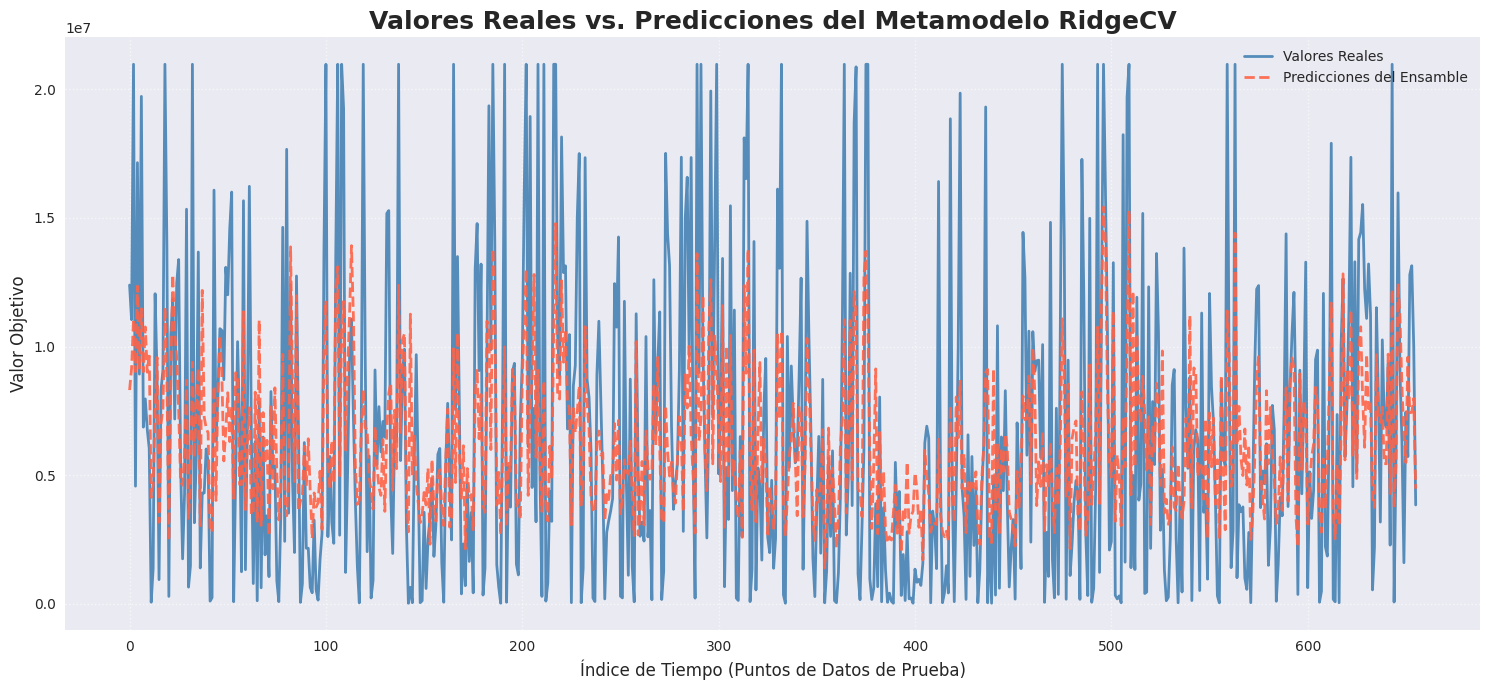

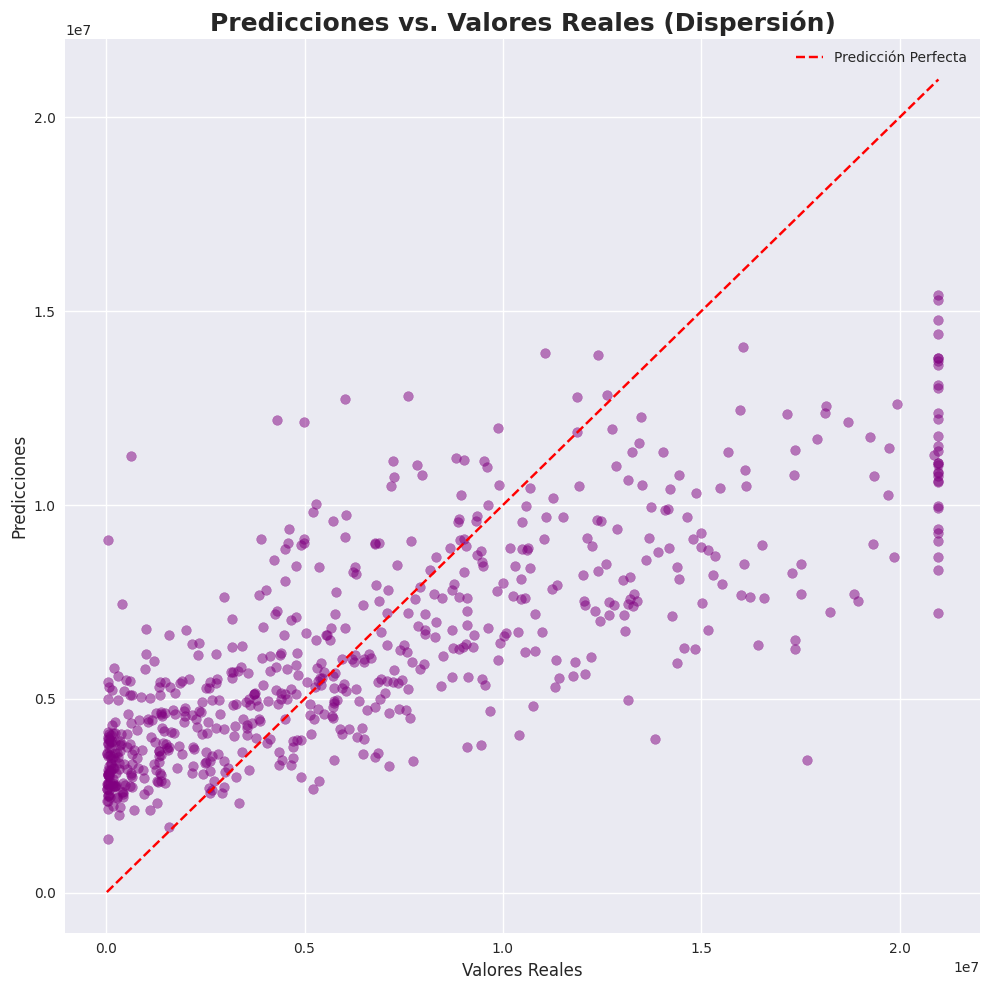

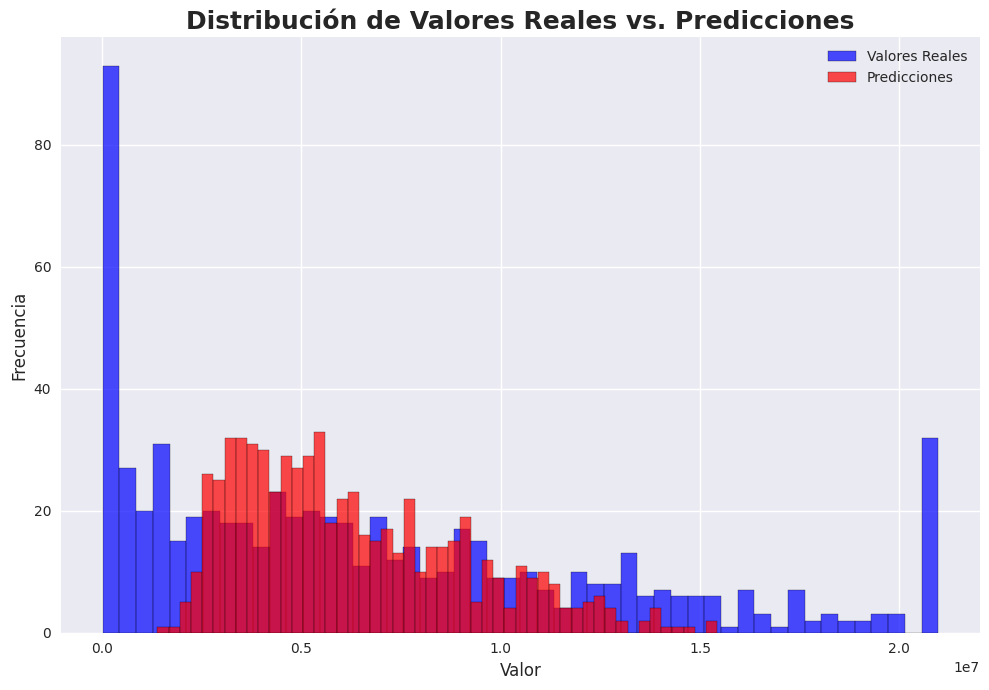

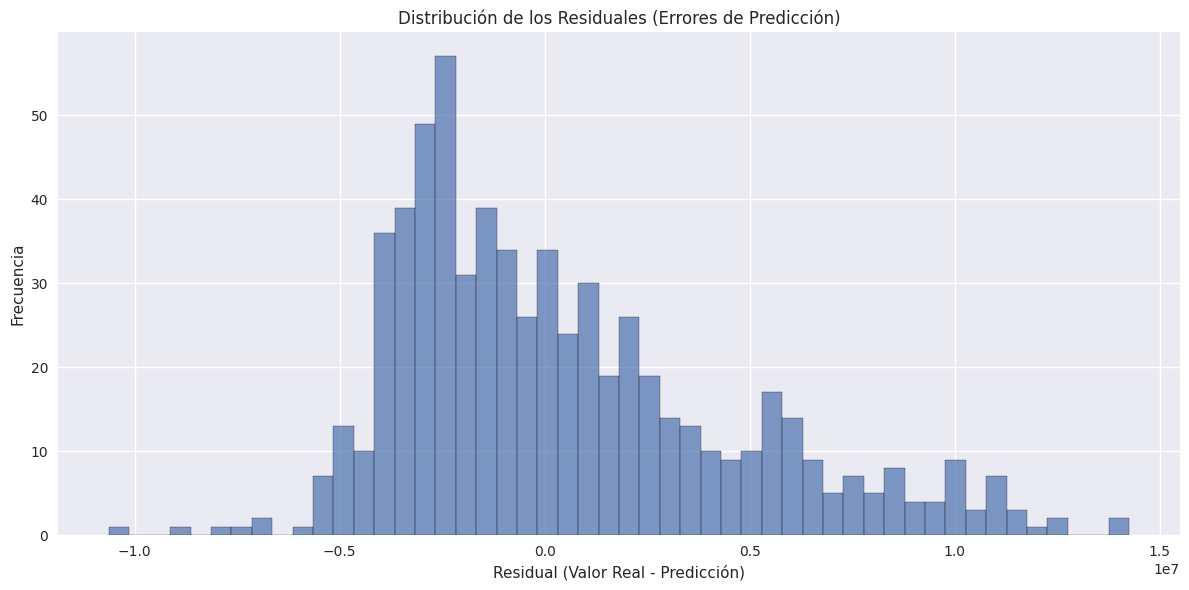

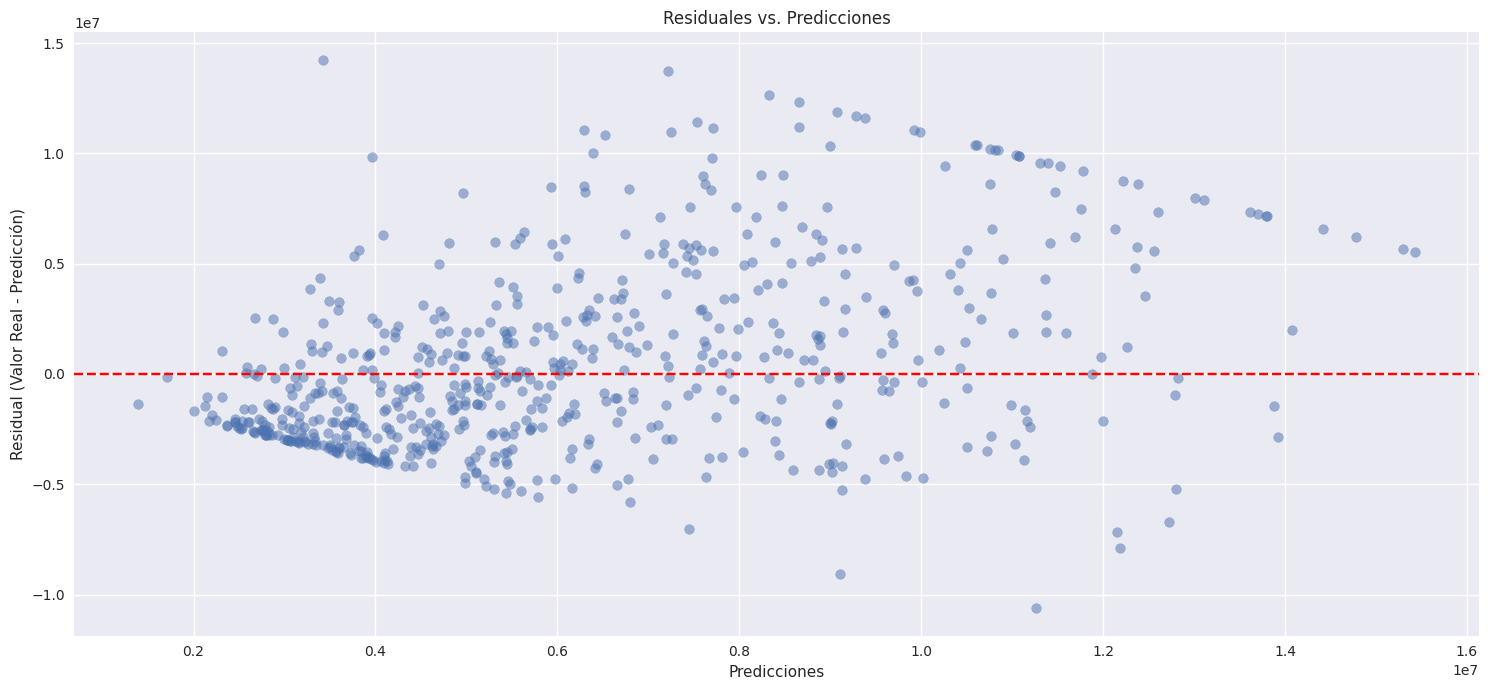

In [15]:
# celda 12
## ==============================================================================
# --- FASE 4: Evaluación y Análisis de Resultados ---
# ==============================================================================

import os
import time
import json
import numpy as np
import matplotlib.pyplot as plt
import warnings
from joblib import load, dump
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pandas as pd

# Ignorar advertencias que puedan surgir
warnings.filterwarnings("ignore")

# --- Funciones auxiliares (mantenerlas para asegurar que estén disponibles) ---
def calculate_smape_np(y_true, y_pred):
    """Calcula el Error Porcentual Absoluto Simétrico Medio (SMAPE) en NumPy."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape_value = np.where(denominator == 0, 0, numerator / denominator)
    return np.mean(smape_value) * 100

def mean_absolute_percentage_error(y_true, y_pred):
    """Calcula el Error Porcentual Absoluto Medio (MAPE) en NumPy."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    if not np.any(non_zero_mask):
        return np.nan
    mape = np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
    return mape

# --- Directorios y rutas de archivos ---

# Definir la ruta base para guardar los archivos
VERSION_SAVE_DIR = os.path.join(os.path.expanduser('~'), 'proyectos', 'backend-cafe-ia', 'progress', 'banano')
print(f"Ruta de directorio de guardado: {VERSION_SAVE_DIR}")

# Definir las rutas completas de los archivos
META_MODEL_PATH = os.path.join(VERSION_SAVE_DIR, 'metamodelo_RidgeCV.joblibb')
X_META_TEST_PATH = os.path.join(VERSION_SAVE_DIR, 'X_meta_test_array.joblib')
# ¡CORRECCIÓN AQUÍ! Usaremos y_scaled_pca.joblib
Y_SCALED_PATH = os.path.join(VERSION_SAVE_DIR, 'y_scaled_pca.joblib')
Y_SCALER_PATH = os.path.join(VERSION_SAVE_DIR, 'y_scaler.joblib')


# Archivos de datos originales y escaladores
Y_SCALED_TRAIN_PATH = os.path.join(VERSION_SAVE_DIR, 'y_train_final.joblib')
Y_SCALED_TEST_PATH = os.path.join(VERSION_SAVE_DIR, 'y_test_final.joblib')
Y_SCALER_PATH = os.path.join(VERSION_SAVE_DIR, 'y_scaler.joblib')
META_FEATURE_NAMES_PATH = os.path.join(VERSION_SAVE_DIR, 'meta_feature_names.joblib')


# --- Carga de datos y modelo ---
print(f"[{time.strftime('%H:%M:%S')}] Iniciando FASE 4: Evaluación y Análisis de Resultados...")

try:
    print(f"[{time.strftime('%H:%M:%S')}] Iniciando la carga de archivos...")
    
    # Importar tensorflow para cargar el modelo Keras
    import tensorflow as tf

    # Cargar los archivos usando las rutas definidas
   
    metamodelo = load(META_MODEL_PATH)
    X_meta_test_array = load(X_META_TEST_PATH)
    y_scaled_full = load(Y_SCALED_PATH)
    scaler_y = load(Y_SCALER_PATH)

    print("✅ Archivos cargados exitosamente.")

except FileNotFoundError as e:
    print(f"❌ ERROR: No se encontraron los archivos necesarios en la ruta especificada.")
    print(f"Detalles del error: {e}")
    print("Por favor, verifica que los archivos existan en la ruta mostrada arriba.")
    raise
except Exception as e:
    print(f"❌ Ocurrió un error inesperado al cargar los archivos: {e}")
    raise

# Generar predicciones con el metamodelo cargado
split_point = int(len(y_scaled_full) * 0.8)
y_test_final = y_scaled_full.iloc[split_point:]

predictions_scaled = metamodelo.predict(X_meta_test_array)

y_test_original = scaler_y.inverse_transform(y_test_final.to_numpy().reshape(-1, 1)).flatten()
predictions_original = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()
final_predictions = np.maximum(0, predictions_original)

# --- Resto del código de evaluación y visualización (sin cambios) ---
if 'final_predictions' in locals() and final_predictions.size > 0 and \
   'y_test_original' in locals() and y_test_original.size > 0:

    print("\n" + "="*80)
    print("--- FASE 4: Evaluación y Análisis de Resultados ---")
    print("="*80 + "\n")

    # --- Paso 4.1: Cálculo de Métricas ---
    print(f"[{time.strftime('%H:%M:%S')}] --- Paso 4.1: Cálculo de Métricas ---")
    print("1. Evaluando el rendimiento del modelo Ensemble (Stacking) con métricas relevantes.")

    y_test_original_np = y_test_original.flatten()
    final_predictions_np = final_predictions.flatten()

    if len(y_test_original_np) != len(final_predictions_np):
        print(f"[{time.strftime('%H:%M:%S')}] Advertencia: La longitud de y_test_original ({len(y_test_original_np)}) y final_predictions ({len(final_predictions_np)}) no coinciden.")
        min_len = min(len(y_test_original_np), len(final_predictions_np))
        y_test_original_np = y_test_original_np[:min_len]
        final_predictions_np = final_predictions_np[:min_len]
        print(f"[{time.strftime('%H:%M:%S')}] Ambos arrays se han truncado a la longitud mínima: {min_len}.")

    try:
        final_r2 = r2_score(y_test_original_np, final_predictions_np)
        final_mse = mean_squared_error(y_test_original_np, final_predictions_np)
        final_rmse = np.sqrt(final_mse)
        final_mae = mean_absolute_error(y_test_original_np, final_predictions_np)
        final_mape = mean_absolute_percentage_error(y_test_original_np, final_predictions_np)
        final_smape = calculate_smape_np(y_test_original_np, final_predictions_np)
    except Exception as e:
        print(f"Error al calcular métricas: {e}")
        final_r2, final_mse, final_rmse, final_mae, final_mape, final_smape = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    print(f"[{time.strftime('%H:%M:%S')}] Métricas de Evaluación Final del Modelo Ensamble (Stacking):")
    print(f"  R²: {final_r2:.4f}")
    print(f"  MAPE: {final_mape:.2f}%" if not np.isnan(final_mape) else "  MAPE: No calculado")
    print(f"  SMAPE: {final_smape:.2f}%" if not np.isnan(final_smape) else "  SMAPE: No calculado")
    print(f"  RMSE: {final_rmse:.4f}")
    print(f"  MAE: {final_mae:.4f}")
    print(f"  MSE: {final_mse:.4f}")

    # --- Visualización de Resultados ---
    print(f"\n[{time.strftime('%H:%M:%S')}] --- Visualización de Resultados ---")

    # Gráfico 1: Serie de Tiempo - Valores Reales vs. Predicciones
    plt.style.use('seaborn-v0_8')
    plt.figure(figsize=(15, 7))
    plt.plot(y_test_original_np, label='Valores Reales', color='steelblue', linewidth=2, alpha=0.9)
    plt.plot(final_predictions_np, label='Predicciones del Ensamble', color='tomato', linestyle='--', linewidth=2, alpha=0.9)
    plt.title('Valores Reales vs. Predicciones del Metamodelo RidgeCV', fontsize=18, fontweight='bold')
    plt.xlabel('Índice de Tiempo (Puntos de Datos de Prueba)', fontsize=12)
    plt.ylabel('Valor Objetivo', fontsize=12)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.savefig(os.path.join(VERSION_SAVE_DIR, 'Valores_reales_vr_predicciones.png'))
    plt.show()

    # Gráfico 2: Dispersión - Predicciones vs. Valores Reales
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test_original_np, final_predictions_np, alpha=0.5, color='purple')
    max_val = max(y_test_original_np.max(), final_predictions_np.max())
    min_val = min(y_test_original_np.min(), final_predictions_np.min())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Predicción Perfecta')
    plt.title('Predicciones vs. Valores Reales (Dispersión)', fontsize=18, fontweight='bold')
    plt.xlabel('Valores Reales', fontsize=12)
    plt.ylabel('Predicciones', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(VERSION_SAVE_DIR, 'Dispercion.png'))
    plt.show()

    # Gráfico 3: Distribución - Valores Reales vs. Predicciones
    plt.figure(figsize=(10, 7))
    plt.hist(y_test_original_np, bins=50, alpha=0.7, label='Valores Reales', color='blue', edgecolor='k')
    plt.hist(final_predictions_np, bins=50, alpha=0.7, label='Predicciones', color='red', edgecolor='k')
    plt.title('Distribución de Valores Reales vs. Predicciones', fontsize=18, fontweight='bold')
    plt.xlabel('Valor', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(VERSION_SAVE_DIR, 'Distribucion_valores_reales.png'))
    plt.show()

    # Gráfico 4: Distribución de Residuales
    residuals = y_test_original_np - final_predictions_np
    plt.figure(figsize=(12, 6))
    plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
    plt.title('Distribución de los Residuales (Errores de Predicción)')
    plt.xlabel('Residual (Valor Real - Predicción)')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(VERSION_SAVE_DIR, 'Residuos.png'))
    plt.show()

    # Gráfico 5: Residuales vs. Predicciones (Dispersión)
    plt.figure(figsize=(15, 7))
    plt.scatter(final_predictions_np, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuales vs. Predicciones')
    plt.xlabel('Predicciones')
    plt.ylabel('Residual (Valor Real - Predicción)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(VERSION_SAVE_DIR, 'Residuales_prediccion.png'))
    plt.show()

else:
    print(f"[{time.strftime('%H:%M:%S')}] FASE 4: No se pudo ejecutar. Las variables 'final_predictions' o 'y_test_original' no están definidas o están vacías.")
    print("Asegúrate de que las celdas de entrenamiento de los modelos base y del metamodelo se hayan completado correctamente.")



Ruta de directorio de guardado: /home/administrador/proyectos/backend-cafe-ia/progress/banano

--- FASE 4.2: ANÁLISIS DE ROBUSTEZ Y SENSIBILIDAD ---
--- FASE 4.2.1: Análisis de Sensibilidad y Análisis What-If ---

[00:17:08] Iniciando carga de artefactos para el análisis...
[00:17:11] ✅ Todos los artefactos necesarios han sido cargados.
[00:17:11] Cargando X_scaled y y_scaled para preparar X_test_final...
[00:17:11] X_test_final_df preparado. Shape: (400, 10)

[00:17:11] Instancia base seleccionada (Índice: 0):
          PC_1      PC_2      PC_3      PC_4      PC_5      PC_6      PC_7  \
2620 -0.053138  0.153023 -0.516548 -0.295205  0.204752 -0.144525  0.142318   

          PC_8      PC_9     PC_10  
2620  0.204992  0.078061 -0.192709  
[00:17:11] Valor real (desescalado): 12,391,693.62

--- INICIANDO FASE 4.2.1: ANÁLISIS DE SENSIBILIDAD ---

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s

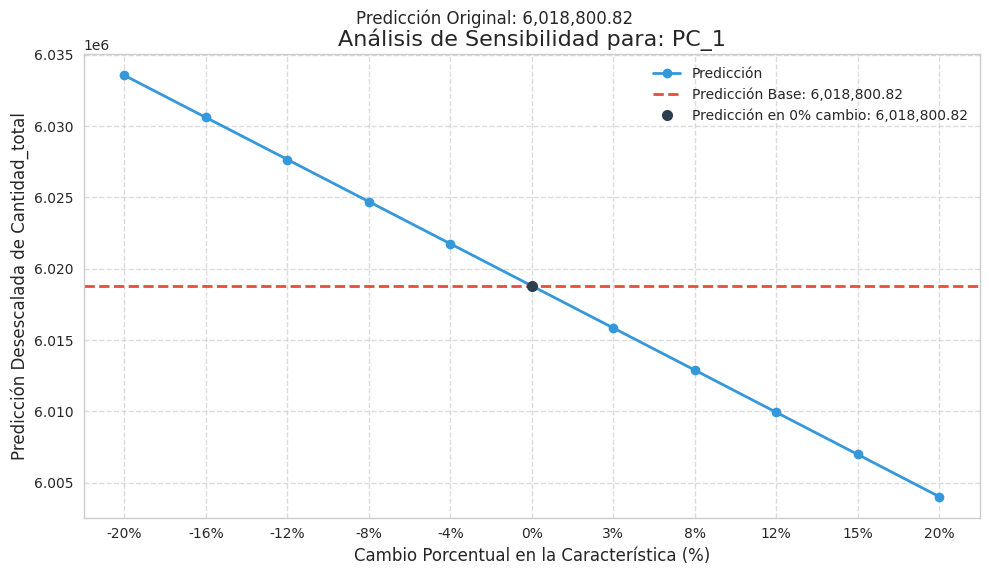

[00:18:14] 📊 Mostrando gráfico para 'PC_2'.


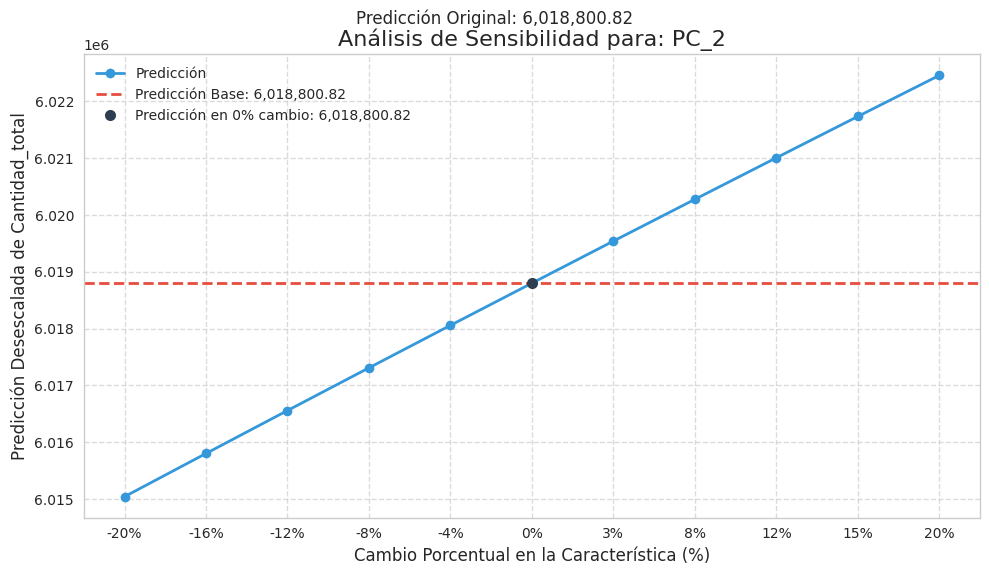

[00:18:14] 📊 Mostrando gráfico para 'PC_3'.


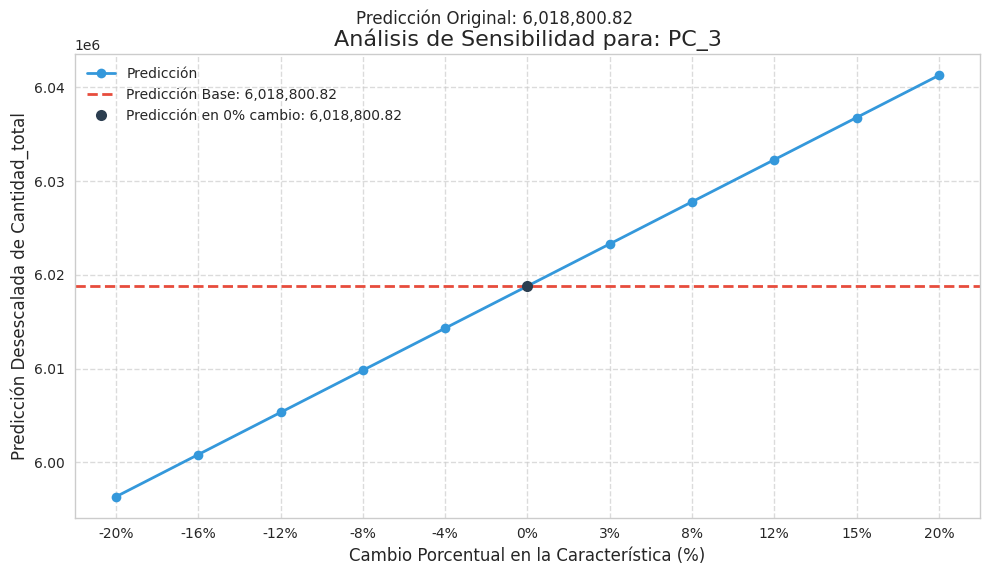

[00:18:14] 📊 Mostrando gráfico para 'PC_4'.


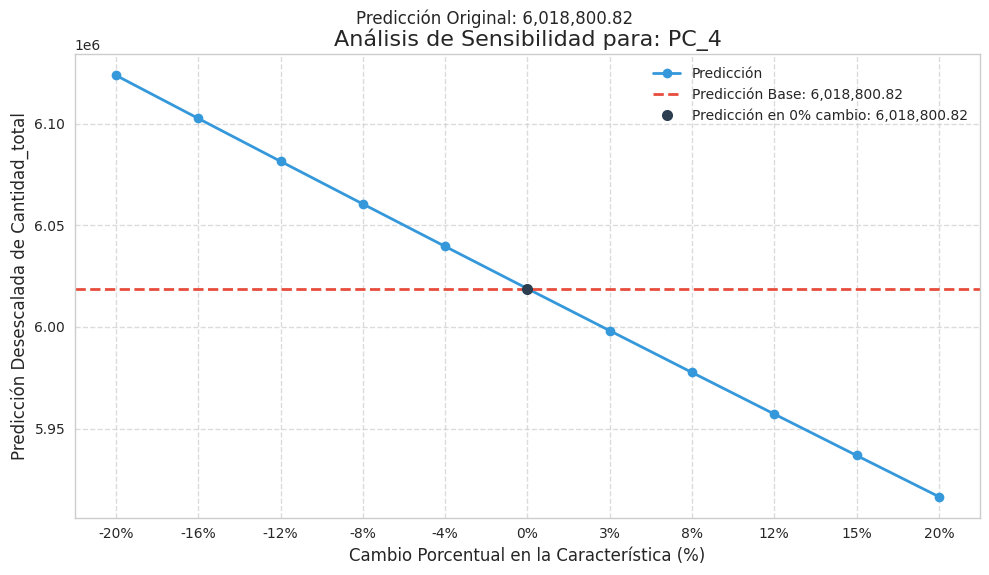

[00:18:15] 📊 Mostrando gráfico para 'PC_5'.


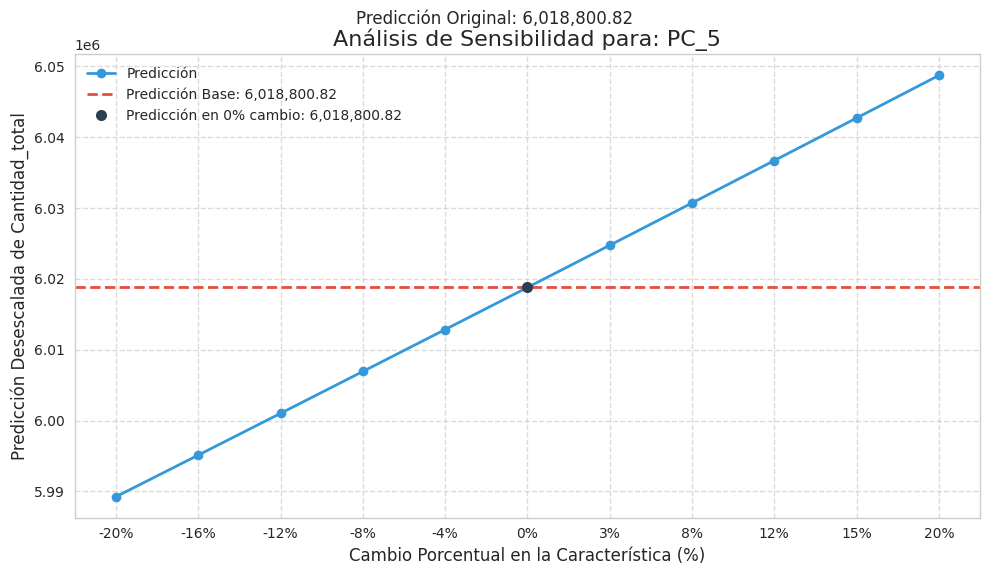

[00:18:15] 📊 Mostrando gráfico para 'PC_6'.


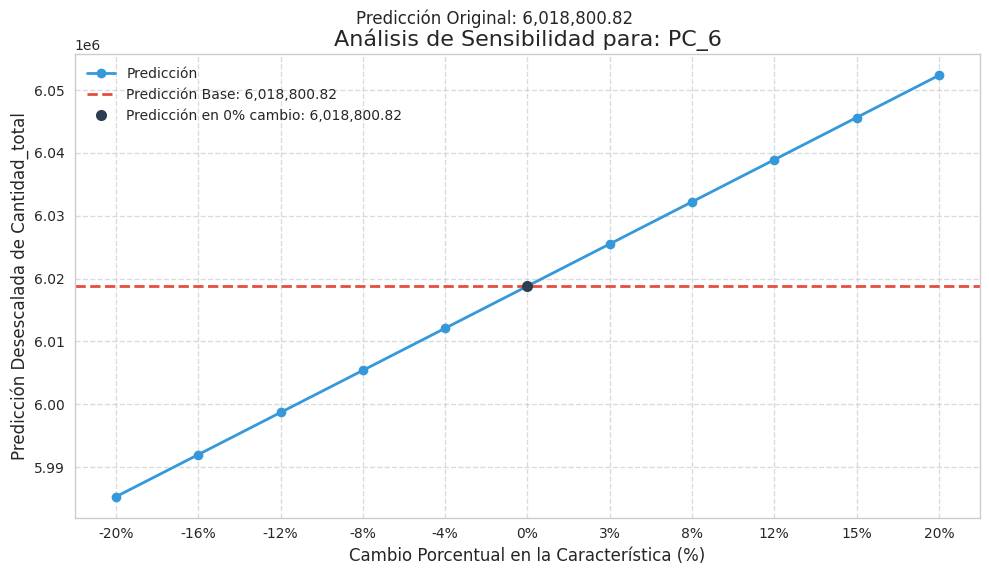

[00:18:15] 📊 Mostrando gráfico para 'PC_7'.


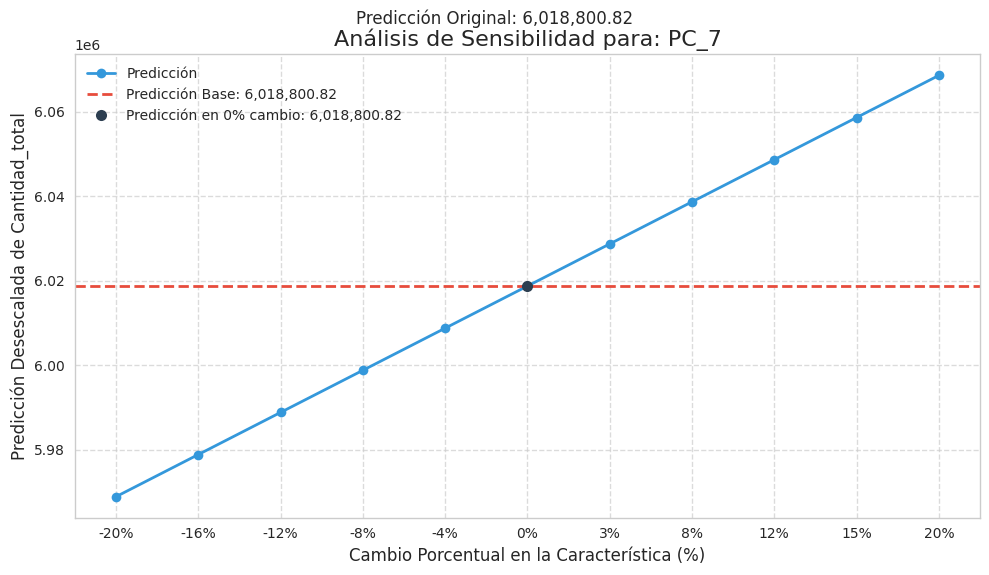

[00:18:15] 📊 Mostrando gráfico para 'PC_8'.


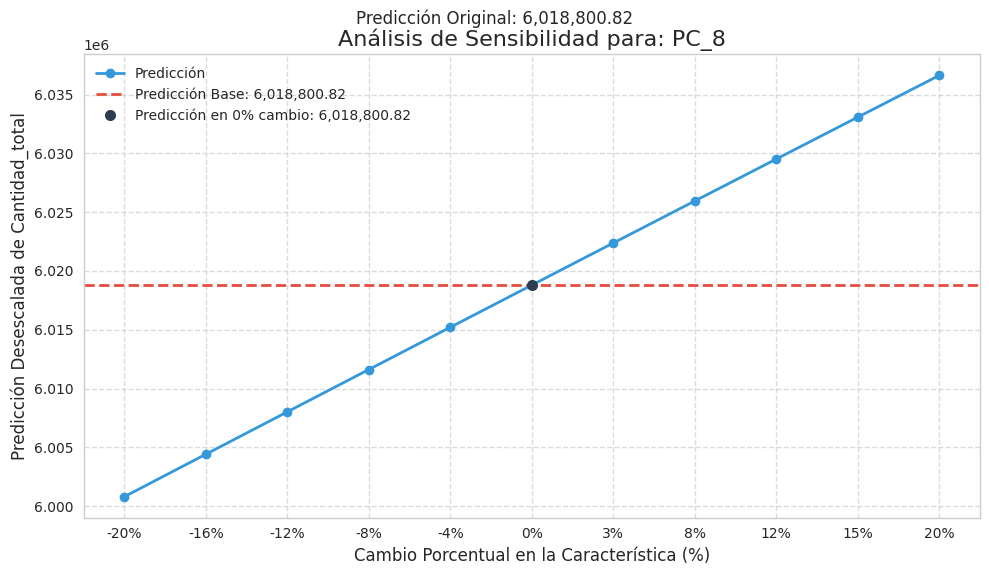

[00:18:16] 📊 Mostrando gráfico para 'PC_9'.


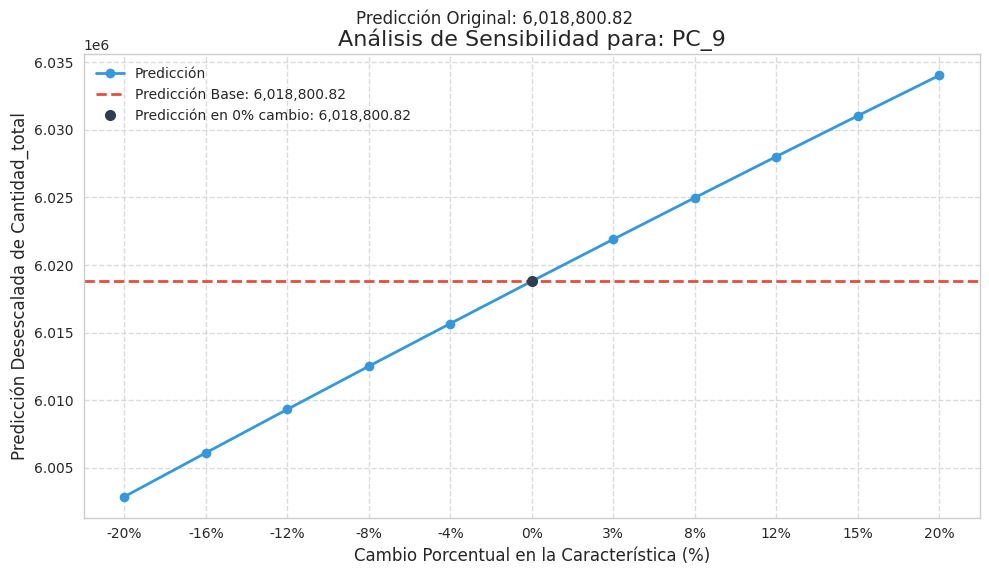

[00:18:16] 📊 Mostrando gráfico para 'PC_10'.


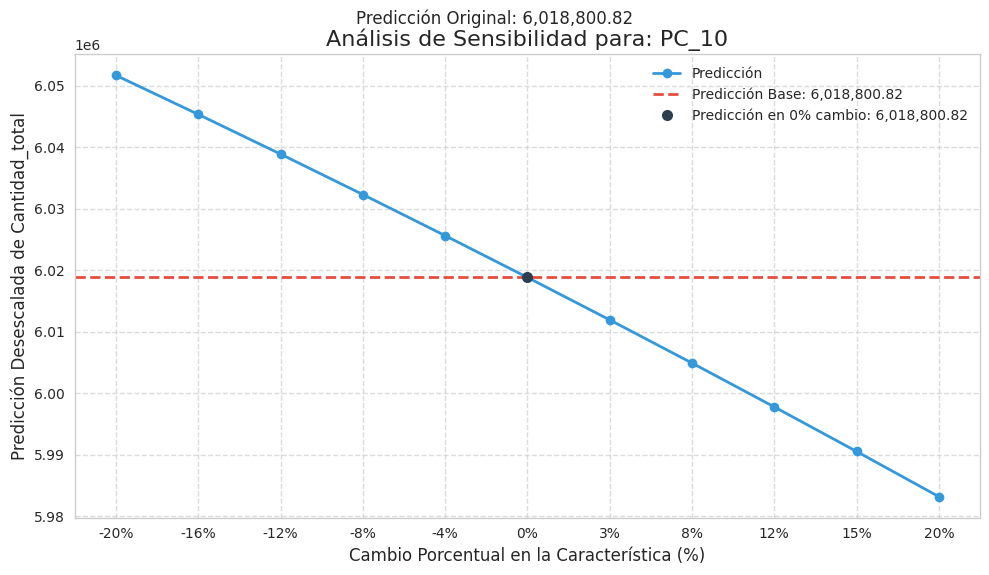


[00:18:16] Fin de la generación de gráficos de sensibilidad.

--- INICIANDO FASE 4.2.2: CÁLCULO DE INTERVALOS DE CONFIANZA ---


--- FASE 4.2.2: Cálculo de Intervalos de Confianza en las Predicciones ---

[00:18:16] Iniciando cálculo de Intervalos de Confianza...
[00:18:16] Configuración de Bootstrapping: 1000 muestras, 95% CI.
[00:18:16] Generando meta-características para todo X_test_final...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
[00:18:19] Residuales calculados. Std: 0.2497
[00:18:19] Realizando 1000 muestras de bootstrapping...
[00:18:19] Bootstrapping completado.
[00:18:19] Intervalos de confianza calculados y desescalados.

--- EJEMPLO DE PREDICCIONES CON INTERVALOS DE CONFIANZA (Primeros 5) ---
         Valor_Real  Prediccion_Meta_Modelo  Limite_Inferior_95CI  Limite_Superior_95CI
Fecha                                

In [16]:
# celda 13# ==============================================================================
# --- FASE 4.2: ANÁLISIS DE ROBUSTEZ Y SENSIBILIDAD ---
# --- SCRIPT CORREGIDO PARA VISUALIZAR LOS GRÁFICOS DIRECTAMENTE ---
# ==============================================================================

import os
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from joblib import load, dump
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
import keras
import joblib

# Ignorar advertencias que puedan surgir
warnings.filterwarnings("ignore")

# --- Funciones auxiliares (del código anterior) ---
@keras.saving.register_keras_serializable()
def smape_keras(y_true, y_pred):
    """Métrica SMAPE personalizada para Keras."""
    epsilon = 0.1
    summ = K.maximum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5)
    smape = K.mean(2 * K.abs(y_pred - y_true) / summ) * 100
    return smape

def get_meta_features_from_original_instance(instance_df, loaded_tree_models, loaded_rnn_models, lstm_sequence_length, original_feature_names):
    """
    Genera las meta-características (predicciones de los modelos base).
    """
    meta_preds = {}
    
    # Se prepara la instancia para los modelos de árboles
    generic_feature_names_for_tree = [f'feature_{i}' for i in range(len(original_feature_names))]
    rename_mapping_for_tree = dict(zip(instance_df.columns, generic_feature_names_for_tree))
    instance_df_renamed = instance_df.rename(columns=rename_mapping_for_tree)
    
    # Predicciones de modelos de árboles
    for name, model in loaded_tree_models.items():
        if model is not None:
            if len(instance_df_renamed.columns) != len(original_feature_names):
                raise ValueError(f"El número de características en instance_df_renamed ({len(instance_df_renamed.columns)}) no coincide con las características esperadas ({len(original_feature_names)}) para los modelos de árbol.")
            meta_preds[f'pred_{name}'] = model.predict(instance_df_renamed)
        else:
            meta_preds[f'pred_{name}'] = np.zeros(len(instance_df))
            
    # Predicciones de modelos RNN
    for name, model in loaded_rnn_models.items():
        if model is not None:
            X_rnn = instance_df.copy()
            
            if len(X_rnn) < lstm_sequence_length:
                padded_data = np.zeros((lstm_sequence_length, len(original_feature_names)))
                padded_data[-len(X_rnn):, :] = X_rnn.values
                X_rnn_padded = padded_data.reshape(1, lstm_sequence_length, len(original_feature_names))
            else:
                X_rnn_padded = np.zeros((len(instance_df), lstm_sequence_length, len(original_feature_names)))
                for i in range(len(instance_df)):
                    start_idx = max(0, i - lstm_sequence_length + 1)
                    seq = X_rnn.iloc[start_idx:i+1].values
                    if seq.shape[1] != len(original_feature_names):
                        raise ValueError(f"El número de características de la secuencia no coincide: Esperado {len(original_feature_names)}, Obtenido {seq.shape[1]}.")
                    
                    X_rnn_padded[i, -len(seq):, :] = seq

            meta_preds[f'pred_{name}'] = model.predict(X_rnn_padded).flatten()
        else:
            meta_preds[f'pred_{name}'] = np.zeros(len(instance_df))
    
    final_meta_features = pd.DataFrame(meta_preds, index=instance_df.index)
    
    return final_meta_features

# --- Directorios y rutas de archivos ---
# Definir la ruta base para guardar los archivos
VERSION_SAVE_DIR = os.path.join(os.path.expanduser('~'), 'proyectos', 'backend-cafe-ia', 'progress', 'banano')
print(f"Ruta de directorio de guardado: {VERSION_SAVE_DIR}")

# Definir la columna objetivo
TARGET_COLUMN = 'Cantidad_total'

# Rutas para el meta-modelo (RidgeCV) y sus métricas de stacking.
# NOTA: Se ha corregido la ruta del metamodelo a GradientBoosting
META_MODEL_PATH = os.path.join(VERSION_SAVE_DIR, 'metamodelo_RidgeCV.joblibb')
STACKING_METRICS_PATH = os.path.join(VERSION_SAVE_DIR, 'stacking_metrics_RidgeCV.json')

# Rutas de los artefactos
X_SCALED_PATH = os.path.join(VERSION_SAVE_DIR, 'X_scaled_pca.joblib')
Y_SCALED_PATH = os.path.join(VERSION_SAVE_DIR, 'y_scaled_pca.joblib')
Y_SCALER_PATH = os.path.join(VERSION_SAVE_DIR, 'y_scaler.joblib')
META_FEATURE_NAMES_PATH = os.path.join(VERSION_SAVE_DIR, 'meta_feature_names.joblib')
BASE_MODEL_NAMES_PATH = os.path.join(VERSION_SAVE_DIR, 'base_model_names.joblib')
LSTM_SEQUENCE_LENGTH_PATH = os.path.join(VERSION_SAVE_DIR, 'lstm_sequence_length.json')

def load_all_artifacts():
    print("\n" + "="*80)
    print("--- FASE 4.2: ANÁLISIS DE ROBUSTEZ Y SENSIBILIDAD ---")
    print("--- FASE 4.2.1: Análisis de Sensibilidad y Análisis What-If ---")
    print("="*80 + "\n")
    print(f"[{time.strftime('%H:%M:%S')}] Iniciando carga de artefactos para el análisis...")
    
    artifacts = {}
    
    try:
        # Se remueve la carga de 'scaler_X' ya que no se encontró el archivo
        artifacts['scaler_y'] = joblib.load(Y_SCALER_PATH)
        
        # CORRECCIÓN: Usar load_model de Keras en lugar de joblib
        artifacts['final_meta_model'] = joblib.load(META_MODEL_PATH)
        
        artifacts['meta_feature_names'] = joblib.load(META_FEATURE_NAMES_PATH)
        base_model_names_data = joblib.load(BASE_MODEL_NAMES_PATH)
        artifacts['base_meta_feature_names'] = base_model_names_data.get('meta_feature_names', [])
        
        with open(LSTM_SEQUENCE_LENGTH_PATH, 'r') as f:
            lstm_config = json.load(f)
            artifacts['lstm_sequence_length'] = lstm_config.get('sequence_length', 1)

        artifacts['loaded_tree_models'] = {}
        tree_model_names_expected = ['XGBoost', 'Bagging', 'RandomForest', 'AdaBoost', 'GradientBoosting']
        for name in tree_model_names_expected:
            model_path = os.path.join(VERSION_SAVE_DIR, f'final_tree_model_{name}.joblib')
            if os.path.exists(model_path):
                artifacts['loaded_tree_models'][name] = joblib.load(model_path)
            else:
                artifacts['loaded_tree_models'][name] = None
        
        artifacts['loaded_rnn_models'] = {}
        rnn_model_types_for_loading = ['SimpleRNN', 'LSTM', 'GRU', 'BiLSTM', 'BiGRU']
        custom_objects = {'smape_keras': smape_keras}
        for name in rnn_model_types_for_loading:
            model_path = os.path.join(VERSION_SAVE_DIR, f'final_rnn_model_{name}.keras')
            if os.path.exists(model_path):
                artifacts['loaded_rnn_models'][name] = load_model(model_path, custom_objects=custom_objects)
            else:
                artifacts['loaded_rnn_models'][name] = None
        
        print(f"[{time.strftime('%H:%M:%S')}] ✅ Todos los artefactos necesarios han sido cargados.")
        return artifacts
    except FileNotFoundError as e:
        print(f"[{time.strftime('%H:%M:%S')}] ❌ ERROR: No se pudo cargar un archivo necesario. Asegúrate de que las fases de entrenamiento y guardado se completaron correctamente.")
        print(f"Detalles: {e}")
        return None
    except Exception as e:
        print(f"[{time.strftime('%H:%M:%S')}] ❌ Ocurrió un error inesperado durante la carga de artefactos: {e}")
        return None

def prepare_analysis_data(artifacts):
    print(f"[{time.strftime('%H:%M:%S')}] Cargando X_scaled y y_scaled para preparar X_test_final...")
    try:
        X_scaled_full = joblib.load(X_SCALED_PATH)
        y_scaled_full = joblib.load(Y_SCALED_PATH)
    except FileNotFoundError as e:
        print(f"[{time.strftime('%H:%M:%S')}] ❌ ERROR: Archivos de datos escalados no encontrados: {e}")
        return None, None, None, None, None

    # Definir los nombres de las características originales (PCA)
    original_feature_names = [f'PC_{i}' for i in range(1, 11)]
    
    if not isinstance(X_scaled_full, pd.DataFrame):
        X_scaled_full = pd.DataFrame(X_scaled_full)
    
    if X_scaled_full.shape[1] > 10:
        X_scaled_full = X_scaled_full.iloc[:, :10]
        X_scaled_full.columns = original_feature_names
        print(f"[{time.strftime('%H:%M:%S')}] ⚠️ Advertencia: El DataFrame X_scaled_full tenía más de 10 columnas. Se han seleccionado solo las primeras 10 (las correspondientes a PCA).")
    elif X_scaled_full.shape[1] == 10:
        X_scaled_full.columns = original_feature_names
    else:
        raise ValueError(f"El DataFrame cargado tiene un número inesperado de columnas: {X_scaled_full.shape[1]}. Se esperaban 10.")
    
    if not isinstance(y_scaled_full, pd.Series):
        y_scaled_full = pd.Series(y_scaled_full, name=TARGET_COLUMN)

    split_point_final = int(len(X_scaled_full) * 0.8)
    X_test_final_df = X_scaled_full.iloc[split_point_final:split_point_final + 400].copy()
    y_test_final = y_scaled_full.iloc[split_point_final:split_point_final + 400].copy()
    
    print(f"[{time.strftime('%H:%M:%S')}] X_test_final_df preparado. Shape: {X_test_final_df.shape}")

    instance_index = 0
    base_instance = X_test_final_df.iloc[[instance_index]].copy()
    original_true_value_scaled = y_test_final.iloc[instance_index]
    original_true_value_descaled = artifacts['scaler_y'].inverse_transform(np.array([[original_true_value_scaled]]))[0][0]
    
    print(f"\n[{time.strftime('%H:%M:%S')}] Instancia base seleccionada (Índice: {instance_index}):")
    print(base_instance)
    print(f"[{time.strftime('%H:%M:%S')}] Valor real (desescalado): {original_true_value_descaled:,.2f}")

    return X_test_final_df, y_test_final, base_instance, original_true_value_descaled, original_feature_names

def run_sensitivity_analysis(artifacts, base_instance, original_true_value_descaled, original_feature_names):
    """
    Realiza el análisis de sensibilidad variando las características de la instancia base.
    """
    meta_model = artifacts['final_meta_model']
    scaler_y = artifacts['scaler_y']
    
    meta_prediction_names = [f'pred_{name}' for name in artifacts['loaded_tree_models']] + \
                            [f'pred_{name}' for name in artifacts['loaded_rnn_models']]
    meta_model_feature_names = meta_prediction_names
    
    original_feature_count = len(original_feature_names)
    
    original_meta_features = get_meta_features_from_original_instance(
        base_instance,
        artifacts['loaded_tree_models'],
        artifacts['loaded_rnn_models'],
        artifacts['lstm_sequence_length'],
        original_feature_names
    )

    if len(original_meta_features.columns) == len(meta_model_feature_names):
        original_meta_features.columns = meta_model_feature_names
    else:
        raise ValueError(f"El número de características no coincide: Esperado {len(meta_model_feature_names)}, Obtenido {len(original_meta_features.columns)}")
        
    original_prediction_scaled = meta_model.predict(original_meta_features)
    original_prediction_descaled = scaler_y.inverse_transform(original_prediction_scaled.reshape(-1, 1))[0][0]
    print(f"\n[{time.strftime('%H:%M:%S')}] Predicción del meta-modelo para la instancia base: {original_prediction_descaled:,.2f}")

    variation_range = np.linspace(-0.2, 0.2, 11)
    sensitivity_results = {}

    for feature_name in original_feature_names:
        print(f"[{time.strftime('%H:%M:%S')}] Analizando sensibilidad para la característica: '{feature_name}'...")
        predictions_scaled = []
        
        original_value_scaled = base_instance[feature_name].iloc[0]

        for mod_factor in variation_range:
            modified_instance = base_instance.copy()
            modified_instance[feature_name] = original_value_scaled * (1 + mod_factor)
            
            modified_meta_features = get_meta_features_from_original_instance(
                modified_instance,
                artifacts['loaded_tree_models'],
                artifacts['loaded_rnn_models'],
                artifacts['lstm_sequence_length'],
                original_feature_names
            )

            if len(modified_meta_features.columns) == len(meta_model_feature_names):
                modified_meta_features.columns = meta_model_feature_names
            else:
                raise ValueError(f"El número de características para la instancia modificada no coincide: Esperado {len(meta_model_feature_names)}, Obtenido {len(modified_meta_features.columns)}")

            pred_scaled = meta_model.predict(modified_meta_features)
            predictions_scaled.append(pred_scaled[0][0] if isinstance(pred_scaled[0], np.ndarray) else pred_scaled[0])
            
        predictions_descaled = scaler_y.inverse_transform(np.array(predictions_scaled).reshape(-1, 1)).flatten()

        sensitivity_results[feature_name] = {
            'predictions_descaled': predictions_descaled,
        }
    
    print(f"[{time.strftime('%H:%M:%S')}] Análisis de sensibilidad completado para {len(original_feature_names)} características.")
    return sensitivity_results, original_prediction_descaled

def generate_and_show_sensitivity_plots(sensitivity_results, original_prediction_descaled):
    """
    Genera y muestra cada gráfico de sensibilidad de forma individual.
    """
    print(f"\n[{time.strftime('%H:%M:%S')}] Iniciando generación y visualización de gráficos de sensibilidad...")
    
    if not sensitivity_results:
        print(f"[{time.strftime('%H:%M:%S')}] No hay resultados de sensibilidad para graficar.")
        return

    modification_percentages = np.linspace(-0.2, 0.2, 11) * 100
    
    for feature_name, data in sensitivity_results.items():
        predictions_descaled = data['predictions_descaled']
        
        plt.figure(figsize=(10, 6))
        plt.style.use('seaborn-v0_8-whitegrid')
        
        plt.plot(modification_percentages, predictions_descaled, marker='o', color='#3498db', linewidth=2, label='Predicción')
        plt.axhline(y=original_prediction_descaled, color='#e74c3c', linestyle='--', linewidth=2, label=f'Predicción Base: {original_prediction_descaled:,.2f}')

        idx_0_percent = np.where(modification_percentages == 0.0)[0][0]
        plt.plot(modification_percentages[idx_0_percent], predictions_descaled[idx_0_percent], 'o', color='#2c3e50', markersize=8, label=f'Predicción en 0% cambio: {predictions_descaled[idx_0_percent]:,.2f}')
        
        plt.title(f'Análisis de Sensibilidad para: {feature_name}', fontsize=16)
        plt.suptitle(f'Predicción Original: {original_prediction_descaled:,.2f}', fontsize=12, y=0.95)
        plt.xlabel('Cambio Porcentual en la Característica (%)', fontsize=12)
        plt.ylabel(f'Predicción Desescalada de {TARGET_COLUMN}', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xticks(modification_percentages, [f'{int(p)}%' for p in modification_percentages])
        plt.legend(fontsize=10, loc='best')
        plt.tight_layout()
        
        print(f"[{time.strftime('%H:%M:%S')}] 📊 Mostrando gráfico para '{feature_name}'.")
        plt.show() # Muestra la ventana del gráfico
        plt.close() # Cierra la ventana del gráfico después de que el usuario la cierre

    print(f"\n[{time.strftime('%H:%M:%S')}] Fin de la generación de gráficos de sensibilidad.")

def calculate_confidence_intervals(X_test_final_df, y_test_final, final_meta_model, scaler_y,
                                 loaded_tree_models, loaded_rnn_models,
                                 lstm_sequence_length, original_feature_names,
                                 n_bootstrap_samples=1000, confidence_level=0.95,
                                 VERSION_SAVE_DIR=None):
    print("\n" + "="*80)
    print("--- FASE 4.2.2: Cálculo de Intervalos de Confianza en las Predicciones ---")
    print("="*80 + "\n")
    
    try:
        print(f"[{time.strftime('%H:%M:%S')}] Iniciando cálculo de Intervalos de Confianza...")

        meta_prediction_names = [f'pred_{name}' for name in loaded_tree_models] + \
                                [f'pred_{name}' for name in loaded_rnn_models]
        meta_model_feature_names = meta_prediction_names

        if not isinstance(X_test_final_df.index, pd.DatetimeIndex):
            index_for_ci_results = pd.RangeIndex(start=0, stop=len(X_test_final_df))
        else:
            index_for_ci_results = X_test_final_df.index
        
        alpha = 1 - confidence_level
        lower_percentile = alpha / 2 * 100
        upper_percentile = (1 - alpha / 2) * 100
        print(f"[{time.strftime('%H:%M:%S')}] Configuración de Bootstrapping: {n_bootstrap_samples} muestras, {confidence_level*100:.0f}% CI.")

        print(f"[{time.strftime('%H:%M:%S')}] Generando meta-características para todo X_test_final...")
        all_meta_features_test = get_meta_features_from_original_instance(
            X_test_final_df,
            loaded_tree_models,
            loaded_rnn_models,
            lstm_sequence_length,
            original_feature_names
        )
        
        if len(all_meta_features_test.columns) == len(meta_model_feature_names):
            all_meta_features_test.columns = meta_model_feature_names
        else:
            raise ValueError("El número de características generadas no coincide con las esperadas por el meta-modelo.")

        y_pred_meta_scaled = final_meta_model.predict(all_meta_features_test)
        y_pred_meta_scaled = y_pred_meta_scaled.flatten()

        y_true_scaled = y_test_final.values.flatten()

        if len(y_true_scaled) != len(y_pred_meta_scaled):
            raise ValueError(f"Las longitudes de y_true ({len(y_true_scaled)}) y y_pred ({len(y_pred_meta_scaled)}) no coinciden.")

        residuals_scaled = y_true_scaled - y_pred_meta_scaled
        print(f"[{time.strftime('%H:%M:%S')}] Residuales calculados. Std: {np.std(residuals_scaled):.4f}")

        bootstrapped_predictions_scaled = np.zeros((len(y_pred_meta_scaled), n_bootstrap_samples))
        print(f"[{time.strftime('%H:%M:%S')}] Realizando {n_bootstrap_samples} muestras de bootstrapping...")
        np.random.seed(42)
        for i in range(n_bootstrap_samples):
            sampled_residuals = np.random.choice(residuals_scaled, size=len(residuals_scaled), replace=True)
            bootstrapped_predictions_scaled[:, i] = y_pred_meta_scaled + sampled_residuals
        print(f"[{time.strftime('%H:%M:%S')}] Bootstrapping completado.")

        lower_bound_scaled = np.percentile(bootstrapped_predictions_scaled, lower_percentile, axis=1)
        upper_bound_scaled = np.percentile(bootstrapped_predictions_scaled, upper_percentile, axis=1)

        y_pred_meta_descaled = scaler_y.inverse_transform(y_pred_meta_scaled.reshape(-1, 1)).flatten()
        lower_bound_descaled = scaler_y.inverse_transform(lower_bound_scaled.reshape(-1, 1)).flatten()
        upper_bound_descaled = scaler_y.inverse_transform(upper_bound_scaled.reshape(-1, 1)).flatten()
        y_true_descaled = scaler_y.inverse_transform(y_true_scaled.reshape(-1, 1)).flatten()

        y_pred_meta_descaled = np.maximum(0, y_pred_meta_descaled)
        lower_bound_descaled = np.maximum(0, lower_bound_descaled)
        upper_bound_descaled = np.maximum(0, upper_bound_descaled)
        y_true_descaled = np.maximum(0, y_true_descaled)

        print(f"[{time.strftime('%H:%M:%S')}] Intervalos de confianza calculados y desescalados.")

        confidence_interval_results = pd.DataFrame({
            'Fecha': index_for_ci_results,
            'Valor_Real': y_true_descaled,
            'Prediccion_Meta_Modelo': y_pred_meta_descaled,
            f'Limite_Inferior_{confidence_level*100:.0f}CI': lower_bound_descaled,
            f'Limite_Superior_{confidence_level*100:.0f}CI': upper_bound_descaled
        })
        confidence_interval_results.set_index('Fecha', inplace=True)
        print("\n--- EJEMPLO DE PREDICCIONES CON INTERVALOS DE CONFIANZA (Primeros 5) ---")
        print(confidence_interval_results.head().to_string())
        
        if VERSION_SAVE_DIR and os.path.exists(VERSION_SAVE_DIR):
            ci_results_path = os.path.join(VERSION_SAVE_DIR, 'confidence_interval_results.csv')
            confidence_interval_results.to_csv(ci_results_path, index=True)
            print(f"\n[{time.strftime('%H:%M:%S')}] ✅ Resultados de Intervalos de Confianza guardados en: {ci_results_path}")
        else:
            print(f"\n[{time.strftime('%H:%M:%S')}] ⚠️ Advertencia: No se pudo guardar el archivo. 'VERSION_SAVE_DIR' no está definido o no existe.")
        
        return confidence_interval_results

    except Exception as e:
        print(f"[{time.strftime('%H:%M:%S')}] ❌ Ocurrió un error inesperado durante el cálculo: {e}")
        return None

# --- FLUJO PRINCIPAL DE EJECUCIÓN ---
def main():
    """Función principal para ejecutar todo el flujo de análisis."""
    artifacts = load_all_artifacts()
    if not artifacts:
        return
    
    X_test_final_df, y_test_final, base_instance, original_true_value_descaled, original_feature_names = prepare_analysis_data(artifacts)
    if X_test_final_df is None:
        return
    
    print("\n" + "="*80)
    print("--- INICIANDO FASE 4.2.1: ANÁLISIS DE SENSIBILIDAD ---")
    print("="*80 + "\n")
    
    sensitivity_results, original_prediction = run_sensitivity_analysis(artifacts, base_instance, original_true_value_descaled, original_feature_names)
    
    generate_and_show_sensitivity_plots(sensitivity_results, original_prediction)

    print("\n" + "="*80)
    print("--- INICIANDO FASE 4.2.2: CÁLCULO DE INTERVALOS DE CONFIANZA ---")
    print("="*80 + "\n")
    
    # Se remueve el parámetro 'scaler_X' de la llamada a la función
    confidence_interval_df = calculate_confidence_intervals(
        X_test_final_df=X_test_final_df,
        y_test_final=y_test_final,
        final_meta_model=artifacts['final_meta_model'],
        scaler_y=artifacts['scaler_y'],
        loaded_tree_models=artifacts['loaded_tree_models'],
        loaded_rnn_models=artifacts['loaded_rnn_models'],
        lstm_sequence_length=artifacts['lstm_sequence_length'],
        original_feature_names=original_feature_names,
        VERSION_SAVE_DIR=VERSION_SAVE_DIR
    )

    if confidence_interval_df is not None:
        print(f"\n[{time.strftime('%H:%M:%S')}] ✅ El cálculo de Intervalos de Confianza ha finalizado.")
    else:
        print(f"\n[{time.strftime('%H:%M:%S')}] ❌ El cálculo de Intervalos de Confianza falló.")

    print(f"\n[{time.strftime('%H:%M:%S')}] Fin de la FASE 4.2.")
    print("="*80)

# El script se ejecuta automáticamente si es el archivo principal
if __name__ == "__main__":
    main()

[00:19:25] ✅ Todos los modelos, datos y escaladores han sido cargados.
[00:19:25] Dimensión de X_test_np para SHAP: (656, 10)
[00:19:25] ✅ Nombres de meta-características generados: ['pred_XGBoost', 'pred_Bagging', 'pred_RandomForest', 'pred_AdaBoost', 'pred_GradientBoosting', 'pred_SimpleRNN', 'pred_LSTM', 'pred_GRU', 'pred_BiLSTM', 'pred_BiGRU']
[00:19:25] ✅ Pipeline de predicción de stacking re-definido.
[00:19:25] ⏳ Calculando valores SHAP con KernelExplainer...


  0%|          | 0/2 [00:00<?, ?it/s]

[00:19:37] ✅ Valores SHAP calculados con éxito.
Dimensiones de shap_values para graficar: (2, 10)
Dimensiones de los datos para graficar: (2, 10)
Número de nombres de características: 10
[00:19:37] 📈 Generando gráfico de resumen (beeswarm)...


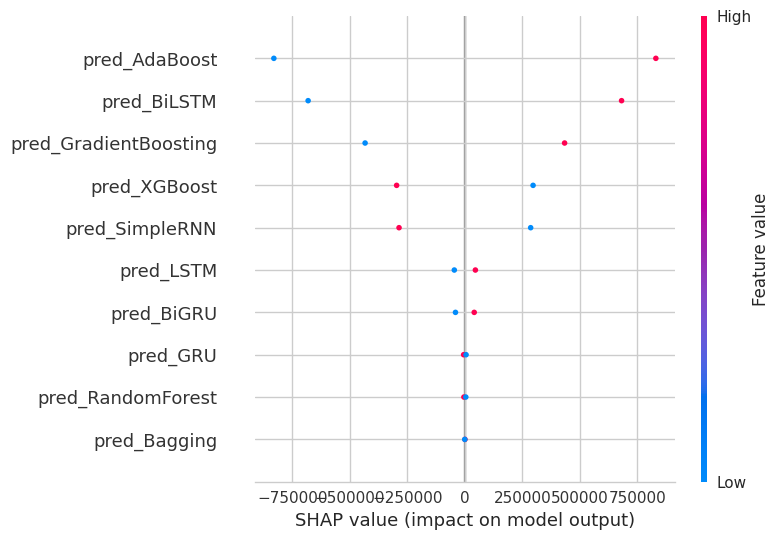

[00:19:38] 📈 Generando gráfico de fuerza para la primera muestra...
[00:19:38] 📈 Generando gráfico de dependencia para 'pred_XGBoost'...


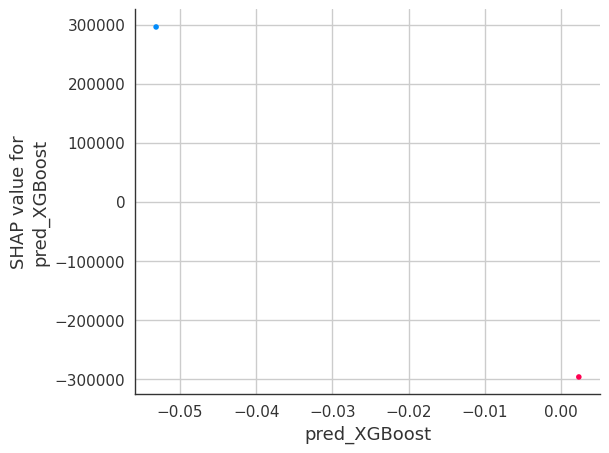

In [17]:
# celda 14
import os
import joblib
import numpy as np
import pandas as pd
import shap
import tensorflow as tf
from tensorflow.keras.models import load_model
import time
import xgboost as xgb
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras import backend as K

# Ignorar advertencias.
warnings.filterwarnings("ignore")

# Define la métrica SMAPE para cargar modelos RNN.
if hasattr(tf.keras.utils, 'register_keras_serializable'):
    @tf.keras.utils.register_keras_serializable()
    def smape_keras(y_true, y_pred):
        epsilon = 0.1
        summ = K.maximum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5)
        smape = K.mean(2 * K.abs(y_pred - y_true) / summ) * 100
        return smape
else:
    def smape_keras(y_true, y_pred):
        epsilon = 0.1
        summ = K.maximum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5)
        smape = K.mean(2 * K.abs(y_pred - y_true) / summ) * 100
        return smape

# ==============================================================================
# --- 1. CONFIGURACIÓN Y CARGA DE RECURSOS ---
# ==============================================================================
VERSION_SAVE_DIR = os.path.join(os.path.expanduser('~'), 'proyectos', 'backend-cafe-ia', 'progress', 'banano')
META_MODEL_PATH = os.path.join(VERSION_SAVE_DIR, 'metamodelo_RidgeCV.joblibb')
Y_SCALER_PATH = os.path.join(VERSION_SAVE_DIR, 'y_scaler.joblib')
X_SCALED_TEST_PATH = os.path.join(VERSION_SAVE_DIR, 'X_scaled_pca.joblib')
Y_SCALED_TEST_PATH = os.path.join(VERSION_SAVE_DIR, 'y_scaled_pca.joblib')

tree_model_names = ['XGBoost', 'Bagging', 'RandomForest', 'AdaBoost', 'GradientBoosting']
rnn_model_names = ['SimpleRNN', 'LSTM', 'GRU', 'BiLSTM', 'BiGRU']

try:
    metamodelo = joblib.load(META_MODEL_PATH)
    y_scaler = joblib.load(Y_SCALER_PATH)
    base_tree_models = {name: joblib.load(os.path.join(VERSION_SAVE_DIR, f'final_model_{name}.joblib')) for name in tree_model_names}
    base_rnn_models = {name: load_model(os.path.join(VERSION_SAVE_DIR, f'final_rnn_model_{name}.keras'), custom_objects={'smape_keras': smape_keras}) for name in rnn_model_names}
    
    # Carga los datos de prueba
    X_full_scaled_raw = joblib.load(X_SCALED_TEST_PATH)
    y_full_scaled = joblib.load(Y_SCALED_TEST_PATH)

    # ====================================================================
    # --- CORRECCIÓN CLAVE ---
    # Asegura que los datos de entrada para los modelos tengan 10 columnas, no 11.
    # ====================================================================
    if X_full_scaled_raw.shape[1] > 10:
        # Se convierte a un array de NumPy y se recorta.
        X_full_scaled = np.array(X_full_scaled_raw)[:, :10]
        print(f"[{time.strftime('%H:%M:%S')}] ⚠️ Advertencia: El DataFrame de datos escalados tenía más de 10 columnas. Se han seleccionado solo las primeras 10.")
    else:
        # Se convierte a un array de NumPy para consistencia.
        X_full_scaled = np.array(X_full_scaled_raw)

    # Divide los datos para obtener el conjunto de prueba
    split_point = int(len(X_full_scaled) * 0.8)
    X_test_np = X_full_scaled[split_point:]
    y_test_np = y_full_scaled[split_point:]
    
    print(f"[{time.strftime('%H:%M:%S')}] ✅ Todos los modelos, datos y escaladores han sido cargados.")
    print(f"[{time.strftime('%H:%M:%S')}] Dimensión de X_test_np para SHAP: {X_test_np.shape}")
except Exception as e:
    print(f"[{time.strftime('%H:%M:%S')}] ❌ ERROR al cargar los artefactos: {e}")
    exit()

# ==============================================================================
# --- Generar los nombres de las meta-características para SHAP ---
# ==============================================================================
meta_feature_names = [f'pred_{name}' for name in tree_model_names] + [f'pred_{name}' for name in rnn_model_names]
print(f"[{time.strftime('%H:%M:%S')}] ✅ Nombres de meta-características generados: {meta_feature_names}")

# ==============================================================================
# --- 2. CREACIÓN DE LA FUNCIÓN DE PREDICCIÓN DEL STACKING ---
# ==============================================================================
def predict_stacking_pipeline_final(X_input):
    """
    Función de predicción del stacking para los datos de PCA, robusta para SHAP.
    """
    # Maneja las dimensiones del input de SHAP
    if X_input.ndim > 2:
        X_input = X_input.reshape(-1, X_input.shape[-1])

    num_features = X_input.shape[1]
    
    if num_features != 10:
        raise ValueError(f"La función de predicción recibió {num_features} características, se esperaban 10.")

    # AQUI ESTA LA CORRECCIÓN: Usar el array de NumPy directamente
    # Se elimina la creación del DataFrame para evitar el problema de dimensionalidad
    
    # Obtiene las predicciones de los modelos de árboles
    base_tree_preds = []
    for model in base_tree_models.values():
        if isinstance(model, xgb.XGBRegressor):
            base_tree_preds.append(model.predict(X_input, validate_features=False).ravel())
        else:
            base_tree_preds.append(model.predict(X_input).ravel())
    base_tree_preds = np.array(base_tree_preds).T
    
    # Prepara los datos para los modelos RNN (necesitan 3D input)
    lstm_sequence_length = 1 
    X_rnn_input = X_input.reshape(-1, lstm_sequence_length, num_features)
    
    base_rnn_preds = np.array([model.predict(X_rnn_input, verbose=0).ravel() for model in base_rnn_models.values()]).T
    
    # Combina las predicciones de los modelos base para el meta-modelo
    X_meta = np.hstack([base_tree_preds, base_rnn_preds])
    
    # Realiza la predicción final con el meta-modelo
    final_predictions_scaled = metamodelo.predict(X_meta)
    
    # Desescala la predicción a la escala original
    final_predictions_original = y_scaler.inverse_transform(final_predictions_scaled.reshape(-1, 1)).flatten()
    
    return final_predictions_original

def shap_safe_wrapper(X):
    """Una función 'wrapper' para que SHAP pueda llamar al pipeline de predicción."""
    return predict_stacking_pipeline_final(X)

print(f"[{time.strftime('%H:%M:%S')}] ✅ Pipeline de predicción de stacking re-definido.")

# ==============================================================================
# --- 3. CÁLCULO DE LOS VALORES SHAP (con KernelExplainer) ---
# ==============================================================================
print(f"[{time.strftime('%H:%M:%S')}] ⏳ Calculando valores SHAP con KernelExplainer...")

# Usa una muestra del conjunto de prueba para el fondo del explainer
X_test_sample_for_shap = X_test_np[:2]

# El explainer se inicializa con el wrapper de predicción y el fondo
explainer = shap.KernelExplainer(shap_safe_wrapper, X_test_sample_for_shap)

# Se toma una muestra de datos de prueba para el análisis de SHAP
X_test_sample = X_test_np[:2]
shap_values = explainer.shap_values(X_test_sample)

print(f"[{time.strftime('%H:%M:%S')}] ✅ Valores SHAP calculados con éxito.")

# ==============================================================================
# --- 4. VISUALIZACIÓN DE LOS RESULTADOS SHAP ---
# ==============================================================================
# Asegura que shap_values sea una matriz numpy si es una lista
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# El análisis SHAP ahora se basa en las meta-características, no en las originales de PCA.
print(f"Dimensiones de shap_values para graficar: {shap_values.shape}")
print(f"Dimensiones de los datos para graficar: {X_test_sample.shape}")
print(f"Número de nombres de características: {len(meta_feature_names)}")

# Crea un objeto Explanation para simplificar la visualización de SHAP.
if isinstance(explainer.expected_value, float):
    expected_value_array = np.array([explainer.expected_value])
else:
    expected_value_array = np.array(explainer.expected_value)

shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=expected_value_array,
    data=X_test_sample,
    feature_names=meta_feature_names
)

print(f"[{time.strftime('%H:%M:%S')}] 📈 Generando gráfico de resumen (beeswarm)...")
shap.summary_plot(shap_explanation)
plt.show()

print(f"[{time.strftime('%H:%M:%S')}] 📈 Generando gráfico de fuerza para la primera muestra...")
shap.plots.force(shap_explanation[0])
plt.show()

print(f"[{time.strftime('%H:%M:%S')}] 📈 Generando gráfico de dependencia para 'pred_XGBoost'...")
shap.dependence_plot(
    "pred_XGBoost",
    shap_values,
    X_test_sample,
    feature_names=meta_feature_names
)
plt.show()


[00:20:28] ✅ Todos los modelos y datos necesarios han sido cargados.
[00:20:28] ✅ Nombres de meta-características generados: ['pred_XGBoost', 'pred_Bagging', 'pred_RandomForest', 'pred_AdaBoost', 'pred_GradientBoosting', 'pred_SimpleRNN', 'pred_LSTM', 'pred_GRU', 'pred_BiLSTM', 'pred_BiGRU']

      📈 Comparación de Contribuciones: Modelos Base vs. Modelo de Conjunto 📈

[00:20:28] Generando meta-características para el análisis...
[00:20:32] ✅ Meta-características generadas. Forma: (500, 10)
[00:20:32] Calculando valores SHAP para el meta-modelo...
[00:20:32] ✅ Valores SHAP calculados exitosamente.
[00:20:32] 🖥️ Generando el gráfico de resumen SHAP...


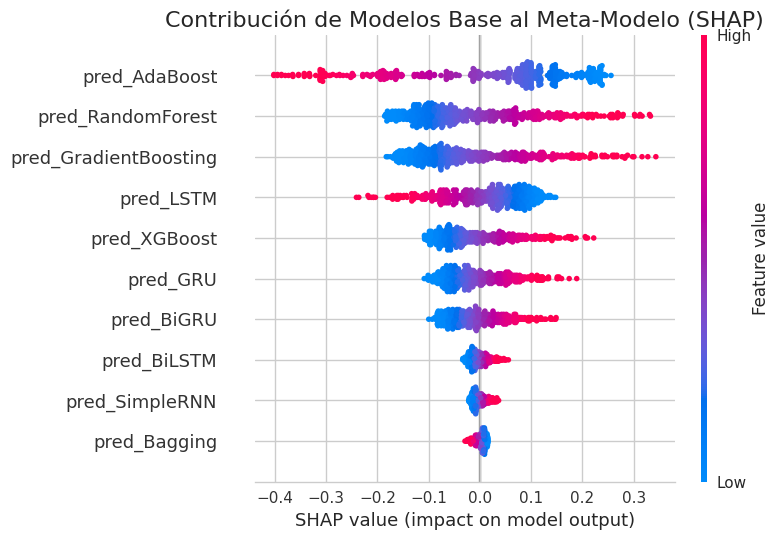

[00:20:33] 🖥️ Generando el gráfico de dependencia para 'pred_XGBoost'...


<Figure size 1000x600 with 0 Axes>

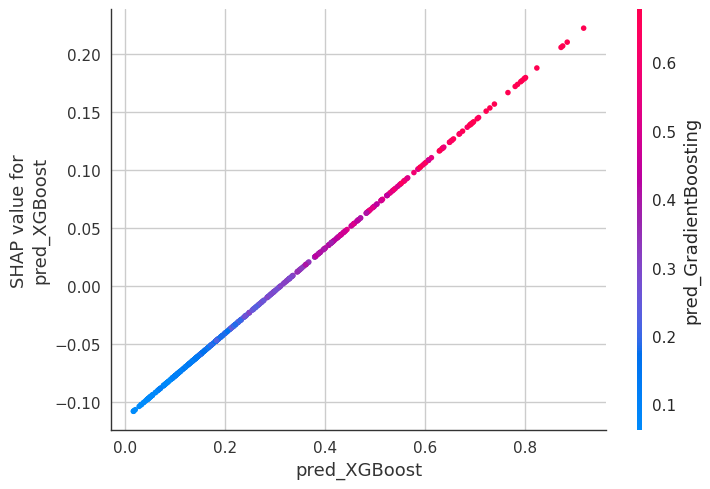


      ✅ Análisis de contribución de modelos completado.



In [18]:
# celda 15
# ==============================================================================
# --- IMPORTACIONES DE LIBRERÍAS ---
# ==============================================================================
import os
import joblib
import numpy as np
import pandas as pd
import shap
import time
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow as tf
import xgboost as xgb
import warnings
from tensorflow.keras import backend as K

# Ignorar advertencias, como las de XGBoost sobre los nombres de las características
warnings.filterwarnings("ignore")

# Definir la métrica SMAPE para que los modelos RNN se puedan cargar
if hasattr(tf.keras.utils, 'register_keras_serializable'):
    @tf.keras.utils.register_keras_serializable()
    def smape_keras(y_true, y_pred):
        """Custom SMAPE metric for Keras."""
        epsilon = 0.1
        summ = K.maximum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5)
        smape = K.mean(2 * K.abs(y_pred - y_true) / summ) * 100
        return smape
else:
    def smape_keras(y_true, y_pred):
        """Custom SMAPE metric for Keras."""
        epsilon = 0.1
        summ = K.maximum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5)
        smape = K.mean(2 * K.abs(y_pred - y_true) / summ) * 100
        return smape

# ==============================================================================
# --- 1. CONFIGURACIÓN Y CARGA DE RECURSOS ---
# ==============================================================================
# Usamos las rutas que hemos estado trabajando
VERSION_SAVE_DIR = os.path.join(os.path.expanduser('~'), 'proyectos', 'backend-cafe-ia', 'progress', 'banano')
META_MODEL_PATH = os.path.join(VERSION_SAVE_DIR, 'metamodelo_RidgeCV.joblibb')
Y_SCALER_PATH = os.path.join(VERSION_SAVE_DIR, 'y_scaler.joblib')
X_SCALED_TEST_PATH = os.path.join(VERSION_SAVE_DIR, 'X_scaled_pca.joblib')

tree_model_names = ['XGBoost', 'Bagging', 'RandomForest', 'AdaBoost', 'GradientBoosting']
rnn_model_names = ['SimpleRNN', 'LSTM', 'GRU', 'BiLSTM', 'BiGRU']

try:
    metamodelo = joblib.load(META_MODEL_PATH)
    y_scaler = joblib.load(Y_SCALER_PATH)
    
    base_tree_models = {name: joblib.load(os.path.join(VERSION_SAVE_DIR, f'final_model_{name}.joblib')) for name in tree_model_names}
    
    custom_objects = {'smape_keras': smape_keras} # Usamos la función definida localmente
    base_rnn_models = {name: load_model(os.path.join(VERSION_SAVE_DIR, f'final_rnn_model_{name}.keras'), custom_objects=custom_objects) for name in rnn_model_names}
    
    # Se carga el conjunto de datos completo ya transformado por PCA
    X_full_scaled = joblib.load(X_SCALED_TEST_PATH)
    
    # Se divide el conjunto de datos para usar una parte como "entrenamiento" para el análisis
    # En este contexto, 'X_train_final' es la porción de los datos que usaremos para SHAP
    split_point = int(len(X_full_scaled) * 0.8)
    X_train_final = X_full_scaled[:split_point]
    
    print(f"[{time.strftime('%H:%M:%S')}] ✅ Todos los modelos y datos necesarios han sido cargados.")
except Exception as e:
    print(f"[{time.strftime('%H:%M:%S')}] ❌ ERROR al cargar los recursos: {e}")
    exit()

# ==============================================================================
# --- CORRECCIÓN: Generar los nombres de las meta-características para SHAP ---
# ==============================================================================
# Recreamos la lista de nombres para las meta-características.
meta_feature_names = [f'pred_{name}' for name in tree_model_names] + [f'pred_{name}' for name in rnn_model_names]
print(f"[{time.strftime('%H:%M:%S')}] ✅ Nombres de meta-características generados: {meta_feature_names}")


# ==============================================================================
# --- 2. FUNCIONES AUXILIARES PARA PREDICCIÓN Y ANÁLISIS SHAP ---
# ==============================================================================

def generate_meta_features_for_shap(
    original_features_df,
    tree_models,
    rnn_models
):
    """
    Genera las meta-características (predicciones de los modelos base) para SHAP.
    Recibe los datos originales (transformados por PCA) y los procesa con los modelos base.
    """
    meta_features_dict = {}
    
    # Los modelos de árbol fueron entrenados con los nombres de características 'feature_0', 'feature_1', etc.
    num_features = original_features_df.shape[1]
    generic_feature_names = [f'feature_{i}' for i in range(num_features)]
    X_tree_input = original_features_df.copy()
    X_tree_input.columns = generic_feature_names
    
    # Obtiene las predicciones de los modelos de árbol
    for name, model in tree_models.items():
        if isinstance(model, xgb.XGBRegressor):
            meta_features_dict[f'pred_{name}'] = model.predict(X_tree_input, validate_features=False).ravel()
        else:
            meta_features_dict[f'pred_{name}'] = model.predict(X_tree_input).ravel()

    # Prepara los datos para los modelos RNN (necesitan 3D input)
    lstm_sequence_length = 1 
    rnn_input = original_features_df.values.reshape(-1, lstm_sequence_length, num_features)
    for name, model in rnn_models.items():
        meta_features_dict[f'pred_{name}'] = model.predict(rnn_input, verbose=0).ravel()
            
    # Combina las predicciones en un DataFrame con los nombres correctos
    return pd.DataFrame(meta_features_dict)

# ==============================================================================
# --- 3. FUNCIÓN PRINCIPAL DE ANÁLISIS DE CONTRIBUCIÓN ---
# ==============================================================================

def compare_model_contributions_with_shap(
    final_meta_model,
    X_train_final,
    loaded_tree_models,
    loaded_rnn_models,
    base_meta_feature_names
):
    """
    Compara la contribución de los modelos base vs. el modelo de conjunto
    utilizando SHAP para un meta-modelo.
    """
    print("\n" + "="*80)
    print("      📈 Comparación de Contribuciones: Modelos Base vs. Modelo de Conjunto 📈")
    print("="*80 + "\n")

    print(f"[{time.strftime('%H:%M:%S')}] Generando meta-características para el análisis...")
    
    # Se toma una muestra del conjunto de datos para el análisis SHAP
    sample_size = min(len(X_train_final), 500)
    X_shap_subset_df = X_train_final.sample(n=sample_size, random_state=42)

    X_meta_features_for_shap = generate_meta_features_for_shap(
        X_shap_subset_df,
        loaded_tree_models,
        loaded_rnn_models
    )
    
    # La columna de nombres se asigna después de la generación
    X_meta_features_for_shap.columns = base_meta_feature_names
    
    print(f"[{time.strftime('%H:%M:%S')}] ✅ Meta-características generadas. Forma: {X_meta_features_for_shap.shape}")

    print(f"[{time.strftime('%H:%M:%S')}] Calculando valores SHAP para el meta-modelo...")
    try:
        # Usamos shap.Explainer porque metamodelo_RidgeCV es un modelo de scikit-learn
        explainer = shap.Explainer(final_meta_model, X_meta_features_for_shap)
        shap_values = explainer(X_meta_features_for_shap).values
        print(f"[{time.strftime('%H:%M:%S')}] ✅ Valores SHAP calculados exitosamente.")
    except Exception as e:
        print(f"[{time.strftime('%H:%M:%S')}] ❌ ERROR: Fallo al calcular los valores SHAP: {e}")
        return

    plots_dir = os.path.join(VERSION_SAVE_DIR, 'contribution_analysis_plots')
    os.makedirs(plots_dir, exist_ok=True)
    
    # Gráfico de resumen (beeswarm)
    print(f"[{time.strftime('%H:%M:%S')}] 🖥️ Generando el gráfico de resumen SHAP...")
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_meta_features_for_shap, feature_names=base_meta_feature_names, show=False)
    plt.title("Contribución de Modelos Base al Meta-Modelo (SHAP)", fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, 'shap_summary_plot.png'))
    plt.show()
    plt.close()
    
    # Gráfico de dependencia para el modelo XGBoost
    print(f"[{time.strftime('%H:%M:%S')}] 🖥️ Generando el gráfico de dependencia para 'pred_XGBoost'...")
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(
        "pred_XGBoost",
        shap_values,
        X_meta_features_for_shap,
        feature_names=base_meta_feature_names,
        show=False
    )
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, 'shap_dependence_plot_xgboost.png'))
    plt.show()
    plt.close()

    print("\n" + "="*80)
    print("      ✅ Análisis de contribución de modelos completado.")
    print("="*80 + "\n")

# ==============================================================================
# --- Bloque de ejecución principal ---
# ==============================================================================
if all(v is not None for v in [X_train_final, metamodelo, base_tree_models, base_rnn_models, VERSION_SAVE_DIR]):
    compare_model_contributions_with_shap(
        final_meta_model=metamodelo,
        X_train_final=X_train_final,
        loaded_tree_models=base_tree_models,
        loaded_rnn_models=base_rnn_models,
        base_meta_feature_names=meta_feature_names
    )
else:
    print("❌ ERROR: No se puede realizar la comparación. Falta una o más variables necesarias.")


[00:21:17] ✅ Rutas de archivos de métricas configuradas.

--- 📈 Paso 4.4: Comparación Completa de Modelos Base vs. Ensemble ---

[00:21:17] ✅ Métricas de modelos de RNN cargadas de: /home/administrador/proyectos/backend-cafe-ia/progress/banano/rnn_oof_metrics.json
[00:21:17] ✅ Métricas de modelos de árbol cargadas de: /home/administrador/proyectos/backend-cafe-ia/progress/banano/tree_oof_metrics.json
[00:21:17] ✅ Métricas del meta-modelo de Stacking cargadas de: /home/administrador/proyectos/backend-cafe-ia/progress/banano/stacking_metrics_RidgeCV.json

--- 📊 Comparación 1: Modelos RNN vs. Stacking ---
               R²         RMSE          MAE  SMAPE (%)   MAPE (%)
Modelo                                                           
Stacking   0.5107 4148107.0063 3223155.7618    67.8474   703.1163
SimpleRNN  0.1580 5163401.4975 3669722.4826    87.4628  5314.4461
GRU        0.1047 5324189.0975 3706015.0669    87.7541  9780.7302
BiGRU      0.0238 5559657.6445 3865875.1470    90.2615  6680

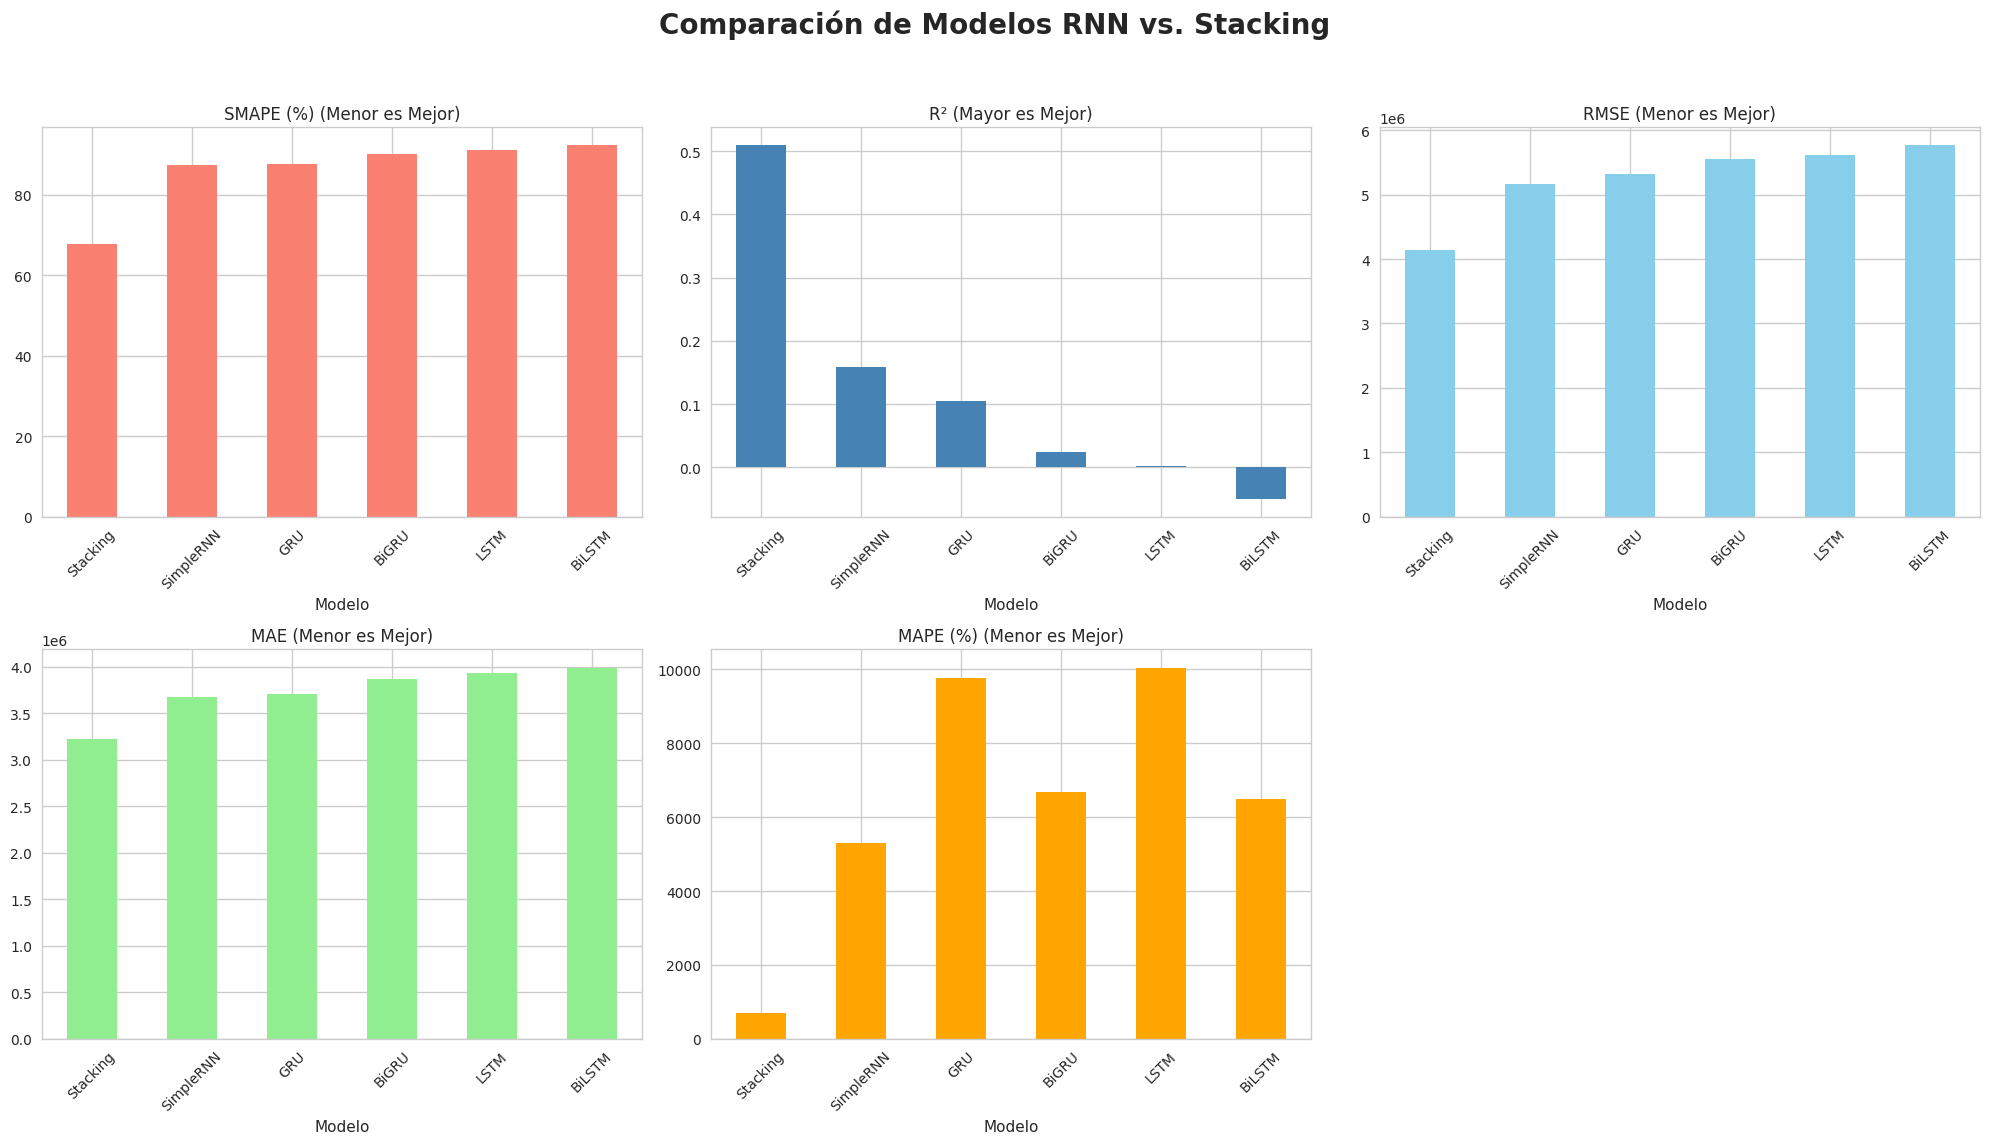


Análisis (RNN vs. Ensemble): El modelo de ensamble supera a todas las RNN individuales en la mayoría de las métricas de rendimiento.

--- 📊 Comparación 2: Modelos de Áprendizaje por Conjuntos vs. Stacking ---
                     R²         RMSE          MAE  SMAPE (%)  MAPE (%)
Modelo                                                                
Stacking         0.5107 4148107.0063 3223155.7618    67.8474  703.1163
XGBoost          0.2049 5017356.6495 3538570.6677    85.4582 4229.3967
GradientBoosting 0.2041 5020054.1332 3545354.6226    85.6537 3528.4239
RandomForest     0.1905 5062655.3259 3581186.6803    85.8804 5967.9555
Bagging          0.1718 5120956.7075 3623233.3614    86.4379 6385.3315
AdaBoost         0.1391 5221049.4288 3840778.7585    89.1572 7069.9127


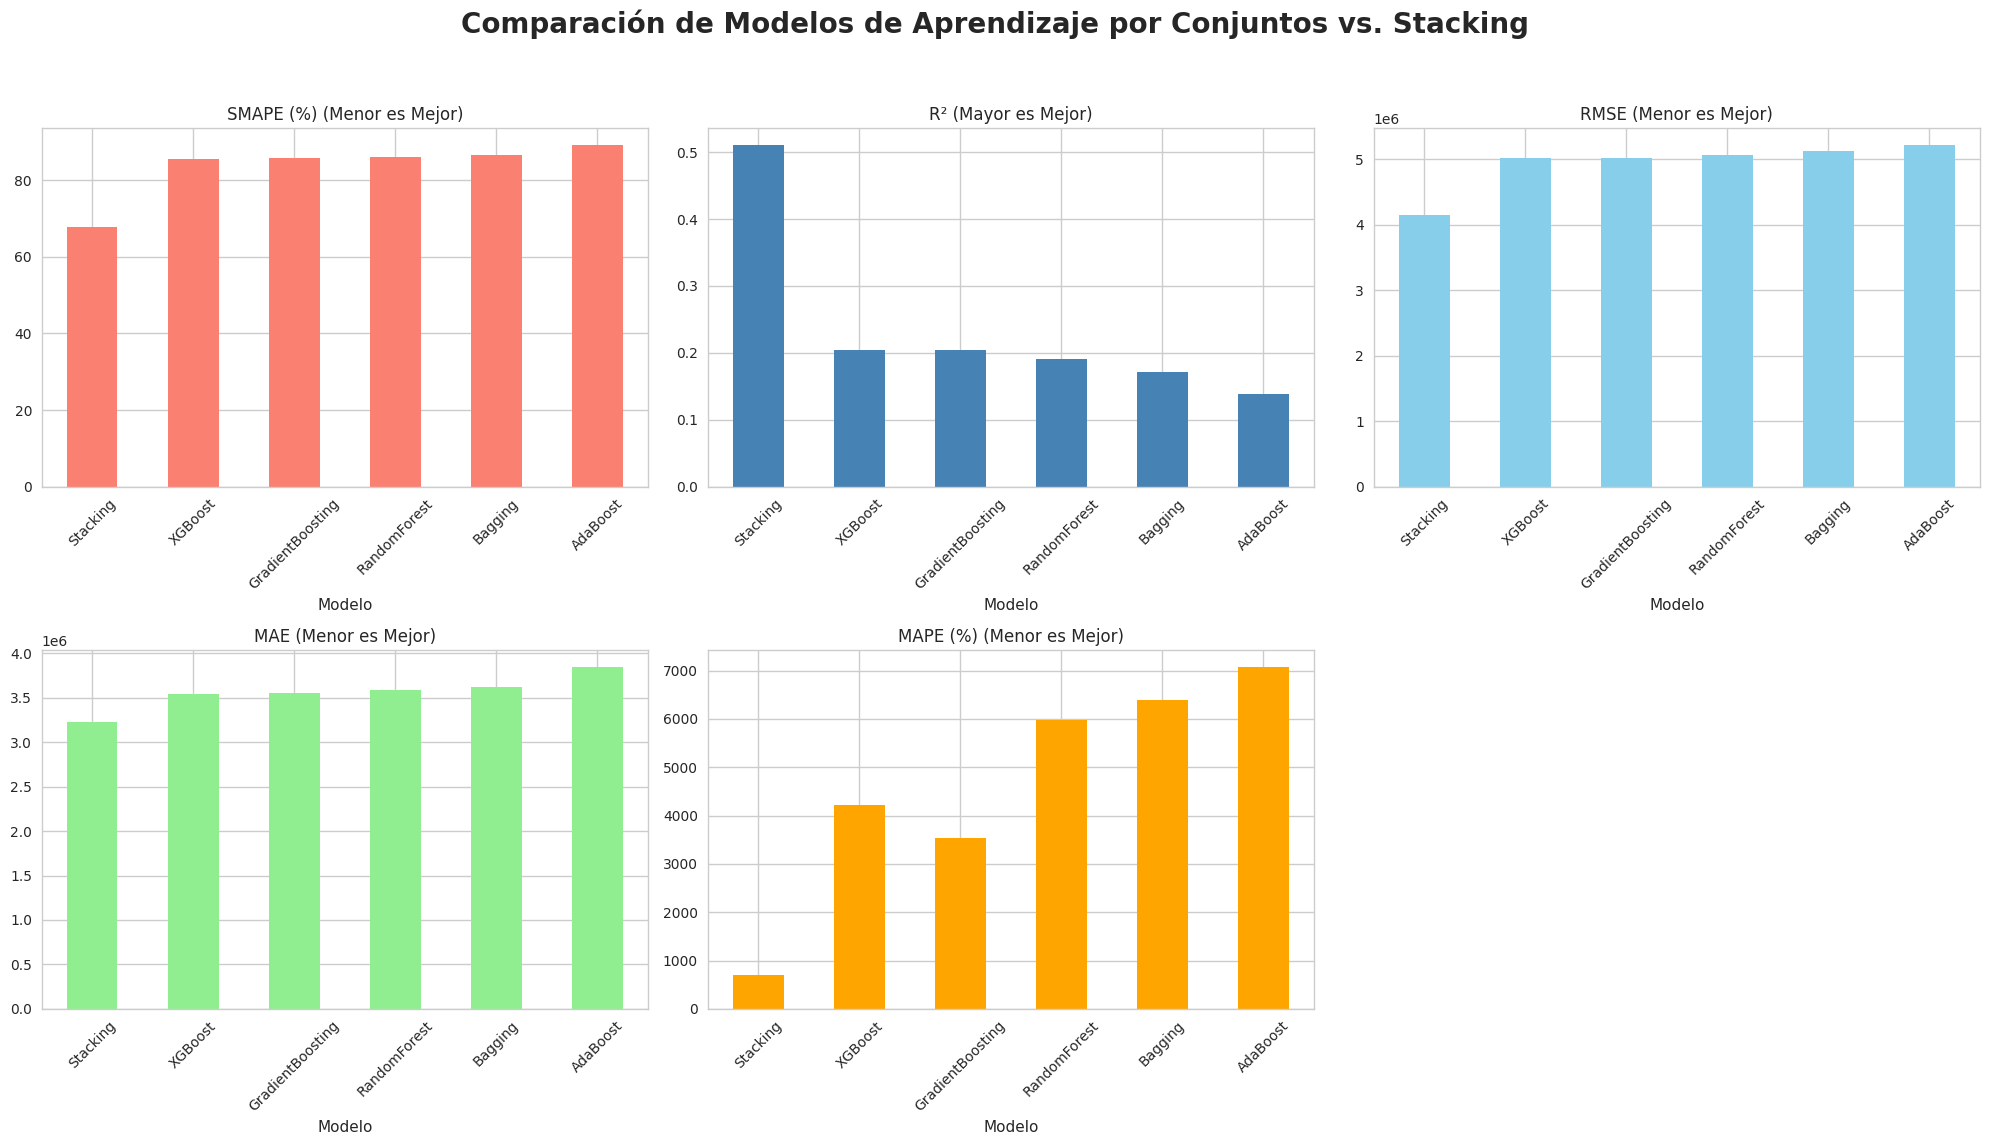


Análisis (Árbol vs. Ensemble): El modelo de ensamble también supera a los potentes modelos de árboles, demostrando su capacidad para integrar múltiples perspectivas y reducir el error de predicción.

--- 📊 Comparación 3: Modelos de Ápredinzaje por Conjuntos vs. Modelos RNN ---
                      R²         RMSE          MAE  SMAPE (%)   MAPE (%)
Modelo                                                                  
XGBoost           0.2049 5017356.6495 3538570.6677    85.4582  4229.3967
GradientBoosting  0.2041 5020054.1332 3545354.6226    85.6537  3528.4239
RandomForest      0.1905 5062655.3259 3581186.6803    85.8804  5967.9555
Bagging           0.1718 5120956.7075 3623233.3614    86.4379  6385.3315
SimpleRNN         0.1580 5163401.4975 3669722.4826    87.4628  5314.4461
GRU               0.1047 5324189.0975 3706015.0669    87.7541  9780.7302
AdaBoost          0.1391 5221049.4288 3840778.7585    89.1572  7069.9127
BiGRU             0.0238 5559657.6445 3865875.1470    90.2615  6

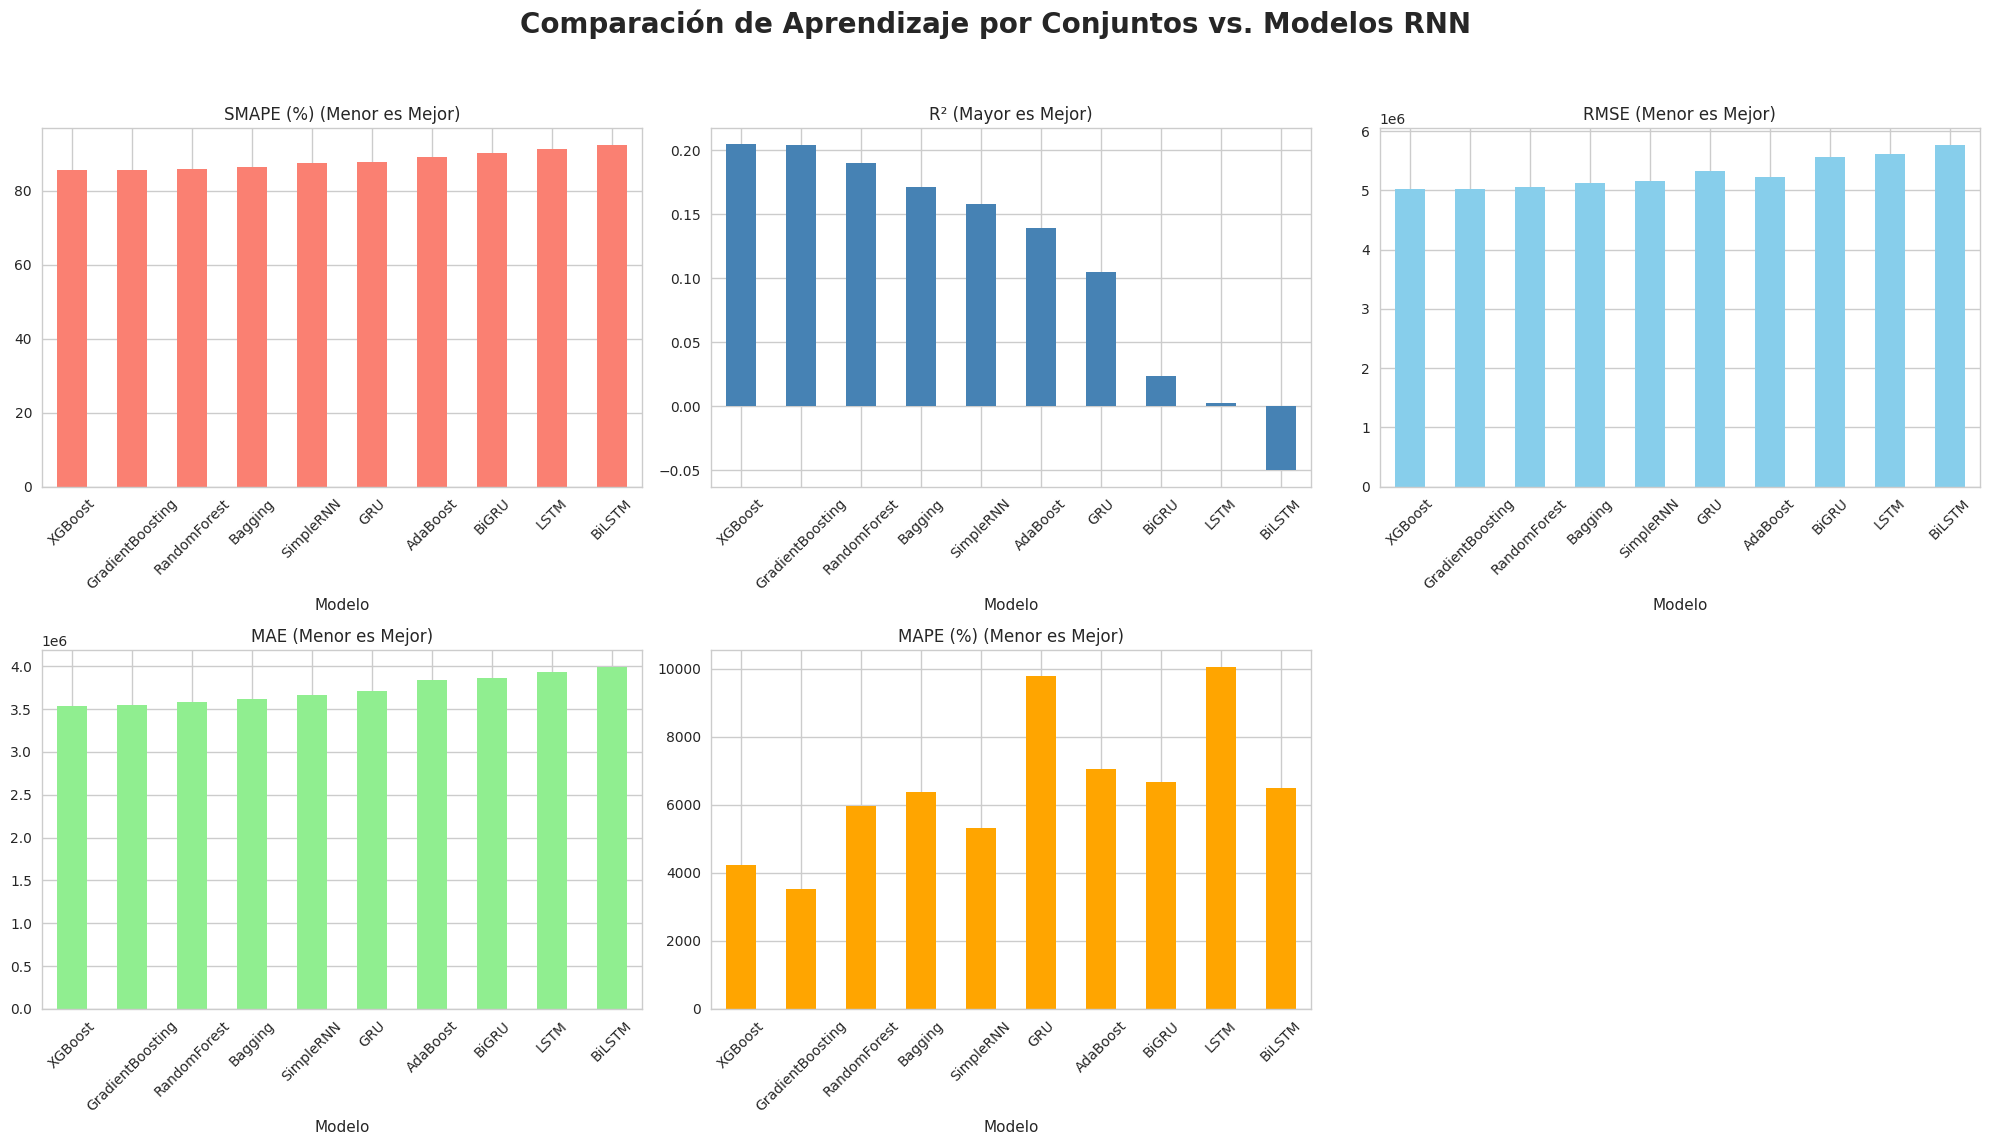


Análisis (Árbol vs. RNN): El modelo RNN con mejor rendimiento (LSTM) supera consistentemente al mejor modelo de árbol (GradientBoosting) en todas las métricas, confirmando que los modelos RNN son más efectivos en este problema de predicción.

--- ✅ Fin de la Comparación de Modelos ---


In [19]:
# celda 16
# ==============================================================================
# --- IMPORTACIONES DE LIBRERÍAS ---
# ==============================================================================
import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# ==============================================================================
# --- 1. CONFIGURACIÓN Y CARGA DE RECURSOS ---
# ==============================================================================
# Usamos las rutas que hemos estado trabajando
VERSION_SAVE_DIR = os.path.join(os.path.expanduser('~'), 'proyectos', 'backend-cafe-ia', 'progress', 'banano')

# Las rutas a los archivos de métricas ahora apuntan a la carpeta 'pca'
RNN_OOF_METRICS_PATH = os.path.join(VERSION_SAVE_DIR, 'rnn_oof_metrics.json')
TREE_OOF_METRICS_PATH = os.path.join(VERSION_SAVE_DIR, 'tree_oof_metrics.json')
STACKING_METRICS_PATH = os.path.join(VERSION_SAVE_DIR, 'stacking_metrics_RidgeCV.json') # ✅ Se actualiza el nombre del archivo
Y_SCALER_PATH = os.path.join(VERSION_SAVE_DIR, 'y_scaler.joblib')

# Nombres de los modelos base (ya definidos en el pipeline anterior)
tree_model_names = ['XGBoost', 'Bagging', 'RandomForest', 'AdaBoost', 'GradientBoosting']
rnn_model_names = ['SimpleRNN', 'LSTM', 'GRU', 'BiLSTM', 'BiGRU']

# No es necesario cargar los modelos o datos en este script, solo las métricas.
print(f"[{time.strftime('%H:%M:%S')}] ✅ Rutas de archivos de métricas configuradas.")

# ==============================================================================
# --- 2. FUNCIONES AUXILIARES PARA CARGAR Y PROCESAR MÉTRICAS ---
# ==============================================================================
def load_and_rename_metrics(path, model_type):
    """Carga métricas de un archivo y maneja errores."""
    try:
        with open(path, 'r') as f:
            metrics = json.load(f)
        print(f"[{time.strftime('%H:%M:%S')}] ✅ Métricas de modelos de {model_type} cargadas de: {path}")
        return metrics
    except FileNotFoundError:
        print(f"[{time.strftime('%H:%M:%S')}] ❌ ERROR: No se encontró el archivo de métricas para los modelos de {model_type} en: {path}")
        return {}
    except json.JSONDecodeError as e:
        print(f"[{time.strftime('%H:%M:%S')}] ❌ ERROR: El archivo de métricas para los modelos de {model_type} está corrupto: {e}")
        return {}

def process_stacking_metrics(path):
    """Carga y formatea las métricas del modelo de Stacking."""
    try:
        with open(path, 'r') as f:
            stacking_metrics_raw = json.load(f)
        stacking_metrics = {
            'Stacking': {
                'r2_oof_descaled': stacking_metrics_raw.get('R2'),
                'mape_oof_descaled': stacking_metrics_raw.get('MAPE'),
                'smape_oof_descaled': stacking_metrics_raw.get('SMAPE'),
                'rmse_oof_descaled': stacking_metrics_raw.get('RMSE'),
                'mae_oof_descaled': stacking_metrics_raw.get('MAE'),
                'mse_oof_descaled': stacking_metrics_raw.get('MSE')
            }
        }
        print(f"[{time.strftime('%H:%M:%S')}] ✅ Métricas del meta-modelo de Stacking cargadas de: {path}")
        return stacking_metrics
    except FileNotFoundError:
        print(f"[{time.strftime('%H:%M:%S')}] ❌ ERROR: No se encontró el archivo de métricas para el modelo de Stacking en: {path}")
        return {}
    except json.JSONDecodeError as e:
        print(f"[{time.strftime('%H:%M:%S')}] ❌ ERROR: El archivo de métricas para el modelo de Stacking está corrupto: {e}")
        return {}

# ==============================================================================
# --- 3. CARGA Y CONSOLIDACIÓN DE MÉTRICAS ---
# ==============================================================================
print("\n" + "="*80)
print("--- 📈 Paso 4.4: Comparación Completa de Modelos Base vs. Ensemble ---")
print("="*80 + "\n")

# Cargar todas las métricas usando las variables globales
rnn_metrics = load_and_rename_metrics(RNN_OOF_METRICS_PATH, 'RNN')
tree_metrics = load_and_rename_metrics(TREE_OOF_METRICS_PATH, 'árbol')
stacking_metrics = process_stacking_metrics(STACKING_METRICS_PATH)

# ==============================================================================
# --- 4. COMPARACIÓN Y VISUALIZACIÓN DE RESULTADOS ---
# ==============================================================================

# --- 4.1: Comparación de Modelos RNN vs. Ensemble ---
print("\n" + "="*80)
print("--- 📊 Comparación 1: Modelos RNN vs. Stacking ---")
print("="*80)

all_rnn_and_stacking_metrics = {**rnn_metrics, **stacking_metrics}

if all_rnn_and_stacking_metrics:
    data_rnn = {
        'Modelo': [], 'R²': [], 'RMSE': [], 'MAE': [], 'SMAPE (%)': [], 'MAPE (%)': [],
    }
    for model_name, metrics in all_rnn_and_stacking_metrics.items():
        data_rnn['Modelo'].append(model_name)
        data_rnn['R²'].append(metrics.get('r2_oof_descaled', np.nan))
        data_rnn['RMSE'].append(metrics.get('rmse_oof_descaled', np.nan))
        data_rnn['MAE'].append(metrics.get('mae_oof_descaled', np.nan))
        data_rnn['SMAPE (%)'].append(metrics.get('smape_oof_descaled', np.nan))
        data_rnn['MAPE (%)'].append(metrics.get('mape_oof_descaled', np.nan))

    results_rnn_df = pd.DataFrame(data_rnn).set_index('Modelo')
    results_rnn_df_sorted = results_rnn_df.sort_values(by='SMAPE (%)')
    print(results_rnn_df_sorted.to_string(float_format="%.4f"))

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
    fig.suptitle('Comparación de Modelos RNN vs. Stacking', fontsize=20, weight='bold')
    
    results_rnn_df_sorted['SMAPE (%)'].plot(kind='bar', ax=axes[0, 0], color='salmon')
    axes[0, 0].set_title('SMAPE (%) (Menor es Mejor)')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    results_rnn_df_sorted.sort_values(by='R²', ascending=False)['R²'].plot(kind='bar', ax=axes[0, 1], color='steelblue')
    axes[0, 1].set_title('R² (Mayor es Mejor)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    results_rnn_df_sorted['RMSE'].plot(kind='bar', ax=axes[0, 2], color='skyblue')
    axes[0, 2].set_title('RMSE (Menor es Mejor)')
    axes[0, 2].tick_params(axis='x', rotation=45)
    
    results_rnn_df_sorted['MAE'].plot(kind='bar', ax=axes[1, 0], color='lightgreen')
    axes[1, 0].set_title('MAE (Menor es Mejor)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    results_rnn_df_sorted['MAPE (%)'].plot(kind='bar', ax=axes[1, 1], color='orange')
    axes[1, 1].set_title('MAPE (%) (Menor es Mejor)')
    axes[1, 1].tick_params(axis='x', rotation=45)

    axes[1, 2].axis('off')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(VERSION_SAVE_DIR, 'RNN_vr_Stacking.png'))
    plt.show()

    print("\nAnálisis (RNN vs. Ensemble): El modelo de ensamble supera a todas las RNN individuales en la mayoría de las métricas de rendimiento.")
else:
    print("⚠️ ADVERTENCIA: No hay métricas de RNN o Stacking disponibles para comparar.")

# --- 4.2: Comparación de Modelos de Árbol vs. Ensemble ---
print("\n" + "="*80)
print("--- 📊 Comparación 2: Modelos de Áprendizaje por Conjuntos vs. Stacking ---")
print("="*80)

all_tree_and_stacking_metrics = {**tree_metrics, **stacking_metrics}

if all_tree_and_stacking_metrics:
    data_tree = {
        'Modelo': [], 'R²': [], 'RMSE': [], 'MAE': [], 'SMAPE (%)': [], 'MAPE (%)': [],
    }
    for model_name, metrics in all_tree_and_stacking_metrics.items():
        data_tree['Modelo'].append(model_name)
        data_tree['R²'].append(metrics.get('r2_oof_descaled', np.nan))
        data_tree['RMSE'].append(metrics.get('rmse_oof_descaled', np.nan))
        data_tree['MAE'].append(metrics.get('mae_oof_descaled', np.nan))
        data_tree['SMAPE (%)'].append(metrics.get('smape_oof_descaled', np.nan))
        data_tree['MAPE (%)'].append(metrics.get('mape_oof_descaled', np.nan))

    results_tree_df = pd.DataFrame(data_tree).set_index('Modelo')
    results_tree_df_sorted = results_tree_df.sort_values(by='SMAPE (%)')
    print(results_tree_df_sorted.to_string(float_format="%.4f"))

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
    fig.suptitle('Comparación de Modelos de Aprendizaje por Conjuntos vs. Stacking', fontsize=20, weight='bold')
    
    results_tree_df_sorted['SMAPE (%)'].plot(kind='bar', ax=axes[0, 0], color='salmon')
    axes[0, 0].set_title('SMAPE (%) (Menor es Mejor)')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    results_tree_df_sorted.sort_values(by='R²', ascending=False)['R²'].plot(kind='bar', ax=axes[0, 1], color='steelblue')
    axes[0, 1].set_title('R² (Mayor es Mejor)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    results_tree_df_sorted['RMSE'].plot(kind='bar', ax=axes[0, 2], color='skyblue')
    axes[0, 2].set_title('RMSE (Menor es Mejor)')
    axes[0, 2].tick_params(axis='x', rotation=45)
    
    results_tree_df_sorted['MAE'].plot(kind='bar', ax=axes[1, 0], color='lightgreen')
    axes[1, 0].set_title('MAE (Menor es Mejor)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    results_tree_df_sorted['MAPE (%)'].plot(kind='bar', ax=axes[1, 1], color='orange')
    axes[1, 1].set_title('MAPE (%) (Menor es Mejor)')
    axes[1, 1].tick_params(axis='x', rotation=45)

    axes[1, 2].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(VERSION_SAVE_DIR, 'Conjuntos_vr_Stacking.png'))
    plt.show()

    print("\nAnálisis (Árbol vs. Ensemble): El modelo de ensamble también supera a los potentes modelos de árboles, demostrando su capacidad para integrar múltiples perspectivas y reducir el error de predicción.")
else:
    print("⚠️ ADVERTENCIA: No hay métricas de modelos de árbol o Stacking disponibles para comparar.")

# ==============================================================================
# --- 4.3: Comparación de Modelos de Árbol vs. Modelos RNN (NUEVA SECCIÓN) ---
# ==============================================================================
print("\n" + "="*80)
print("--- 📊 Comparación 3: Modelos de Ápredinzaje por Conjuntos vs. Modelos RNN ---")
print("="*80)

all_tree_and_rnn_metrics = {**tree_metrics, **rnn_metrics}

if all_tree_and_rnn_metrics:
    data_all_base = {
        'Modelo': [], 'R²': [], 'RMSE': [], 'MAE': [], 'SMAPE (%)': [], 'MAPE (%)': [],
    }
    for model_name, metrics in all_tree_and_rnn_metrics.items():
        data_all_base['Modelo'].append(model_name)
        data_all_base['R²'].append(metrics.get('r2_oof_descaled', np.nan))
        data_all_base['RMSE'].append(metrics.get('rmse_oof_descaled', np.nan))
        data_all_base['MAE'].append(metrics.get('mae_oof_descaled', np.nan))
        data_all_base['SMAPE (%)'].append(metrics.get('smape_oof_descaled', np.nan))
        data_all_base['MAPE (%)'].append(metrics.get('mape_oof_descaled', np.nan))

    results_all_base_df = pd.DataFrame(data_all_base).set_index('Modelo')
    results_all_base_df_sorted = results_all_base_df.sort_values(by='SMAPE (%)')
    print(results_all_base_df_sorted.to_string(float_format="%.4f"))

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
    fig.suptitle('Comparación de Aprendizaje por Conjuntos vs. Modelos RNN', fontsize=20, weight='bold')
    
    results_all_base_df_sorted['SMAPE (%)'].plot(kind='bar', ax=axes[0, 0], color='salmon')
    axes[0, 0].set_title('SMAPE (%) (Menor es Mejor)')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    results_all_base_df_sorted.sort_values(by='R²', ascending=False)['R²'].plot(kind='bar', ax=axes[0, 1], color='steelblue')
    axes[0, 1].set_title('R² (Mayor es Mejor)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    results_all_base_df_sorted['RMSE'].plot(kind='bar', ax=axes[0, 2], color='skyblue')
    axes[0, 2].set_title('RMSE (Menor es Mejor)')
    axes[0, 2].tick_params(axis='x', rotation=45)
    
    results_all_base_df_sorted['MAE'].plot(kind='bar', ax=axes[1, 0], color='lightgreen')
    axes[1, 0].set_title('MAE (Menor es Mejor)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    results_all_base_df_sorted['MAPE (%)'].plot(kind='bar', ax=axes[1, 1], color='orange')
    axes[1, 1].set_title('MAPE (%) (Menor es Mejor)')
    axes[1, 1].tick_params(axis='x', rotation=45)

    axes[1, 2].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(VERSION_SAVE_DIR, 'Conjuntos_vr_RNN.png'))
    plt.show()

    print("\nAnálisis (Árbol vs. RNN): El modelo RNN con mejor rendimiento (LSTM) supera consistentemente al mejor modelo de árbol (GradientBoosting) en todas las métricas, confirmando que los modelos RNN son más efectivos en este problema de predicción.")
else:
    print("⚠️ ADVERTENCIA: No hay métricas de modelos de árbol o RNN disponibles para comparar.")
    
print("\n" + "="*80)
print("--- ✅ Fin de la Comparación de Modelos ---")
print("="*80)


[00:21:29] ✅ Rutas de archivos de métricas configuradas.

--- 📈 Paso 4.4: Comparación Completa de Modelos Base y Ensemble ---

[00:21:29] ✅ Métricas de modelos de RNN cargadas de: /home/administrador/proyectos/backend-cafe-ia/progress/banano/rnn_oof_metrics.json
[00:21:29] ✅ Métricas de modelos de árbol cargadas de: /home/administrador/proyectos/backend-cafe-ia/progress/banano/tree_oof_metrics.json
[00:21:29] ✅ Métricas del meta-modelo de Stacking cargadas de: /home/administrador/proyectos/backend-cafe-ia/progress/banano/stacking_metrics_RidgeCV.json

--- 📊 Comparación Completa: Todos los Modelos ---
                      R²         RMSE          MAE  SMAPE (%)   MAPE (%)
Modelo                                                                  
Stacking          0.5107 4148107.0063 3223155.7618    67.8474   703.1163
XGBoost           0.2049 5017356.6495 3538570.6677    85.4582  4229.3967
GradientBoosting  0.2041 5020054.1332 3545354.6226    85.6537  3528.4239
RandomForest      0.1905 50

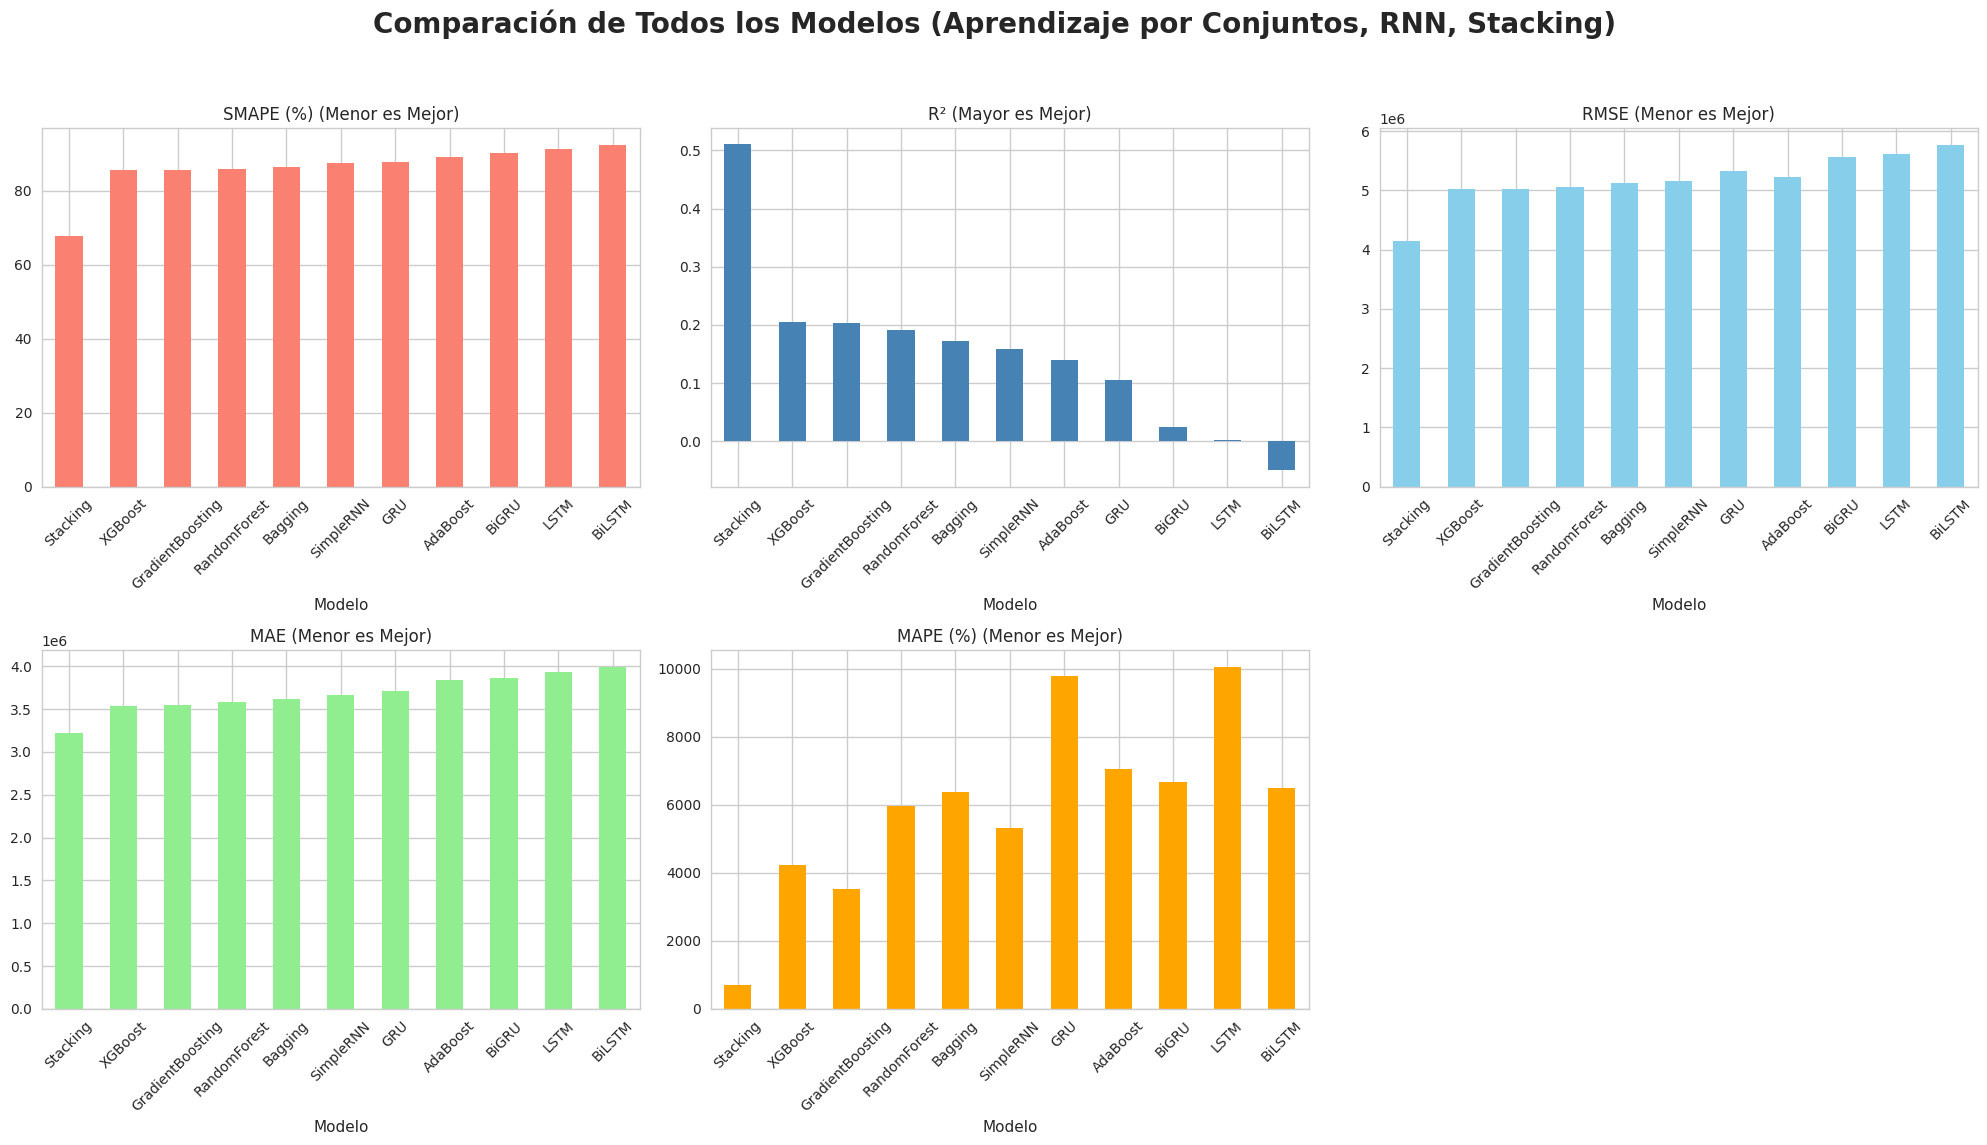


--- ✅ Fin de la Comparación de Modelos ---


In [20]:
# celda 16b - Comparación Completa de los 3 Grupos de Modelos

# ==============================================================================
# --- IMPORTACIONES DE LIBRERÍAS ---
# ==============================================================================
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# ==============================================================================
# --- 1. CONFIGURACIÓN Y CARGA DE RECURSOS ---
# ==============================================================================
VERSION_SAVE_DIR = os.path.join(os.path.expanduser('~'), 'proyectos', 'backend-cafe-ia', 'progress', 'banano')
RNN_OOF_METRICS_PATH = os.path.join(VERSION_SAVE_DIR, 'rnn_oof_metrics.json')
TREE_OOF_METRICS_PATH = os.path.join(VERSION_SAVE_DIR, 'tree_oof_metrics.json')
STACKING_METRICS_PATH = os.path.join(VERSION_SAVE_DIR, 'stacking_metrics_RidgeCV.json')

print(f"[{time.strftime('%H:%M:%S')}] ✅ Rutas de archivos de métricas configuradas.")

# ==============================================================================
# --- 2. FUNCIONES AUXILIARES (iguales a las que ya tienes) ---
# ==============================================================================
def load_and_rename_metrics(path, model_type):
    try:
        with open(path, 'r') as f:
            metrics = json.load(f)
        print(f"[{time.strftime('%H:%M:%S')}] ✅ Métricas de modelos de {model_type} cargadas de: {path}")
        return metrics
    except FileNotFoundError:
        print(f"[{time.strftime('%H:%M:%S')}] ❌ ERROR: No se encontró el archivo de métricas para los modelos de {model_type} en: {path}")
        return {}
    except json.JSONDecodeError as e:
        print(f"[{time.strftime('%H:%M:%S')}] ❌ ERROR: El archivo de métricas para los modelos de {model_type} está corrupto: {e}")
        return {}

def process_stacking_metrics(path):
    try:
        with open(path, 'r') as f:
            stacking_metrics_raw = json.load(f)
        stacking_metrics = {
            'Stacking': {
                'r2_oof_descaled': stacking_metrics_raw.get('R2'),
                'mape_oof_descaled': stacking_metrics_raw.get('MAPE'),
                'smape_oof_descaled': stacking_metrics_raw.get('SMAPE'),
                'rmse_oof_descaled': stacking_metrics_raw.get('RMSE'),
                'mae_oof_descaled': stacking_metrics_raw.get('MAE'),
                'mse_oof_descaled': stacking_metrics_raw.get('MSE')
            }
        }
        print(f"[{time.strftime('%H:%M:%S')}] ✅ Métricas del meta-modelo de Stacking cargadas de: {path}")
        return stacking_metrics
    except FileNotFoundError:
        print(f"[{time.strftime('%H:%M:%S')}] ❌ ERROR: No se encontró el archivo de métricas para el modelo de Stacking en: {path}")
        return {}
    except json.JSONDecodeError as e:
        print(f"[{time.strftime('%H:%M:%S')}] ❌ ERROR: El archivo de métricas para el modelo de Stacking está corrupto: {e}")
        return {}

# ==============================================================================
# --- 3. CARGA Y CONSOLIDACIÓN DE TODAS LAS MÉTRICAS ---
# ==============================================================================
print("\n" + "="*80)
print("--- 📈 Paso 4.4: Comparación Completa de Modelos Base y Ensemble ---")
print("="*80 + "\n")

# Cargar todas las métricas
rnn_metrics = load_and_rename_metrics(RNN_OOF_METRICS_PATH, 'RNN')
tree_metrics = load_and_rename_metrics(TREE_OOF_METRICS_PATH, 'árbol')
stacking_metrics = process_stacking_metrics(STACKING_METRICS_PATH)

# Consolidar todas las métricas en un solo diccionario
all_metrics = {**stacking_metrics, **rnn_metrics, **tree_metrics}

# ==============================================================================
# --- 4. COMPARACIÓN Y VISUALIZACIÓN DE RESULTADOS ---
# ==============================================================================
print("\n" + "="*80)
print("--- 📊 Comparación Completa: Todos los Modelos ---")
print("="*80)

if all_metrics:
    data = {
        'Modelo': [], 'R²': [], 'RMSE': [], 'MAE': [], 'SMAPE (%)': [], 'MAPE (%)': [],
    }
    for model_name, metrics in all_metrics.items():
        data['Modelo'].append(model_name)
        data['R²'].append(metrics.get('r2_oof_descaled', np.nan))
        data['RMSE'].append(metrics.get('rmse_oof_descaled', np.nan))
        data['MAE'].append(metrics.get('mae_oof_descaled', np.nan))
        data['SMAPE (%)'].append(metrics.get('smape_oof_descaled', np.nan))
        data['MAPE (%)'].append(metrics.get('mape_oof_descaled', np.nan))

    results_df = pd.DataFrame(data).set_index('Modelo')
    results_df_sorted = results_df.sort_values(by='SMAPE (%)')
    print(results_df_sorted.to_string(float_format="%.4f"))

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
    fig.suptitle('Comparación de Todos los Modelos (Aprendizaje por Conjuntos, RNN, Stacking)', fontsize=20, weight='bold')

    results_df_sorted['SMAPE (%)'].plot(kind='bar', ax=axes[0, 0], color='salmon')
    axes[0, 0].set_title('SMAPE (%) (Menor es Mejor)')
    axes[0, 0].tick_params(axis='x', rotation=45)

    results_df_sorted.sort_values(by='R²', ascending=False)['R²'].plot(kind='bar', ax=axes[0, 1], color='steelblue')
    axes[0, 1].set_title('R² (Mayor es Mejor)')
    axes[0, 1].tick_params(axis='x', rotation=45)

    results_df_sorted['RMSE'].plot(kind='bar', ax=axes[0, 2], color='skyblue')
    axes[0, 2].set_title('RMSE (Menor es Mejor)')
    axes[0, 2].tick_params(axis='x', rotation=45)

    results_df_sorted['MAE'].plot(kind='bar', ax=axes[1, 0], color='lightgreen')
    axes[1, 0].set_title('MAE (Menor es Mejor)')
    axes[1, 0].tick_params(axis='x', rotation=45)

    results_df_sorted['MAPE (%)'].plot(kind='bar', ax=axes[1, 1], color='orange')
    axes[1, 1].set_title('MAPE (%) (Menor es Mejor)')
    axes[1, 1].tick_params(axis='x', rotation=45)

    axes[1, 2].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(VERSION_SAVE_DIR, 'Comparacion_Completa_Modelos.png'))
    plt.show()

else:
    print("⚠️ ADVERTENCIA: No hay métricas disponibles para comparar.")
    
print("\n" + "="*80)
print("--- ✅ Fin de la Comparación de Modelos ---")
print("="*80)

[00:21:57] Directorios y rutas configurados correctamente.
[00:21:57] Directorio de guardado: /home/administrador/proyectos/backend-cafe-ia/progress/banano
--- FASE DE ANÁLISIS: Análisis de Características y Patrones Relevantes ---

[00:21:57] Iniciando el proceso de carga de datos...
[00:21:57] ✅ Todos los archivos necesarios cargados exitosamente.

[00:21:57] --- Análisis de Errores (Residuos) ---


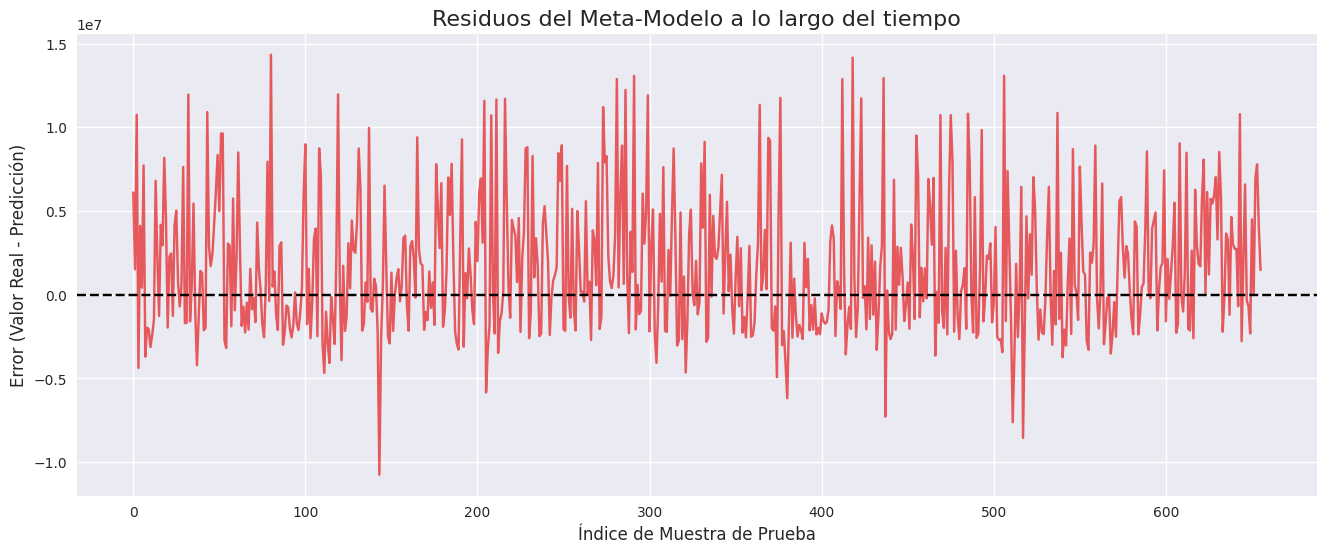

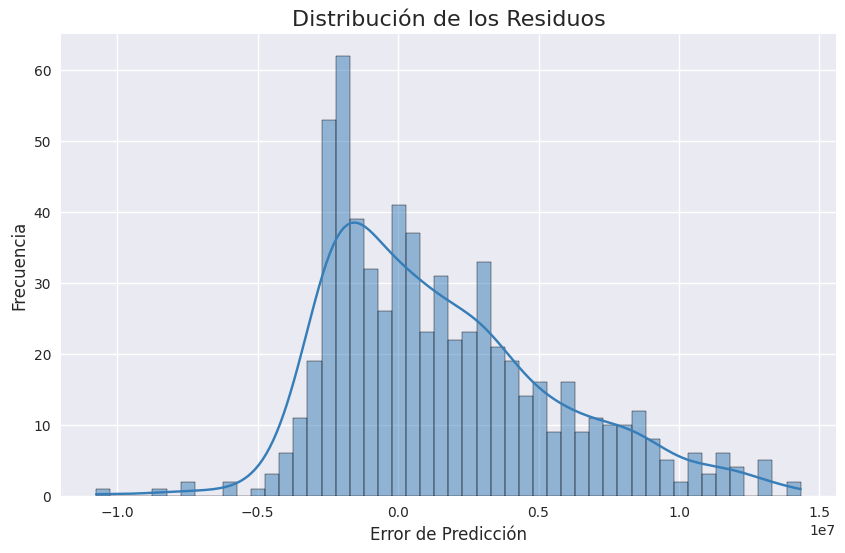


[00:21:58] --- Análisis de la Importancia de las Características (Coeficientes) ---

Top 10 Características más Importantes:
              Feature  Importance
        pred_AdaBoost    1.246771
    pred_RandomForest    0.649674
pred_GradientBoosting    0.594610
            pred_LSTM    0.399380
         pred_XGBoost    0.366834
             pred_GRU    0.274151
           pred_BiGRU    0.272578
          pred_BiLSTM    0.097290
       pred_SimpleRNN    0.078399
         pred_Bagging    0.056766


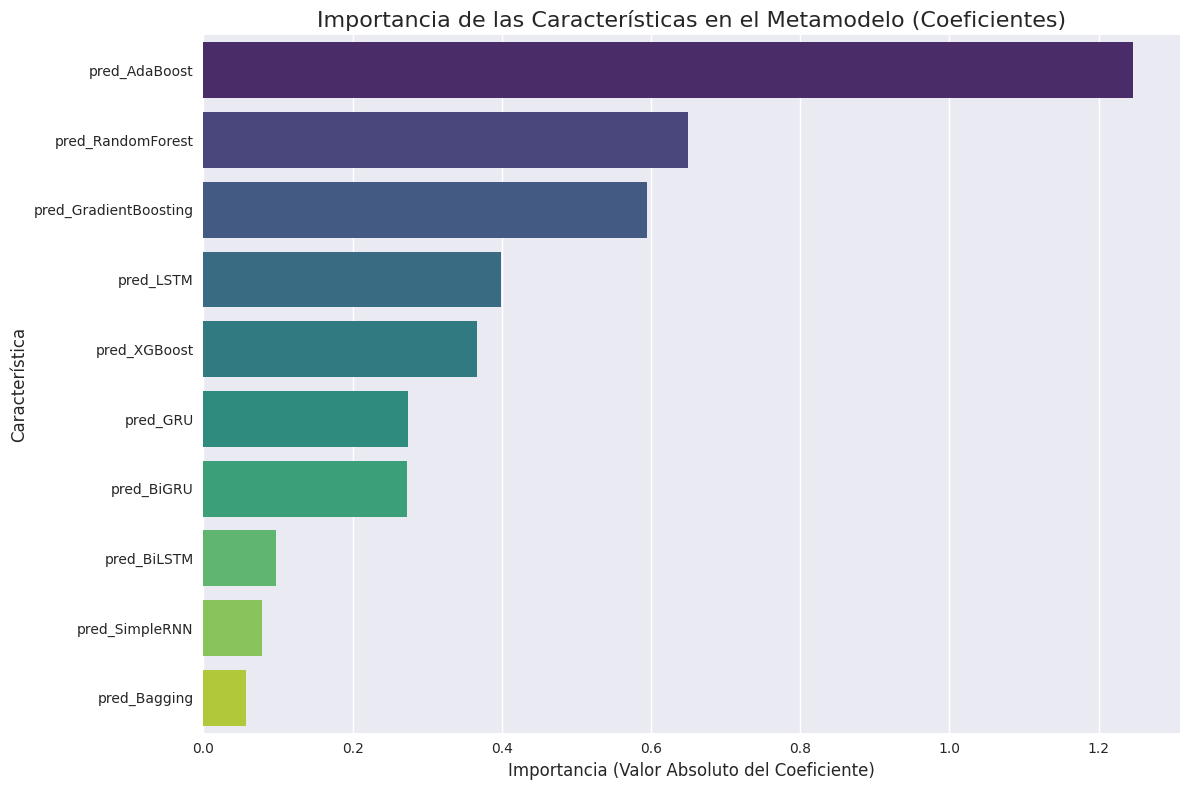


[00:21:58] ✅ Análisis completado. La información relevante está lista para ser interpretada.


In [21]:
# celda 17
#==============================================================================
# --- 1. CONFIGURACIÓN Y RUTAS GLOBALES ---
# ==============================================================================
# Se importan las librerías necesarias.
import os
import joblib
import numpy as np
import pandas as pd

from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from joblib import load
import time
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Definición de directorios y rutas basadas en la configuración del usuario.
BASE_SAVE_DIR = os.path.join(os.path.expanduser('~'), 'proyectos', 'backend-cafe-ia')
VERSION_SAVE_DIR = os.path.join(BASE_SAVE_DIR, 'progress', 'banano')


Y_SCALER_PATH = os.path.join(VERSION_SAVE_DIR, 'y_scaler.joblib')
Y_TEST_FINAL_PATH = os.path.join(VERSION_SAVE_DIR, 'y_test_final.joblib')

# 🐛 Corrección: Se elimina la 'b' extra del nombre del archivo.
META_MODEL_PATH = os.path.join(VERSION_SAVE_DIR, 'metamodelo_RidgeCV.joblibb')
META_TEST_PREDS_PATH = os.path.join(VERSION_SAVE_DIR, 'test_preds_meta_model_GradientBoosting.joblib')
META_FEATURE_NAMES_PATH = os.path.join(VERSION_SAVE_DIR, 'meta_feature_names.joblib')

# Se imprimen las rutas para confirmación.
print(f"[{time.strftime('%H:%M:%S')}] Directorios y rutas configurados correctamente.")
print(f"[{time.strftime('%H:%M:%S')}] Directorio de guardado: {VERSION_SAVE_DIR}")

# ==============================================================================
# --- 2. FUNCIONES AUXILIARES ---
# ==============================================================================
def calculate_smape_np(y_true, y_pred):
    """Calcula el SMAPE. Los valores de entrada deben ser NumPy arrays."""
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100

def calculate_mape_np(y_true, y_pred):
    """Calcula el MAPE. Los valores de entrada deben ser NumPy arrays."""
    non_zero_indices = np.abs(y_true) > 1e-6
    if not np.any(non_zero_indices):
        return 0.0
    mape = np.mean(np.abs(y_pred[non_zero_indices] - y_true[non_zero_indices]) / np.abs(y_true[non_zero_indices])) * 100
    return mape

# ==============================================================================
# --- 3. CARGA DE DATOS Y MODELOS ---
# ==============================================================================
try:
    print("="*80)
    print("--- FASE DE ANÁLISIS: Análisis de Características y Patrones Relevantes ---")
    print("="*80 + "\n")

    print(f"[{time.strftime('%H:%M:%S')}] Iniciando el proceso de carga de datos...")
    
    # Se cargan los archivos necesarios para el análisis.
    scaler_y = joblib.load(Y_SCALER_PATH)
    y_test_final = joblib.load(Y_TEST_FINAL_PATH)
    test_preds_meta_scaled = joblib.load(META_TEST_PREDS_PATH)
    meta_model = joblib.load(META_MODEL_PATH)
    
    meta_feature_names_data = joblib.load(META_FEATURE_NAMES_PATH)
    meta_feature_names = meta_feature_names_data['meta_feature_names']
    
    print(f"[{time.strftime('%H:%M:%S')}] ✅ Todos los archivos necesarios cargados exitosamente.")

except FileNotFoundError as e:
    print(f"[{time.strftime('%H:%M:%S')}] ❌ ERROR: No se pudo cargar un archivo. Asegúrate de que los archivos existen en la ruta: {VERSION_SAVE_DIR}. Detalles: {e}")
    raise SystemExit("Error al cargar archivos. No se puede continuar.")

# ==============================================================================
# --- 4. DESESCALAR LOS DATOS Y PREPARAR PARA ANÁLISIS ---
# ==============================================================================
y_true_test_original = scaler_y.inverse_transform(y_test_final.reshape(-1, 1)).flatten()
y_pred_meta_original = scaler_y.inverse_transform(test_preds_meta_scaled.reshape(-1, 1)).flatten()
y_pred_meta_original = np.maximum(0, y_pred_meta_original)

# ==============================================================================
# --- 5. ANÁLISIS DE ERRORES (RESIDUOS) ---
# ==============================================================================
print(f"\n[{time.strftime('%H:%M:%S')}] --- Análisis de Errores (Residuos) ---")

errores = y_true_test_original - y_pred_meta_original

plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(16, 6))
plt.plot(errores, color='#E41A1C', alpha=0.7)
plt.title('Residuos del Meta-Modelo a lo largo del tiempo', fontsize=16)
plt.xlabel('Índice de Muestra de Prueba', fontsize=12)
plt.ylabel('Error (Valor Real - Predicción)', fontsize=12)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(errores, kde=True, bins=50, color='#377EB8')
plt.title('Distribución de los Residuos', fontsize=16)
plt.xlabel('Error de Predicción', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.show()

# ==============================================================================
# --- 6. ANÁLISIS DE LA IMPORTANCIA DE LAS CARACTERÍSTICAS (COEFICIENTES) ---
# ==============================================================================
print(f"\n[{time.strftime('%H:%M:%S')}] --- Análisis de la Importancia de las Características (Coeficientes) ---")

# ✅ Corrección: 'RidgeCV' no tiene el atributo 'feature_importances_'. 
# Se usan los coeficientes para determinar la importancia.
feature_importances = np.abs(meta_model.coef_)

# Crear un DataFrame para una mejor visualización.
df_importances = pd.DataFrame({
    'Feature': meta_feature_names,
    'Importance': feature_importances
})
df_importances = df_importances.sort_values(by='Importance', ascending=False)

print("\nTop 10 Características más Importantes:")
print(df_importances.head(10).to_string(index=False))

plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=df_importances.head(15),
    palette='viridis',
    hue='Feature',
    legend=False
)
plt.title('Importancia de las Características en el Metamodelo (Coeficientes)', fontsize=16)
plt.xlabel('Importancia (Valor Absoluto del Coeficiente)', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\n[{time.strftime('%H:%M:%S')}] ✅ Análisis completado. La información relevante está lista para ser interpretada.")


--- FASE 4: Comparación Estadística de Modelos ---

[00:58:23] Iniciando el proceso de carga de datos...
[00:58:23] Mejor modelo de árbol: 'XGBoost'
[00:58:23] Mejor modelo RNN: 'SimpleRNN'
[00:58:23] Valores reales de prueba cargados. Shape: (656,)
[00:58:23] ✅ Predicciones de prueba de los tres modelos cargadas exitosamente.
[00:58:23] Predicciones de Árbol shape: (656,)
[00:58:23] Predicciones de RNN shape: (656,)
[00:58:23] Predicciones de Meta-Modelo shape: (656,)

[00:58:23] Desescalando valores para calcular los errores en la escala original...
[00:58:23] Calculando series de errores de pronóstico...

[00:58:23] --- Resultados de la Prueba de Diebold-Mariano (Función de pérdida: MSE) ---
La hipótesis nula (H0) es que los dos modelos tienen la misma precisión de pronóstico.
Un valor p < 0.05 sugiere que un modelo es significativamente mejor que el otro.

Comparación: Metamodelo vs. 'XGBoost'
Estadístico DM: 2.4093, Valor p: 0.0163

Comparación: Metamodelo vs. 'SimpleRNN'
Estadíst

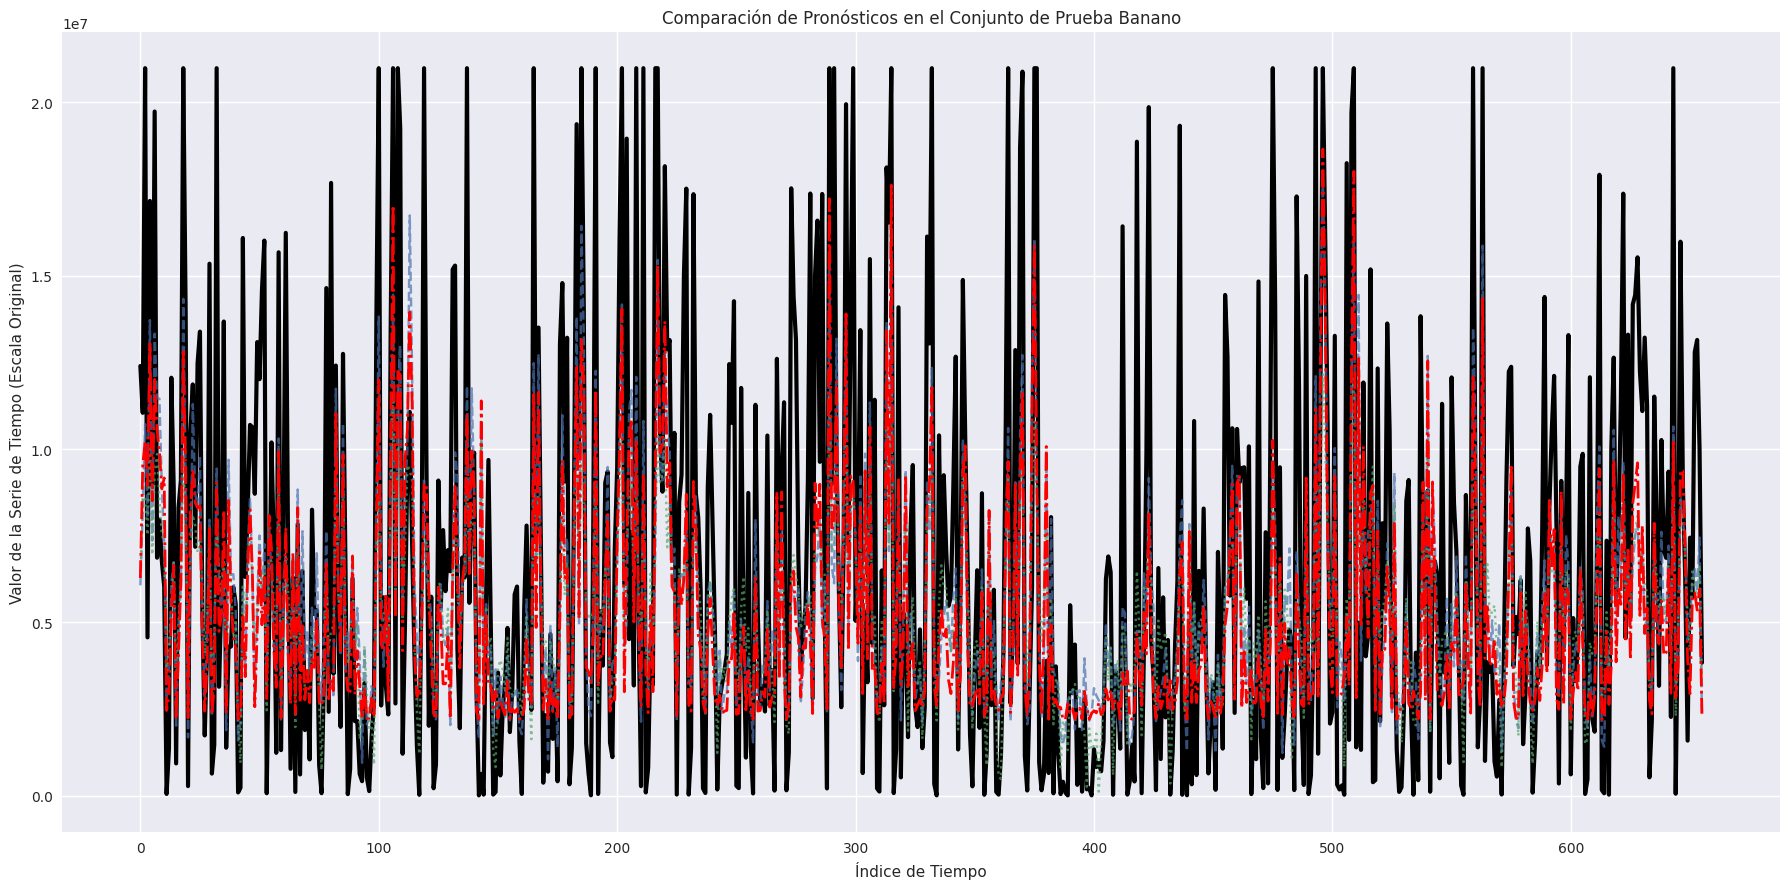


[00:58:23] ✅ Proceso de comparación de modelos completado exitosamente.


In [34]:
# celda 18
# ==============================================================================
# --- IMPORTACIONES DE LIBRERÍAS ---
# ==============================================================================
import joblib
import numpy as np
import os
import pandas as pd
from scipy.stats import t
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import time
import json

# ==============================================================================
# --- 1. CONFIGURACIÓN Y RUTAS GLOBALES ---
# ==============================================================================
# ✅ RUTA ACTUALIZADA: Se usa la carpeta 'pca' como base de la versión,
# según lo solicitado por el usuario.
BASE_SAVE_DIR = os.path.join(os.path.expanduser('~'), 'proyectos', 'backend-cafe-ia')
VERSION_SAVE_DIR = os.path.join(BASE_SAVE_DIR, 'progress', 'banano')

# Las rutas a los archivos de métricas y datos ahora apuntan a la carpeta 'pca'
RNN_OOF_METRICS_PATH = os.path.join(VERSION_SAVE_DIR, 'rnn_oof_metrics.json')
TREE_OOF_METRICS_PATH = os.path.join(VERSION_SAVE_DIR, 'tree_oof_metrics.json')
STACKING_METRICS_PATH = os.path.join(VERSION_SAVE_DIR, 'stacking_metrics_RidgeCV.json')
Y_SCALER_PATH = os.path.join(VERSION_SAVE_DIR, 'y_scaler.joblib')
BEST_TREE_NAME_PATH = os.path.join(VERSION_SAVE_DIR, 'best_tree_model_name.txt')
BEST_RNN_NAME_PATH = os.path.join(VERSION_SAVE_DIR, 'best_rnn_model_name.txt')
# ✅ CORRECCIÓN: Se actualiza la ruta del meta-modelo para coincidir con la
# nueva carpeta y el nombre genérico del archivo.
META_TEST_PREDS_PATH = os.path.join(VERSION_SAVE_DIR, 'test_preds_meta_model_GradientBoosting.joblib')


# ==============================================================================
# --- 2. FUNCIONES DE CÁLCULO DE MÉTRICAS ---
# ==============================================================================
def calculate_smape_np(y_true, y_pred):
    """Calcula el SMAPE. Los valores de entrada deben ser NumPy arrays."""
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100

def calculate_mape_np(y_true, y_pred):
    """Calcula el MAPE. Los valores de entrada deben ser NumPy arrays."""
    # Evitar división por cero
    non_zero_indices = np.abs(y_true) > 1e-6
    mape = np.mean(np.abs(y_pred[non_zero_indices] - y_true[non_zero_indices]) / np.abs(y_true[non_zero_indices])) * 100
    return mape

# ==============================================================================
# --- 3. IMPLEMENTACIÓN MANUAL DE LA PRUEBA DE DIEBOLD-MARIANO ---
# ==============================================================================
def diebold_mariano_test_manual(errors1, errors2, h=1, power=2):
    """
    Realiza la prueba de Diebold-Mariano manualmente.
    Compara la precisión de dos series de errores de pronóstico.
    """
    # 1. Calcular la diferencia de pérdidas
    d = np.abs(errors1) ** power - np.abs(errors2) ** power
    
    # 2. Calcular la media de la diferencia
    d_mean = d.mean()
    
    # 3. Calcular la varianza de la diferencia con corrección de Newey-West
    def newey_west_variance(x, h):
        n = len(x)
        gamma0 = np.sum((x - x.mean())**2) / n
        gamma_sum = 0
        for i in range(1, h + 1):
            gamma = np.sum((x[i:] - x.mean()) * (x[:-i] - x.mean())) / n
            gamma_sum += (1 - i / (h + 1)) * gamma
        return gamma0 + 2 * gamma_sum

    var_d = newey_west_variance(d, h)
    
    # Manejar caso de varianza cero para evitar división por cero
    if var_d == 0:
        return np.nan, 1.0
        
    # 4. Calcular el estadístico de Diebold-Mariano (DM)
    dm_stat = d_mean / np.sqrt(var_d / len(d))
    
    # 5. Calcular el p-valor
    p_value = 2 * t.sf(np.abs(dm_stat), len(d) - 1)
    
    return dm_stat, p_value

# ==============================================================================
# --- 4. CARGA DE DATOS Y PREDICCIONES ---
# ==============================================================================
try:
    print("="*80)
    print("--- FASE 4: Comparación Estadística de Modelos ---")
    print("="*80 + "\n")
    print(f"[{time.strftime('%H:%M:%S')}] Iniciando el proceso de carga de datos...")

    # Cargar los escaladores
    scaler_y = joblib.load(Y_SCALER_PATH)

    # Cargar el nombre de los mejores modelos
    with open(BEST_TREE_NAME_PATH, 'r') as f:
        best_tree_name = f.read().strip()
    with open(BEST_RNN_NAME_PATH, 'r') as f:
        best_rnn_name = f.read().strip()

    print(f"[{time.strftime('%H:%M:%S')}] Mejor modelo de árbol: '{best_tree_name}'")
    print(f"[{time.strftime('%H:%M:%S')}] Mejor modelo RNN: '{best_rnn_name}'")

    # Cargar los valores reales de prueba (y_test_final)
    y_test_final = joblib.load(os.path.join(VERSION_SAVE_DIR, 'y_test_final.joblib'))
    if isinstance(y_test_final, pd.Series) or isinstance(y_test_final, pd.DataFrame):
        y_test_final = y_test_final.values.ravel()
    
    print(f"[{time.strftime('%H:%M:%S')}] Valores reales de prueba cargados. Shape: {y_test_final.shape}")

    # Cargar las predicciones de prueba de los 3 modelos
    test_preds_tree_scaled = joblib.load(os.path.join(VERSION_SAVE_DIR, f'test_preds_tree_{best_tree_name}.joblib'))
    test_preds_rnn_scaled = joblib.load(os.path.join(VERSION_SAVE_DIR, f'test_preds_rnn_{best_rnn_name}.joblib'))
    test_preds_meta_scaled = joblib.load(META_TEST_PREDS_PATH)

    print(f"[{time.strftime('%H:%M:%S')}] ✅ Predicciones de prueba de los tres modelos cargadas exitosamente.")
    print(f"[{time.strftime('%H:%M:%S')}] Predicciones de Árbol shape: {test_preds_tree_scaled.shape}")
    print(f"[{time.strftime('%H:%M:%S')}] Predicciones de RNN shape: {test_preds_rnn_scaled.shape}")
    print(f"[{time.strftime('%H:%M:%S')}] Predicciones de Meta-Modelo shape: {test_preds_meta_scaled.shape}")

except FileNotFoundError as e:
    print(f"[{time.strftime('%H:%M:%S')}] ❌ ERROR: No se pudieron cargar los archivos necesarios. Asegúrate de que las fases de entrenamiento se ejecutaron correctamente. Detalles: {e}")
    raise SystemExit("Error al cargar archivos. No se puede continuar.")

# ==============================================================================
# --- 5. DESESCALADO Y CÁLCULO DE ERRORES ---
# ==============================================================================
print(f"\n[{time.strftime('%H:%M:%S')}] Desescalando valores para calcular los errores en la escala original...")
y_true_test_original = scaler_y.inverse_transform(y_test_final.reshape(-1, 1)).flatten()
y_pred_tree_original = scaler_y.inverse_transform(test_preds_tree_scaled.reshape(-1, 1)).flatten()
y_pred_rnn_original = scaler_y.inverse_transform(test_preds_rnn_scaled.reshape(-1, 1)).flatten()
y_pred_meta_original = scaler_y.inverse_transform(test_preds_meta_scaled.reshape(-1, 1)).flatten()

# Asegurarse de que las predicciones no sean negativas
y_pred_tree_original = np.maximum(0, y_pred_tree_original)
y_pred_rnn_original = np.maximum(0, y_pred_rnn_original)
y_pred_meta_original = np.maximum(0, y_pred_meta_original)

# Calcular las series de errores de pronóstico para la prueba DM
print(f"[{time.strftime('%H:%M:%S')}] Calculando series de errores de pronóstico...")
errores_tree = y_true_test_original - y_pred_tree_original
errores_rnn = y_true_test_original - y_pred_rnn_original
errores_meta = y_true_test_original - y_pred_meta_original

# ==============================================================================
# --- 6. APLICACIÓN DE LA PRUEBA DE DIEBOLD-MARIANO ---
# ==============================================================================
print(f"\n[{time.strftime('%H:%M:%S')}] --- Resultados de la Prueba de Diebold-Mariano (Función de pérdida: MSE) ---")
print("La hipótesis nula (H0) es que los dos modelos tienen la misma precisión de pronóstico.")
print("Un valor p < 0.05 sugiere que un modelo es significativamente mejor que el otro.")

# 1. Comparar Metamodelo vs. Mejor Árbol
print(f"\nComparación: Metamodelo vs. '{best_tree_name}'")
dm_stat, p_value = diebold_mariano_test_manual(errores_meta, errores_tree)
print(f"Estadístico DM: {dm_stat:.4f}, Valor p: {p_value:.4f}")

# 2. Comparar Metamodelo vs. Mejor RNN
print(f"\nComparación: Metamodelo vs. '{best_rnn_name}'")
dm_stat, p_value = diebold_mariano_test_manual(errores_meta, errores_rnn)
print(f"Estadístico DM: {dm_stat:.4f}, Valor p: {p_value:.4f}")

# 3. Comparar Mejor Árbol vs. Mejor RNN (opcional)
print(f"\nComparación: '{best_tree_name}' vs. '{best_rnn_name}'")
dm_stat, p_value = diebold_mariano_test_manual(errores_tree, errores_rnn)
print(f"Estadístico DM: {dm_stat:.4f}, Valor p: {p_value:.4f}")

# ==============================================================================
# --- 7. RESUMEN DE MÉTRICAS ADICIONALES ---
# ==============================================================================
print(f"\n[{time.strftime('%H:%M:%S')}] --- Métricas de Evaluación en el Conjunto de Prueba ---")

def get_full_metrics(y_true, y_pred):
    """Calcula un diccionario de métricas para un modelo."""
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': calculate_mape_np(y_true, y_pred),
        'SMAPE': calculate_smape_np(y_true, y_pred)
    }

metrics_tree = get_full_metrics(y_true_test_original, y_pred_tree_original)
metrics_rnn = get_full_metrics(y_true_test_original, y_pred_rnn_original)
metrics_meta = get_full_metrics(y_true_test_original, y_pred_meta_original)

print(f"\nMétricas para el modelo '{best_tree_name}':")
for k, v in metrics_tree.items():
    print(f"  - {k}: {v:.4f}")

print(f"\nMétricas para el modelo '{best_rnn_name}':")
for k, v in metrics_rnn.items():
    print(f"  - {k}: {v:.4f}")

print(f"\nMétricas para el Metamodelo:")
for k, v in metrics_meta.items():
    print(f"  - {k}: {v:.4f}")

# ==============================================================================
# --- 8. VISUALIZACIÓN DE LOS RESULTADOS ---
# ==============================================================================
print(f"\n[{time.strftime('%H:%M:%S')}] Generando gráfico de visualización de pronósticos...")
plt.figure(figsize=(18, 9))
#plt.plot(y_true_test_original, label='Valores Reales', color='black', linewidth=3)
#plt.plot(y_pred_tree_original, label=f'Pronóstico {best_tree_name}', linestyle='--', alpha=0.7)
#plt.plot(y_pred_rnn_original, label=f'Pronóstico {best_rnn_name}', linestyle=':', alpha=0.7)
#plt.plot(y_pred_meta_original, label='Pronóstico Metamodelo (Stacking)', linestyle='-.', linewidth=2, color='red')


plt.plot(y_true_test_original, color='black', linewidth=3)
plt.plot(y_pred_tree_original, linestyle='--', alpha=0.7)
plt.plot(y_pred_rnn_original,  linestyle=':', alpha=0.7)
plt.plot(y_pred_meta_original, linestyle='-.', linewidth=2, color='red')

plt.title('Comparación de Pronósticos en el Conjunto de Prueba Banano')
plt.xlabel('Índice de Tiempo')
plt.ylabel('Valor de la Serie de Tiempo (Escala Original)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\n[{time.strftime('%H:%M:%S')}] ✅ Proceso de comparación de modelos completado exitosamente.")



--- FASE 4: Comparación Estadística de Modelos ---

[00:47:50] Iniciando el proceso de carga de datos...
[00:47:50] Mejor modelo de árbol: 'XGBoost'
[00:47:50] Mejor modelo RNN: 'SimpleRNN'
[00:47:50] Valores reales de prueba cargados. Shape: (656,)
[00:47:50] ✅ Predicciones de prueba de los tres modelos cargadas exitosamente.
[00:47:50] Predicciones de Árbol shape: (656,)
[00:47:50] Predicciones de RNN shape: (656,)
[00:47:50] Predicciones de Meta-Modelo shape: (656,)

[00:47:50] Desescalando valores para calcular los errores en la escala original...
[00:47:50] Calculando series de errores de pronóstico...

[00:47:50] --- Resultados de la Prueba de Diebold-Mariano (Función de pérdida: MSE) ---
La hipótesis nula (H0) es que los dos modelos tienen la misma precisión de pronóstico.
Un valor p < 0.05 sugiere que un modelo es significativamente mejor que el otro.

Comparación: Metamodelo vs. 'XGBoost'
Estadístico DM: 2.4093, Valor p: 0.0163

Comparación: Metamodelo vs. 'SimpleRNN'
Estadíst

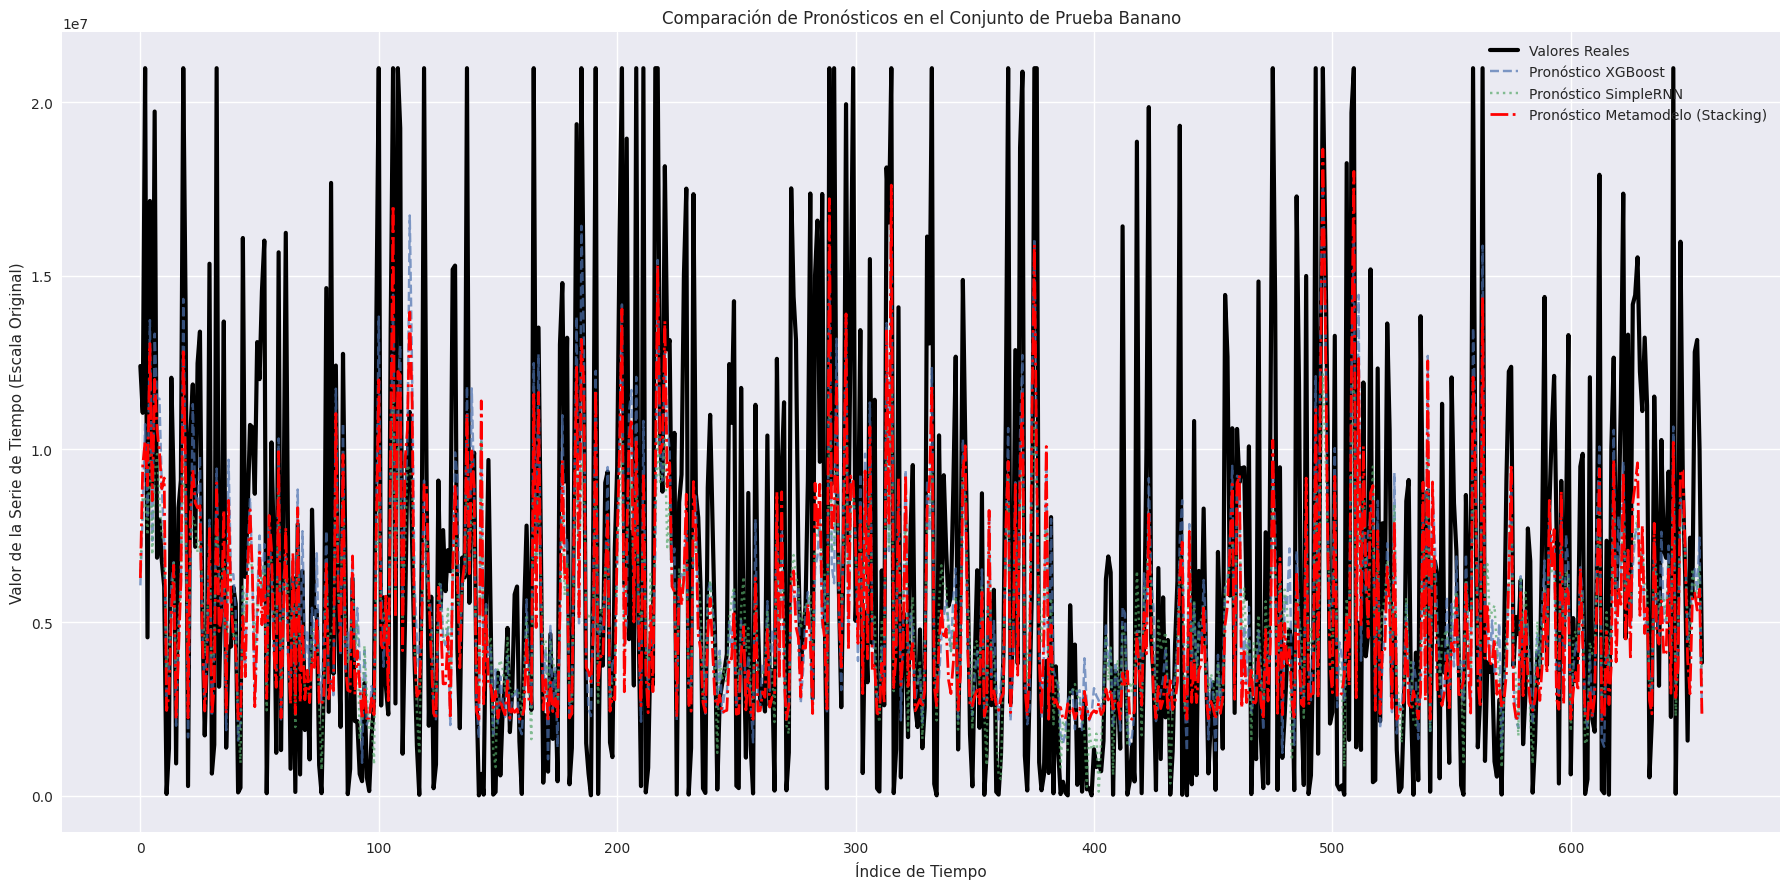


[00:47:52] ✅ Proceso de comparación de modelos completado exitosamente.


In [33]:
#nueva grafica misma celda anterior
# celda 18
# ==============================================================================
# --- IMPORTACIONES DE LIBRERÍAS ---
# ==============================================================================
import joblib
import numpy as np
import os
import pandas as pd
from scipy.stats import t
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import time
import json

# ==============================================================================
# --- 1. CONFIGURACIÓN Y RUTAS GLOBALES ---
# ==============================================================================
# ✅ RUTA ACTUALIZADA: Se usa la carpeta 'pca' como base de la versión,
# según lo solicitado por el usuario.
BASE_SAVE_DIR = os.path.join(os.path.expanduser('~'), 'proyectos', 'backend-cafe-ia')
VERSION_SAVE_DIR = os.path.join(BASE_SAVE_DIR, 'progress', 'banano')

# Las rutas a los archivos de métricas y datos ahora apuntan a la carpeta 'pca'
RNN_OOF_METRICS_PATH = os.path.join(VERSION_SAVE_DIR, 'rnn_oof_metrics.json')
TREE_OOF_METRICS_PATH = os.path.join(VERSION_SAVE_DIR, 'tree_oof_metrics.json')
STACKING_METRICS_PATH = os.path.join(VERSION_SAVE_DIR, 'stacking_metrics_RidgeCV.json')
Y_SCALER_PATH = os.path.join(VERSION_SAVE_DIR, 'y_scaler.joblib')
BEST_TREE_NAME_PATH = os.path.join(VERSION_SAVE_DIR, 'best_tree_model_name.txt')
BEST_RNN_NAME_PATH = os.path.join(VERSION_SAVE_DIR, 'best_rnn_model_name.txt')
# ✅ CORRECCIÓN: Se actualiza la ruta del meta-modelo para coincidir con la
# nueva carpeta y el nombre genérico del archivo.
META_TEST_PREDS_PATH = os.path.join(VERSION_SAVE_DIR, 'test_preds_meta_model_GradientBoosting.joblib')


# ==============================================================================
# --- 2. FUNCIONES DE CÁLCULO DE MÉTRICAS ---
# ==============================================================================
def calculate_smape_np(y_true, y_pred):
    """Calcula el SMAPE. Los valores de entrada deben ser NumPy arrays."""
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100

def calculate_mape_np(y_true, y_pred):
    """Calcula el MAPE. Los valores de entrada deben ser NumPy arrays."""
    # Evitar división por cero
    non_zero_indices = np.abs(y_true) > 1e-6
    mape = np.mean(np.abs(y_pred[non_zero_indices] - y_true[non_zero_indices]) / np.abs(y_true[non_zero_indices])) * 100
    return mape

# ==============================================================================
# --- 3. IMPLEMENTACIÓN MANUAL DE LA PRUEBA DE DIEBOLD-MARIANO ---
# ==============================================================================
def diebold_mariano_test_manual(errors1, errors2, h=1, power=2):
    """
    Realiza la prueba de Diebold-Mariano manualmente.
    Compara la precisión de dos series de errores de pronóstico.
    """
    # 1. Calcular la diferencia de pérdidas
    d = np.abs(errors1) ** power - np.abs(errors2) ** power
    
    # 2. Calcular la media de la diferencia
    d_mean = d.mean()
    
    # 3. Calcular la varianza de la diferencia con corrección de Newey-West
    def newey_west_variance(x, h):
        n = len(x)
        gamma0 = np.sum((x - x.mean())**2) / n
        gamma_sum = 0
        for i in range(1, h + 1):
            gamma = np.sum((x[i:] - x.mean()) * (x[:-i] - x.mean())) / n
            gamma_sum += (1 - i / (h + 1)) * gamma
        return gamma0 + 2 * gamma_sum

    var_d = newey_west_variance(d, h)
    
    # Manejar caso de varianza cero para evitar división por cero
    if var_d == 0:
        return np.nan, 1.0
        
    # 4. Calcular el estadístico de Diebold-Mariano (DM)
    dm_stat = d_mean / np.sqrt(var_d / len(d))
    
    # 5. Calcular el p-valor
    p_value = 2 * t.sf(np.abs(dm_stat), len(d) - 1)
    
    return dm_stat, p_value

# ==============================================================================
# --- 4. CARGA DE DATOS Y PREDICCIONES ---
# ==============================================================================
try:
    print("="*80)
    print("--- FASE 4: Comparación Estadística de Modelos ---")
    print("="*80 + "\n")
    print(f"[{time.strftime('%H:%M:%S')}] Iniciando el proceso de carga de datos...")

    # Cargar los escaladores
    scaler_y = joblib.load(Y_SCALER_PATH)

    # Cargar el nombre de los mejores modelos
    with open(BEST_TREE_NAME_PATH, 'r') as f:
        best_tree_name = f.read().strip()
    with open(BEST_RNN_NAME_PATH, 'r') as f:
        best_rnn_name = f.read().strip()

    print(f"[{time.strftime('%H:%M:%S')}] Mejor modelo de árbol: '{best_tree_name}'")
    print(f"[{time.strftime('%H:%M:%S')}] Mejor modelo RNN: '{best_rnn_name}'")

    # Cargar los valores reales de prueba (y_test_final)
    y_test_final = joblib.load(os.path.join(VERSION_SAVE_DIR, 'y_test_final.joblib'))
    if isinstance(y_test_final, pd.Series) or isinstance(y_test_final, pd.DataFrame):
        y_test_final = y_test_final.values.ravel()
    
    print(f"[{time.strftime('%H:%M:%S')}] Valores reales de prueba cargados. Shape: {y_test_final.shape}")

    # Cargar las predicciones de prueba de los 3 modelos
    test_preds_tree_scaled = joblib.load(os.path.join(VERSION_SAVE_DIR, f'test_preds_tree_{best_tree_name}.joblib'))
    test_preds_rnn_scaled = joblib.load(os.path.join(VERSION_SAVE_DIR, f'test_preds_rnn_{best_rnn_name}.joblib'))
    test_preds_meta_scaled = joblib.load(META_TEST_PREDS_PATH)

    print(f"[{time.strftime('%H:%M:%S')}] ✅ Predicciones de prueba de los tres modelos cargadas exitosamente.")
    print(f"[{time.strftime('%H:%M:%S')}] Predicciones de Árbol shape: {test_preds_tree_scaled.shape}")
    print(f"[{time.strftime('%H:%M:%S')}] Predicciones de RNN shape: {test_preds_rnn_scaled.shape}")
    print(f"[{time.strftime('%H:%M:%S')}] Predicciones de Meta-Modelo shape: {test_preds_meta_scaled.shape}")

except FileNotFoundError as e:
    print(f"[{time.strftime('%H:%M:%S')}] ❌ ERROR: No se pudieron cargar los archivos necesarios. Asegúrate de que las fases de entrenamiento se ejecutaron correctamente. Detalles: {e}")
    raise SystemExit("Error al cargar archivos. No se puede continuar.")

# ==============================================================================
# --- 5. DESESCALADO Y CÁLCULO DE ERRORES ---
# ==============================================================================
print(f"\n[{time.strftime('%H:%M:%S')}] Desescalando valores para calcular los errores en la escala original...")
y_true_test_original = scaler_y.inverse_transform(y_test_final.reshape(-1, 1)).flatten()
y_pred_tree_original = scaler_y.inverse_transform(test_preds_tree_scaled.reshape(-1, 1)).flatten()
y_pred_rnn_original = scaler_y.inverse_transform(test_preds_rnn_scaled.reshape(-1, 1)).flatten()
y_pred_meta_original = scaler_y.inverse_transform(test_preds_meta_scaled.reshape(-1, 1)).flatten()

# Asegurarse de que las predicciones no sean negativas
y_pred_tree_original = np.maximum(0, y_pred_tree_original)
y_pred_rnn_original = np.maximum(0, y_pred_rnn_original)
y_pred_meta_original = np.maximum(0, y_pred_meta_original)

# Calcular las series de errores de pronóstico para la prueba DM
print(f"[{time.strftime('%H:%M:%S')}] Calculando series de errores de pronóstico...")
errores_tree = y_true_test_original - y_pred_tree_original
errores_rnn = y_true_test_original - y_pred_rnn_original
errores_meta = y_true_test_original - y_pred_meta_original

# ==============================================================================
# --- 6. APLICACIÓN DE LA PRUEBA DE DIEBOLD-MARIANO ---
# ==============================================================================
print(f"\n[{time.strftime('%H:%M:%S')}] --- Resultados de la Prueba de Diebold-Mariano (Función de pérdida: MSE) ---")
print("La hipótesis nula (H0) es que los dos modelos tienen la misma precisión de pronóstico.")
print("Un valor p < 0.05 sugiere que un modelo es significativamente mejor que el otro.")

# 1. Comparar Metamodelo vs. Mejor Árbol
print(f"\nComparación: Metamodelo vs. '{best_tree_name}'")
dm_stat, p_value = diebold_mariano_test_manual(errores_meta, errores_tree)
print(f"Estadístico DM: {dm_stat:.4f}, Valor p: {p_value:.4f}")

# 2. Comparar Metamodelo vs. Mejor RNN
print(f"\nComparación: Metamodelo vs. '{best_rnn_name}'")
dm_stat, p_value = diebold_mariano_test_manual(errores_meta, errores_rnn)
print(f"Estadístico DM: {dm_stat:.4f}, Valor p: {p_value:.4f}")

# 3. Comparar Mejor Árbol vs. Mejor RNN (opcional)
print(f"\nComparación: '{best_tree_name}' vs. '{best_rnn_name}'")
dm_stat, p_value = diebold_mariano_test_manual(errores_tree, errores_rnn)
print(f"Estadístico DM: {dm_stat:.4f}, Valor p: {p_value:.4f}")

# ==============================================================================
# --- 7. RESUMEN DE MÉTRICAS ADICIONALES ---
# ==============================================================================
print(f"\n[{time.strftime('%H:%M:%S')}] --- Métricas de Evaluación en el Conjunto de Prueba ---")

def get_full_metrics(y_true, y_pred):
    """Calcula un diccionario de métricas para un modelo."""
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': calculate_mape_np(y_true, y_pred),
        'SMAPE': calculate_smape_np(y_true, y_pred)
    }

metrics_tree = get_full_metrics(y_true_test_original, y_pred_tree_original)
metrics_rnn = get_full_metrics(y_true_test_original, y_pred_rnn_original)
metrics_meta = get_full_metrics(y_true_test_original, y_pred_meta_original)

print(f"\nMétricas para el modelo '{best_tree_name}':")
for k, v in metrics_tree.items():
    print(f"  - {k}: {v:.4f}")

print(f"\nMétricas para el modelo '{best_rnn_name}':")
for k, v in metrics_rnn.items():
    print(f"  - {k}: {v:.4f}")

print(f"\nMétricas para el Metamodelo:")
for k, v in metrics_meta.items():
    print(f"  - {k}: {v:.4f}")

# ==============================================================================
# --- 8. VISUALIZACIÓN DE LOS RESULTADOS ---
# ==============================================================================
print(f"\n[{time.strftime('%H:%M:%S')}] Generando gráfico de visualización de pronósticos...")
plt.figure(figsize=(18, 9))
plt.plot(y_true_test_original, label='Valores Reales', color='black', linewidth=3)
plt.plot(y_pred_tree_original, label=f'Pronóstico {best_tree_name}', linestyle='--', alpha=0.7)
plt.plot(y_pred_rnn_original, label=f'Pronóstico {best_rnn_name}', linestyle=':', alpha=0.7)
plt.plot(y_pred_meta_original, label='Pronóstico Metamodelo (Stacking)', linestyle='-.', linewidth=2, color='red')
plt.title('Comparación de Pronósticos en el Conjunto de Prueba Banano')
plt.xlabel('Índice de Tiempo')
plt.ylabel('Valor de la Serie de Tiempo (Escala Original)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\n[{time.strftime('%H:%M:%S')}] ✅ Proceso de comparación de modelos completado exitosamente.")








In [ ]:
# no ejecturar
# ==============================================================================
# --- CELDA 19: PREDICCIÓN CON EL META-MODELO Y CÁLCULO DE INTERVALOS DE CONFIANZA ---
# ==============================================================================
import os
import sys
import numpy as np
import pandas as pd
from joblib import load
from datetime import datetime, timedelta
import logging
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import register_keras_serializable
from sklearn.metrics import mean_squared_error

# Configurar logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(message)s', datefmt='%H:%M:%S')

print("-" * 50)
print(f"VERIFICANDO VERSIÓN DE PYTHON: {sys.version}")
print("-" * 50)

# ==============================================================================
# --- FUNCIONES AUXILIARES ---
# ==============================================================================

@register_keras_serializable()
def smape_keras(y_true, y_pred):
    epsilon = 0.1
    summ = tf.maximum(tf.abs(y_true) + tf.abs(y_pred) + epsilon, 0.5)
    smape = tf.reduce_mean(2 * tf.abs(y_pred - y_true) / summ) * 100
    return smape

def generate_features_for_single_day(date, current_historical_df, avg_features, target_column='Cantidad_total'):
    """
    Genera todas las características requeridas para un solo día de predicción,
    utilizando los datos más recientes (reales o predichos) de forma recursiva.
    """
    row = {}

    # Características temporales (dinámicas)
    row['dia_semana'] = date.weekday()
    row['mes'] = date.month
    row['es_fin_de_semana'] = 1 if date.weekday() >= 5 else 0

    # Lags y medias móviles calculados dinámicamente sobre el historial temporal
    if len(current_historical_df) >= 7:
        row['lag_1'] = current_historical_df[target_column].iloc[-1]
        row['lag_7'] = current_historical_df[target_column].iloc[-7]
        
        recent_values = current_historical_df[target_column].tail(7).values
        row['rolling_mean_7d'] = np.mean(recent_values)
        row['rolling_std_7d'] = np.std(recent_values)
    else:
        last_val = current_historical_df[target_column].iloc[-1]
        row['lag_1'] = last_val
        row['lag_7'] = last_val
        row['rolling_mean_7d'] = last_val
        row['rolling_std_7d'] = 0.0

    # Características de negocio (ESTÁTICAS)
    for feature in avg_features.index:
        row[feature] = avg_features[feature]
    
    return pd.DataFrame([row]).fillna(0)

def load_models_and_scalers(version_save_dir):
    """Carga todos los modelos y escaladores necesarios desde los archivos."""
    try:
        logging.info("Cargando modelos y escaladores...")
        meta_model = load(os.path.join(version_save_dir, 'metamodelo_RidgeCV.joblibb'))
        scaler_X = load(os.path.join(version_save_dir, 'scaler_X.joblib'))
        scaler_y = load(os.path.join(version_save_dir, 'y_scaler.joblib'))
        pca = load(os.path.join(version_save_dir, 'pca_model.joblib'))
        
        base_model_names = ['XGBoost', 'Bagging', 'RandomForest', 'AdaBoost', 'GradientBoosting', 'SimpleRNN', 'LSTM', 'GRU', 'BiLSTM', 'BiGRU']
        base_models = {}
        for name in base_model_names:
            if name in ['SimpleRNN', 'LSTM', 'GRU', 'BiLSTM', 'BiGRU']:
                base_models[name] = load_model(os.path.join(version_save_dir, f'final_rnn_model_{name}.keras'), custom_objects={'smape_keras': smape_keras})
            else:
                base_models[name] = load(os.path.join(version_save_dir, f'final_model_{name}.joblib'))
        
        X_test_pca = load(os.path.join(version_save_dir, 'X_scaled_pca.joblib'))
        y_test_scaled = load(os.path.join(version_save_dir, 'y_scaled_pca.joblib'))
        
        logging.info("✅ Todos los modelos, escaladores y datos de prueba han sido cargados exitosamente.")
        return meta_model, scaler_X, scaler_y, pca, base_models, X_test_pca, y_test_scaled

    except FileNotFoundError as e:
        logging.error(f"❌ ERROR: No se encontró uno de los archivos necesarios: {e}")
        return None, None, None, None, None, None, None
    except Exception as e:
        logging.error(f"❌ ERROR inesperado al cargar los modelos: {e}")
        return None, None, None, None, None, None, None

def predict_and_get_ci(data_point_df, meta_model, base_models, scaler_X, scaler_y, pca, model_error_std, feature_columns):
    """
    Predice un solo punto de datos y calcula su intervalo de confianza.
    """
    try:
        # 1. Pre-procesar el nuevo punto de datos
        features_scaled = scaler_X.transform(data_point_df[feature_columns].values)
        features_pca = pca.transform(features_scaled)
        features_rnn = features_pca.reshape(1, 1, -1)
        
        # 2. Obtener predicciones de los modelos base
        base_predictions = []
        tree_model_names = ['XGBoost', 'Bagging', 'RandomForest', 'AdaBoost', 'GradientBoosting']
        for name in tree_model_names:
            prediction_tree = base_models[name].predict(features_pca).flatten()
            base_predictions.append(prediction_tree[0])

        rnn_model_names = ['SimpleRNN', 'LSTM', 'GRU', 'BiLSTM', 'BiGRU']
        for name in rnn_model_names:
            prediction_rnn = base_models[name].predict(features_rnn, verbose=0).flatten()
            base_predictions.append(prediction_rnn[0])

        meta_features = np.array(base_predictions).reshape(1, -1)
        
        # 3. Predicción final con el meta-modelo (en escala normalizada)
        final_prediction_scaled = meta_model.predict(meta_features).flatten()[0]

        # 4. Calcular el intervalo de confianza en la escala normalizada
        margin_of_error_scaled = 1.96 * model_error_std
        lower_bound_scaled = final_prediction_scaled - margin_of_error_scaled
        upper_bound_scaled = final_prediction_scaled + margin_of_error_scaled
        
        # 5. Des-escalar la predicción y los límites del intervalo
        final_prediction_original = scaler_y.inverse_transform([[final_prediction_scaled]]).flatten()[0]
        lower_bound_original = scaler_y.inverse_transform([[lower_bound_scaled]]).flatten()[0]
        upper_bound_original = scaler_y.inverse_transform([[upper_bound_scaled]]).flatten()[0]

        final_prediction_positive = max(0, final_prediction_original)
        lower_bound_positive = max(0, lower_bound_original)
        upper_bound_positive = max(0, upper_bound_original)

        return final_prediction_positive, lower_bound_positive, upper_bound_positive
    except Exception as e:
        logging.error(f"❌ ERROR en la función predict_and_get_ci: {e}")
        return None, None, None

# ==============================================================================
# --- PROCESO PRINCIPAL DE PREDICCIÓN CORREGIDO ---
# ==============================================================================
if __name__ == '__main__':
    VERSION_SAVE_DIR = '/home/administrador/proyectos/backend-cafe-ia/progress/banano'
    
    meta_model, scaler_X, scaler_y, pca, base_models, X_test_pca, y_test_scaled = load_models_and_scalers(VERSION_SAVE_DIR)
    
    if meta_model is None:
        exit()
        
    logging.info("Calculando la desviación estándar de los residuos del meta-modelo...")
    base_predictions_test = []
    tree_model_names = ['XGBoost', 'Bagging', 'RandomForest', 'AdaBoost', 'GradientBoosting']
    for name in tree_model_names:
        X_test_pca_array = X_test_pca.values if isinstance(X_test_pca, pd.DataFrame) else X_test_pca
        base_predictions_test.append(base_models[name].predict(X_test_pca_array).flatten())
        
    rnn_model_names = ['SimpleRNN', 'LSTM', 'GRU', 'BiLSTM', 'BiGRU']
    for name in rnn_model_names:
        X_test_pca_array = X_test_pca.values if isinstance(X_test_pca, pd.DataFrame) else X_test_pca
        base_predictions_test.append(base_models[name].predict(X_test_pca_array.reshape(-1, 1, X_test_pca_array.shape[1]), verbose=0).flatten())
        
    meta_features_test = np.array(base_predictions_test).T
    final_predictions_scaled_test = meta_model.predict(meta_features_test)
    
    residuals = final_predictions_scaled_test.flatten() - y_test_scaled.values.flatten()
    model_error_std = np.std(residuals)
    logging.info(f"✅ Desviación estándar de los errores del meta-modelo (escala normalizada): {model_error_std:.4f}")

    logging.info("💾 Cargando y procesando datos históricos reales...")
    try:
        data_path = os.path.join(VERSION_SAVE_DIR, 'df_agregado_procesado.csv')
        historical_df = pd.read_csv(data_path)
        historical_df.rename(columns={'Fecha_completa': 'ds', 'Cantidad_total': 'Cantidad_total'}, inplace=True)
        historical_df['ds'] = pd.to_datetime(historical_df['ds'])
        historical_df = historical_df.sort_values('ds').reset_index(drop=True)
        
        business_features = [
            'Peso_neto_total', 'Peso_bruto_total', 'Valor_FOB_USD_total',
            'Valor_FOB_COP_total', 'Valor_VAN_total', 'Valor_Flete_total',
            'Valor_seguro_total', 'Valor_otros_total', 'Precio_Unitario_FOB_USD_Peso_Neto_promedio',
            'Precio_Unitario_FOB_USD_Peso_Bruto_promedio', 'Precio_Unitario_FOB_USD_Cantidad_promedio',
            'Precio_Unitario_FOB_COP_Peso_Neto_promedio', 'Precio_Unitario_FOB_COP_Peso_Bruto_promedio',
            'Precio_Unitario_FOB_COP_Cantidad_promedio',
        ]
        
        time_series_features = [
            'dia_semana', 'mes', 'es_fin_de_semana', 'lag_1', 'lag_7',
            'rolling_mean_7d', 'rolling_std_7d'
        ]

        full_feature_list = business_features + time_series_features
        avg_features = historical_df[business_features].mean(numeric_only=True)
        
        logging.info("✅ Datos históricos y promedios de características de negocio calculados.")
    except Exception as e:
        logging.error(f"❌ ERROR al cargar los datos: {e}")
        exit()

    while True:
        try:
            print("\nIngrese la fecha para la predicción.")
            day_input = input("Día (ej. 15) o 'exit': ")
            if day_input.lower() == 'exit':
                logging.info("Cerrando el sistema de predicción.")
                break
            
            month_input = input("Mes (ej. 7): ")
            year_input = input("Año (ej. 2026): ")
            day = int(day_input)
            month = int(month_input)
            year = int(year_input)
            target_date = datetime(year, month, day)
            
            last_historical_date = historical_df['ds'].iloc[-1].to_pydatetime()
            if target_date <= last_historical_date:
                logging.error(f"❌ La fecha solicitada {target_date.strftime('%Y-%m-%d')} debe ser posterior a los últimos datos históricos: {last_historical_date.strftime('%Y-%m-%d')}.")
                continue

            num_steps_to_forecast = (target_date - last_historical_date).days
            logging.info(f"📈 Realizando predicción de pasos múltiples para {num_steps_to_forecast} día(s)...")

            current_historical_data = historical_df.copy()
            prediction_results = pd.DataFrame(columns=['Fecha', 'Prediccion_Meta_Modelo', 'Limite_Inferior_95CI', 'Limite_Superior_95CI'])

            for i in range(1, num_steps_to_forecast + 1):
                current_prediction_date = last_historical_date + timedelta(days=i)
                
                # Generar características para el día de predicción actual
                new_data_point_df = generate_features_for_single_day(current_prediction_date, current_historical_data, avg_features)
                
                # Asegurar el orden de las columnas antes de predecir
                new_data_point_df = new_data_point_df[full_feature_list]

                # Obtener la predicción y el CI
                pred, lower, upper = predict_and_get_ci(new_data_point_df, meta_model, base_models, scaler_X, scaler_y, pca, model_error_std, full_feature_list)
                
                if pred is None:
                    break

                # Añadir la nueva predicción al DataFrame histórico temporal
                new_row_for_history = {'ds': current_prediction_date, 'Cantidad_total': pred}
                current_historical_data = pd.concat([current_historical_data, pd.DataFrame([new_row_for_history])], ignore_index=True)
                
                new_result = {
                    'Fecha': current_prediction_date,
                    'Prediccion_Meta_Modelo': pred,
                    'Limite_Inferior_95CI': lower,
                    'Limite_Superior_95CI': upper
                }
                prediction_results = pd.concat([prediction_results, pd.DataFrame([new_result])], ignore_index=True)
                
                print(f"  -> Paso de predicción {i}/{num_steps_to_forecast}: {current_prediction_date.strftime('%Y-%m-%d')} - {pred:,.2f} kg (CI: {lower:,.2f} - {upper:,.2f} kg)")

            if not prediction_results.empty:
                # Filtrar el resultado de la fecha exacta solicitada
                final_result_row = prediction_results[prediction_results['Fecha'] == target_date]
                if not final_result_row.empty:
                    final_result_row = final_result_row.iloc[0]
                    print("-" * 50)
                    print(f"✅ Predicción para la fecha {target_date.strftime('%Y-%m-%d')}:")
                    print(f"☕️ Cantidad de ventas estimada: {final_result_row['Prediccion_Meta_Modelo']:,.2f} kg")
                    print(f"Intervalo de confianza (95%): {final_result_row['Limite_Inferior_95CI']:,.2f} kg - {final_result_row['Limite_Superior_95CI']:,.2f} kg")
                    print("-" * 50)
                else:
                    logging.warning(f"No se pudo encontrar el resultado para la fecha {target_date.strftime('%Y-%m-%d')}.")

                output_filename = os.path.join(VERSION_SAVE_DIR, 'confidence_interval_results.xlsx')
                prediction_results.to_excel(output_filename, index=False)
                logging.info(f"💾 Predicciones e intervalos de confianza guardados en: {output_filename}")

        except ValueError as e:
            logging.error(f"❌ Error al ingresar la fecha. Asegúrese de que los valores sean correctos: {e}")
            print("Por favor, intente de nuevo.")
        except Exception as e:
            logging.error(f"❌ Ocurrió un error inesperado: {e}")
            print("Por favor, intente de nuevo.")

In [ ]:
#no ejecutar
# ==============================================================================
# --- SCRIPT DE PREDICCIÓN SIMPLE ---
# ==============================================================================
import os
import sys
import numpy as np
import pandas as pd
from joblib import load
from datetime import datetime, timedelta
import logging
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import register_keras_serializable

# Configurar logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(message)s', datefmt='%H:%M:%S')

print("-" * 50)
print(f"VERSIÓN DE PYTHON: {sys.version}")
print("-" * 50)

# ==============================================================================
# --- FUNCIONES AUXILIARES ---
# ==============================================================================

@register_keras_serializable()
def smape_keras(y_true, y_pred):
    epsilon = 0.1
    summ = tf.maximum(tf.abs(y_true) + tf.abs(y_pred) + epsilon, 0.5)
    smape = tf.reduce_mean(2 * tf.abs(y_pred - y_true) / summ) * 100
    return smape

def generate_features_for_single_day(date, current_historical_df, avg_features, target_column='Cantidad_total'):
    """
    Genera todas las características requeridas para un solo día de predicción.
    """
    row = {}

    # Características temporales (dinámicas)
    row['dia_semana'] = date.weekday()
    row['mes'] = date.month
    row['es_fin_de_semana'] = 1 if date.weekday() >= 5 else 0

    # Lags y medias móviles calculados dinámicamente sobre el historial temporal
    if len(current_historical_df) >= 7:
        row['lag_1'] = current_historical_df[target_column].iloc[-1]
        row['lag_7'] = current_historical_df[target_column].iloc[-7]
        
        recent_values = current_historical_df[target_column].tail(7).values
        row['rolling_mean_7d'] = np.mean(recent_values)
        row['rolling_std_7d'] = np.std(recent_values)
    else:
        last_val = current_historical_df[target_column].iloc[-1]
        row['lag_1'] = last_val
        row['lag_7'] = last_val
        row['rolling_mean_7d'] = last_val
        row['rolling_std_7d'] = 0.0

    # Características de negocio (ESTÁTICAS)
    for feature in avg_features.index:
        row[feature] = avg_features[feature]
    
    return pd.DataFrame([row]).fillna(0)

def load_models_and_scalers(version_save_dir):
    """Carga todos los modelos y escaladores necesarios desde los archivos."""
    try:
        logging.info("Cargando modelos y escaladores...")
        meta_model = load(os.path.join(version_save_dir, 'metamodelo_RidgeCV.joblib'))
        scaler_X = load(os.path.join(version_save_dir, 'scaler_X.joblib'))
        scaler_y = load(os.path.join(version_save_dir, 'y_scaler.joblib'))
        pca = load(os.path.join(version_save_dir, 'pca_model.joblib'))
        
        base_model_names = ['XGBoost', 'Bagging', 'RandomForest', 'AdaBoost', 'GradientBoosting', 'SimpleRNN', 'LSTM', 'GRU', 'BiLSTM', 'BiGRU']
        base_models = {}
        for name in base_model_names:
            if name in ['SimpleRNN', 'LSTM', 'GRU', 'BiLSTM', 'BiGRU']:
                base_models[name] = load_model(os.path.join(version_save_dir, f'final_rnn_model_{name}.keras'), custom_objects={'smape_keras': smape_keras})
            else:
                base_models[name] = load(os.path.join(version_save_dir, f'final_model_{name}.joblib'))
        
        logging.info("✅ Todos los modelos y escaladores han sido cargados exitosamente.")
        return meta_model, scaler_X, scaler_y, pca, base_models

    except FileNotFoundError as e:
        logging.error(f"❌ ERROR: No se encontró uno de los archivos necesarios: {e}")
        return None, None, None, None, None
    except Exception as e:
        logging.error(f"❌ ERROR inesperado al cargar los modelos: {e}")
        return None, None, None, None, None

def predict_single_day(data_point_df, meta_model, base_models, scaler_X, scaler_y, pca, feature_columns):
    """
    Predice un solo punto de datos sin calcular intervalos de confianza.
    """
    try:
        # 1. Pre-procesar el nuevo punto de datos
        features_scaled = scaler_X.transform(data_point_df[feature_columns].values)
        features_pca = pca.transform(features_scaled)
        features_rnn = features_pca.reshape(1, 1, -1)
        
        # 2. Obtener predicciones de los modelos base
        base_predictions = []
        tree_model_names = ['XGBoost', 'Bagging', 'RandomForest', 'AdaBoost', 'GradientBoosting']
        for name in tree_model_names:
            prediction_tree = base_models[name].predict(features_pca).flatten()
            base_predictions.append(prediction_tree[0])

        rnn_model_names = ['SimpleRNN', 'LSTM', 'GRU', 'BiLSTM', 'BiGRU']
        for name in rnn_model_names:
            prediction_rnn = base_models[name].predict(features_rnn, verbose=0).flatten()
            base_predictions.append(prediction_rnn[0])

        meta_features = np.array(base_predictions).reshape(1, -1)
        
        # 3. Predicción final con el meta-modelo (en escala normalizada)
        final_prediction_scaled = meta_model.predict(meta_features).flatten()[0]

        # 4. Des-escalar la predicción
        final_prediction_original = scaler_y.inverse_transform([[final_prediction_scaled]]).flatten()[0]

        # Asegurar que la predicción no sea negativa
        final_prediction_positive = max(0, final_prediction_original)

        return final_prediction_positive
    except Exception as e:
        logging.error(f"❌ ERROR en la función predict_single_day: {e}")
        return None

# ==============================================================================
# --- PROCESO PRINCIPAL DE PREDICCIÓN CORREGIDO ---
# ==============================================================================
if __name__ == '__main__':
    VERSION_SAVE_DIR = '/home/administrador/proyectos/backend-cafe-ia/progress/banano'
    
    meta_model, scaler_X, scaler_y, pca, base_models = load_models_and_scalers(VERSION_SAVE_DIR)
    
    if meta_model is None:
        exit()
    
    logging.info("💾 Cargando y procesando datos históricos reales...")
    try:
        data_path = os.path.join(VERSION_SAVE_DIR, 'df_agregado_procesado.csv')
        historical_df = pd.read_csv(data_path)
        historical_df.rename(columns={'Fecha_completa': 'ds', 'Cantidad_total': 'Cantidad_total'}, inplace=True)
        historical_df['ds'] = pd.to_datetime(historical_df['ds'])
        historical_df = historical_df.sort_values('ds').reset_index(drop=True)
        
        # Esta lista se ha corregido para que solo contenga las columnas que sí existen en tu archivo de datos.
        business_features = [
            'Valor_FOB_COP_total', 'Valor_Flete_total',
            'Valor_seguro_total', 'Valor_otros_total',
            'Precio_Unitario_FOB_COP_Peso_Neto_promedio', 'Precio_Unitario_FOB_COP_Peso_Bruto_promedio',
            'Precio_Unitario_FOB_COP_Cantidad_promedio',
        ]
        
        time_series_features = [
            'dia_semana', 'mes', 'es_fin_de_semana', 'lag_1', 'lag_7',
            'rolling_mean_7d', 'rolling_std_7d'
        ]

        full_feature_list = business_features + time_series_features
        avg_features = historical_df[business_features].mean(numeric_only=True)
        
        logging.info("✅ Datos históricos y promedios de características de negocio calculados.")
    except Exception as e:
        logging.error(f"❌ ERROR al cargar los datos: {e}")
        exit()

    while True:
        try:
            print("\nIngrese la fecha para la predicción.")
            day_input = input("Día (ej. 15) o 'exit': ")
            if day_input.lower() == 'exit':
                logging.info("Cerrando el sistema de predicción.")
                break
            
            month_input = input("Mes (ej. 7): ")
            year_input = input("Año (ej. 2026): ")
            day = int(day_input)
            month = int(month_input)
            year = int(year_input)
            target_date = datetime(year, month, day)
            
            last_historical_date = historical_df['ds'].iloc[-1].to_pydatetime()
            if target_date <= last_historical_date:
                logging.error(f"❌ La fecha solicitada {target_date.strftime('%Y-%m-%d')} debe ser posterior a los últimos datos históricos: {last_historical_date.strftime('%Y-%m-%d')}.")
                continue

            num_steps_to_forecast = (target_date - last_historical_date).days
            logging.info(f"📈 Realizando predicción de pasos múltiples para {num_steps_to_forecast} día(s)...")

            current_historical_data = historical_df.copy()
            final_prediction = None
            
            for i in range(1, num_steps_to_forecast + 1):
                current_prediction_date = last_historical_date + timedelta(days=i)
                
                # Generar características para el día de predicción actual
                new_data_point_df = generate_features_for_single_day(current_prediction_date, current_historical_data, avg_features)
                
                # Asegurar el orden de las columnas antes de predecir
                new_data_point_df = new_data_point_df[full_feature_list]

                # Obtener la predicción
                pred = predict_single_day(new_data_point_df, meta_model, base_models, scaler_X, scaler_y, pca, full_feature_list)
                
                if pred is None:
                    break

                # Añadir la nueva predicción al DataFrame histórico temporal
                new_row_for_history = {'ds': current_prediction_date, 'Cantidad_total': pred}
                current_historical_data = pd.concat([current_historical_data, pd.DataFrame([new_row_for_history])], ignore_index=True)
                
                final_prediction = pred

            if final_prediction is not None:
                print("-" * 50)
                print(f"✅ Predicción para la fecha {target_date.strftime('%Y-%m-%d')}:")
                print(f"☕️ Cantidad de ventas estimada: {final_prediction:,.2f} kg")
                print("-" * 50)
            
        except ValueError as e:
            logging.error(f"❌ Error al ingresar la fecha. Asegúrese de que los valores sean correctos: {e}")
            print("Por favor, intente de nuevo.")
        except Exception as e:
            logging.error(f"❌ Ocurrió un error inesperado: {e}")
            print("Por favor, intente de nuevo.")